In [1]:
%matplotlib inline

In [2]:
%run notebook_setup

# Astrometric fitting

In this tutorial we'll walk through the simplest astrometric example with `exoplanet` and then explain how to build up a more complicated example with parallax measurements. For our dataset, we'll use astrometric and radial velocity observations of a binary star system.

Astrometric observations usually consist of measurements of the separation and position angle of the secondary star (or directly imaged exoplanet), relative to the primary star as a function of time. The simplest astrometric orbit (in terms of number of parameters), describes the orbit using a semi-major axis `a_ang` measured in *arcseconds*, since the distance to the system is assumed to be unknown. We'll work through this example first, then introduce the extra constraints provided by parallax information.

## Data
First, let's load and examine the data. We'll use the astrometric measurements of HR 466 (HD 10009) as compiled by [Pourbaix 1998](https://ui.adsabs.harvard.edu/#abs/1998A&AS..131..377P/abstract). The speckle observations are originally from [Hartkopf et al. 1996](https://ui.adsabs.harvard.edu/#abs/1996AJ....111..370H/abstract).

In [3]:
from astropy.io import ascii
from astropy.time import Time

# grab the formatted data and do some munging
dirname = "https://gist.github.com/iancze/262aba2429cb9aee3fd5b5e1a4582d4d/raw/c5fa5bc39fec90d2cc2e736eed479099e3e598e3/"

astro_data_full = ascii.read(
    dirname + "astro.txt", format="csv", fill_values=[(".", "0")]
)

# convert UT date to JD
astro_dates = Time(astro_data_full["date"].data, format="decimalyear")

# Following the Pourbaix et al. 1998 analysis, we'll limit ourselves to the highest quality data
# since the raw collection of data outside of these ranges has some ambiguities in swapping
# the primary and secondary star
ind = (
    (astro_dates.value > 1975.0)
    & (astro_dates.value < 1999.73)
    & (~astro_data_full["rho"].mask)
    & (~astro_data_full["PA"].mask)
)

astro_data = astro_data_full[ind]

astro_yrs = astro_data["date"]
astro_dates.format = "jd"
astro_jds = astro_dates[ind].value

Many of these measurements in this heterogeneous dataset do not have reported error measurements. For these, we assume a modest uncertainty of $1^\circ$ in position angle and $0.01^{\prime\prime}$ in separation for the sake of specifying something, but we'll include a jitter term for both of these measurements as well. The scatter in points around the final solution will be a decent guide of what the measurement uncertainties actually were.

In [4]:
import numpy as np

astro_data["rho_err"][astro_data["rho_err"].mask == True] = 0.01
astro_data["PA_err"][astro_data["PA_err"].mask == True] = 1.0

# Convert all masked frames to be raw np arrays, since theano has issues with astropy masked columns
rho_data = np.ascontiguousarray(astro_data["rho"], dtype=float)  # arcsec
rho_err = np.ascontiguousarray(astro_data["rho_err"], dtype=float)

# The position angle measurements come in degrees in the range [0, 360].
# We'll convert this to radians in the range [-pi, pi]
deg = np.pi / 180.0
theta_data = np.ascontiguousarray(astro_data["PA"] * deg, dtype=float)
theta_data[theta_data > np.pi] -= 2 * np.pi

theta_err = np.ascontiguousarray(astro_data["PA_err"] * deg)  # radians

## Astrometric conventions

The conventions describing the orientation of the orbits are described in detail in the *exoplanet* paper; we summarize them briefly here. Generally, we follow the conventions from Pourbaix et al. 1998, which are a consistent set conforming to the right-hand-rule and the conventions of the visual binary field, where the ascending node is that where the secondary is *receeding* from the observer (without radial velocity information, there is a $\pi$ degeneracy in which node is ascending, and so common practice in the literature is to report a value in the range $[0,\pi]$). The orbital inclination ranges from $[0, \pi$]. $i = 0$ describes a face-on orbit rotating counter-clockwise on the sky plane, while $i=\pi$ describes a face-on orbit rotating clockwise on the sky. $i = \pi/2$ is an edge-on orbit.

The observer frame $X$, $Y$, $Z$ is oriented on the sky such that $+Z$ points towards the observer, $X$ is the north axis, and $Y$ is the east axis. *All* angles are measured in radians, and the position angle is returned in the range $[-\pi, \pi]$, which is the degrees east of north (be sure to check your data is in this format too!) The radial velocity is still defined such that a positive radial velocity corresponds to motion away from the observer.

In an astrometric-only orbit, it is common practice in the field to report $\omega = \omega_\mathrm{secondary}$, whereas with an RV orbit it is generally common practice to report $\omega = \omega_\mathrm{primary}$. The result is that unless the authors specify what they're using, in a joint astrometric-RV orbit there is an ambiguity to which $\omega$ the authors mean, since $\omega_\mathrm{primary} = \omega_\mathrm{secondary} + \pi$. To standardize this across the *exoplanet* package, in all orbits (including astrometric-only) $\omega = \omega_\mathrm{primary}$.

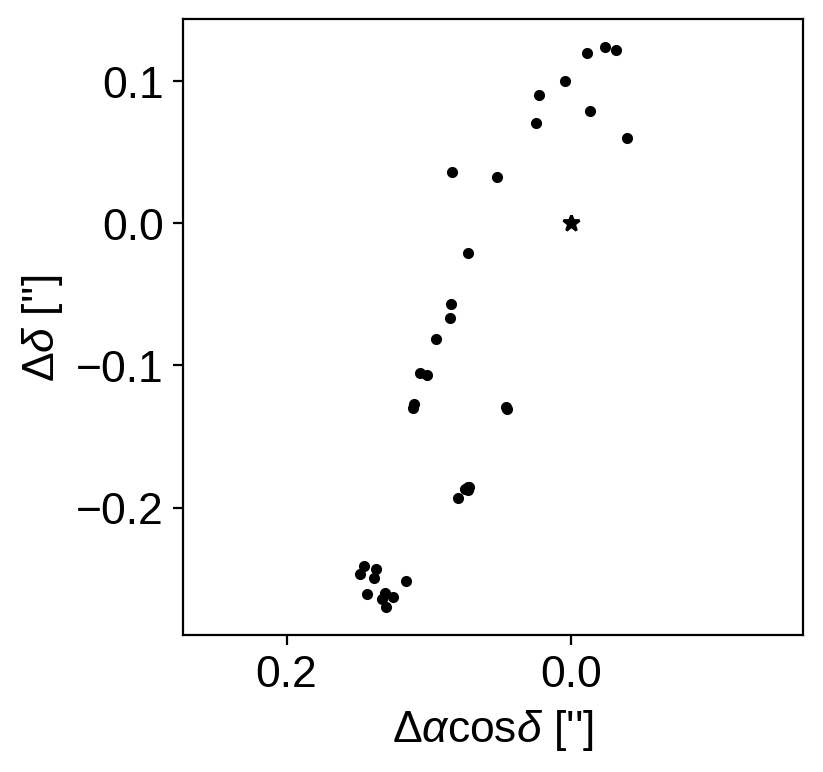

In [5]:
import matplotlib.pyplot as plt

# Make a plot of the astrometric data on the sky
# The convention is that North is up and East is left
fig, ax = plt.subplots(nrows=1, figsize=(4, 4))

xs = rho_data * np.cos(theta_data)  # X is north
ys = rho_data * np.sin(theta_data)  # Y is east
ax.plot(ys, xs, ".k")
ax.set_ylabel(r"$\Delta \delta$ ['']")
ax.set_xlabel(r"$\Delta \alpha \cos \delta$ ['']")
ax.invert_xaxis()
ax.plot(0, 0, "k*")
ax.set_aspect("equal", "datalim")

The plot on the sky is helpful to look at, but the "raw" measurements are the values of $\rho$ (separation) and $\theta$ (also called P.A., position angle) that we listed in our data table, and that the measurement uncertainties live on these values as nice Gaussians. So, to visualize this space more clearly, we can plot $\rho$ vs. time and P.A. vs. time.

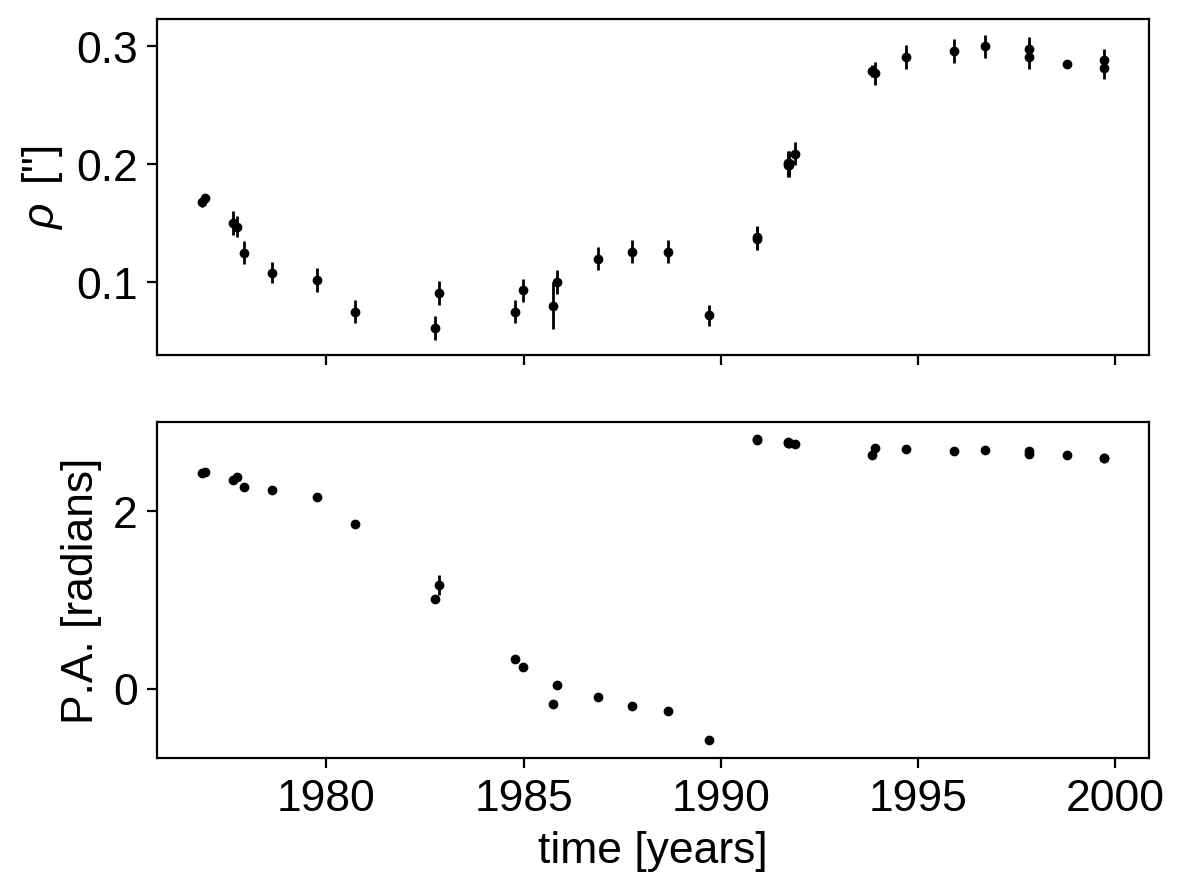

In [6]:
fig, ax = plt.subplots(nrows=2, sharex=True)
ax[0].errorbar(astro_yrs, rho_data, yerr=rho_err, fmt=".k", lw=1, ms=5)
ax[0].set_ylabel(r'$\rho\,$ ["]')

ax[1].errorbar(astro_yrs, theta_data, yerr=theta_err, fmt=".k", lw=1, ms=5)
ax[1].set_ylabel(r"P.A. [radians]")
_ = ax[1].set_xlabel("time [years]")

## Fitting the astrometric orbit with *exoplanet*

To get started, let's import the relative packages from *exoplanet*, plot up a preliminary orbit from the literature, and then sample to find the best parameters.

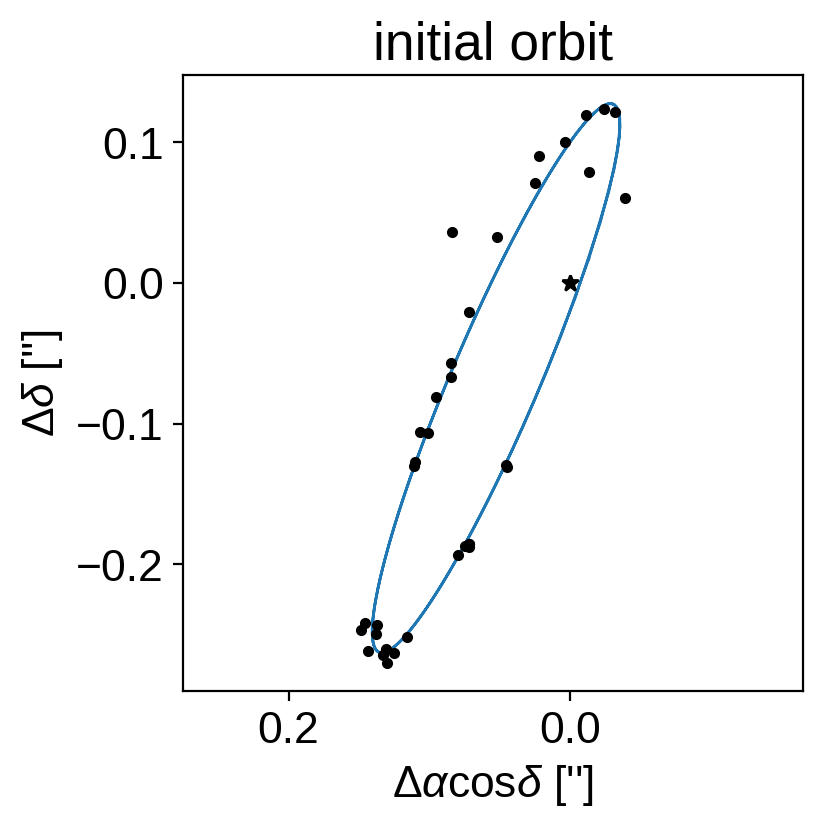

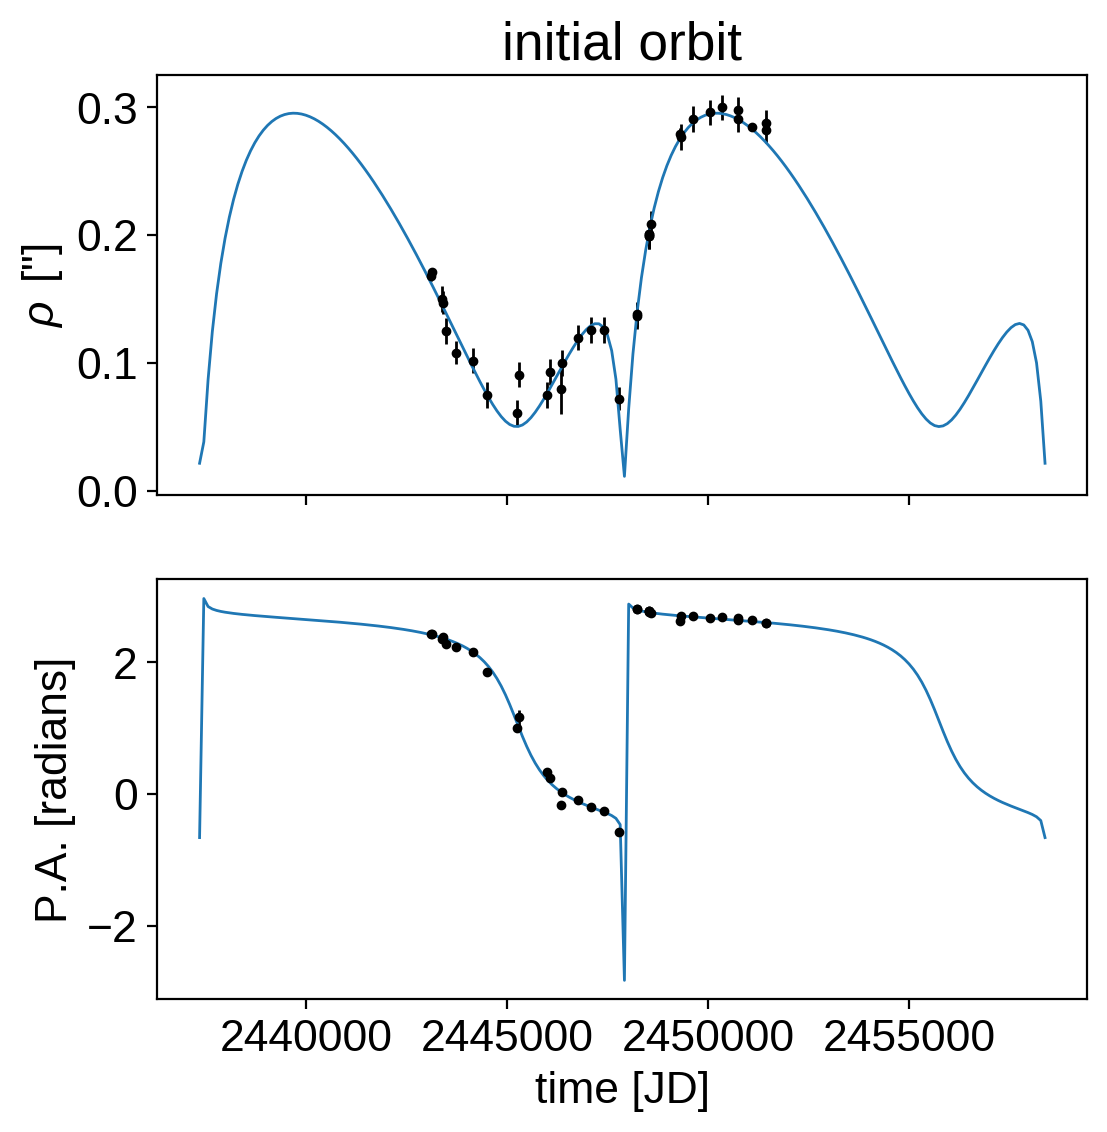

In [7]:
import pymc3 as pm
import theano
import theano.tensor as tt

import exoplanet as xo
from exoplanet.distributions import Angle

from astropy import constants

# conversion constant from au to R_sun
au_to_R_sun = (constants.au / constants.R_sun).value

# Just to get started, let's take a look at the orbit using the best-fit parameters from Pourbaix et al. 1998

# Orbital elements from Pourbaix et al. 1998
# For the relative astrometric fit, we only need the following parameters
a_ang = 0.324  # arcsec
parallax = 1  # arcsec (meaningless choice for now)
a = a_ang * au_to_R_sun / parallax
e = 0.798
i = 96.0 * deg  # [rad]
omega = 251.6 * deg - np.pi  # Pourbaix reports omega_2, but we want omega_1
Omega = 159.6 * deg
P = 28.8 * 365.25  # days

T0 = Time(1989.92, format="decimalyear")
T0.format = "jd"
T0 = T0.value  # [Julian Date]

# instantiate the orbit
orbit = xo.orbits.KeplerianOrbit(
    a=a, t_periastron=T0, period=P, incl=i, ecc=e, omega=omega, Omega=Omega
)

# The position functions take an optional argument parallax to convert from
# physical units back to arcseconds
t = np.linspace(T0 - P, T0 + P, num=200)  # days
rho, theta = theano.function([], orbit.get_relative_angles(t, parallax))()

# Plot the orbit
fig, ax = plt.subplots(nrows=1, figsize=(4, 4))

xs = rho * np.cos(theta)  # X is north
ys = rho * np.sin(theta)  # Y is east
ax.plot(ys, xs, color="C0", lw=1)

# plot the data
xs = rho_data * np.cos(theta_data)  # X is north
ys = rho_data * np.sin(theta_data)  # Y is east
ax.plot(ys, xs, ".k")

ax.set_ylabel(r"$\Delta \delta$ ['']")
ax.set_xlabel(r"$\Delta \alpha \cos \delta$ ['']")
ax.invert_xaxis()
ax.plot(0, 0, "k*")
ax.set_aspect("equal", "datalim")
ax.set_title("initial orbit")

fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
ax[0].errorbar(astro_jds, rho_data, yerr=rho_err, fmt=".k", lw=1, ms=5)
ax[0].plot(t, rho, color="C0", lw=1)
ax[0].set_ylabel(r'$\rho\,$ ["]')
ax[0].set_title("initial orbit")

ax[1].errorbar(astro_jds, theta_data, yerr=theta_err, fmt=".k", lw=1, ms=5)
ax[1].plot(t, theta, color="C0", lw=1)
ax[1].set_ylabel(r"P.A. [radians]")
_ = ax[1].set_xlabel("time [JD]")

Now that we have an initial orbit, we can set the model up using PyMC3 to do inference.

In [8]:
yr = 365.25

# for predicted orbits
t_fine = np.linspace(astro_jds.min() - 500, astro_jds.max() + 500, num=1000)


def get_model(parallax=None):
    with pm.Model() as model:

        if parallax is None:
            # Without an actual parallax measurement, we can model the orbit in units of arcseconds
            # by providing a fake_parallax and conversion constant
            plx = 1  # arcsec
        else:
            # Below we will run a version of this model where a measurement of parallax is provided
            # The measurement is in milliarcsec
            m_plx = pm.Bound(pm.Normal, lower=0, upper=100)(
                "m_plx", mu=parallax[0], sd=parallax[1], testval=parallax[0]
            )
            plx = pm.Deterministic("plx", 1e-3 * m_plx)

        a_ang = pm.Uniform("a_ang", 0.1, 1.0, testval=0.324)
        a = pm.Deterministic("a", a_ang / plx)

        # We expect the period to be somewhere in the range of 25 years,
        # so we'll set a broad prior on logP
        logP = pm.Normal(
            "logP", mu=np.log(25 * yr), sd=10.0, testval=np.log(28.8 * yr)
        )
        P = pm.Deterministic("P", tt.exp(logP))

        # For astrometric-only fits, it's generally better to fit in
        # p = (Omega + omega)/2 and m = (Omega - omega)/2 instead of omega and Omega
        # directly
        omega0 = 251.6 * deg - np.pi
        Omega0 = 159.6 * deg
        p = Angle("p", testval=0.5 * (Omega0 + omega0))
        m = Angle("m", testval=0.5 * (Omega0 - omega0))
        omega = pm.Deterministic("omega", p - m)
        Omega = pm.Deterministic("Omega", p + m)

        # For these orbits, it can also be better to fit for a phase angle
        # (relative to a reference time) instead of the time of periasteron
        # passage directly
        phase = Angle("phase", testval=0.0)
        tperi = pm.Deterministic("tperi", T0 + P * phase / (2 * np.pi))

        # Geometric uiform prior on cos(incl)
        cos_incl = pm.Uniform(
            "cos_incl", lower=-1, upper=1, testval=np.cos(96.0 * deg)
        )
        incl = pm.Deterministic("incl", tt.arccos(cos_incl))
        ecc = pm.Uniform("ecc", lower=0.0, upper=1.0, testval=0.798)

        # Set up the orbit
        orbit = xo.orbits.KeplerianOrbit(
            a=a * au_to_R_sun,
            t_periastron=tperi,
            period=P,
            incl=incl,
            ecc=ecc,
            omega=omega,
            Omega=Omega,
        )
        if parallax is not None:
            pm.Deterministic("M_tot", orbit.m_total)

        # Compute the model in rho and theta
        rho_model, theta_model = orbit.get_relative_angles(astro_jds, plx)
        pm.Deterministic("rho_model", rho_model)
        pm.Deterministic("theta_model", theta_model)

        # Add jitter terms to both separation and position angle
        log_rho_s = pm.Normal(
            "log_rho_s", mu=np.log(np.median(rho_err)), sd=5.0
        )
        log_theta_s = pm.Normal(
            "log_theta_s", mu=np.log(np.median(theta_err)), sd=5.0
        )
        rho_tot_err = tt.sqrt(rho_err ** 2 + tt.exp(2 * log_rho_s))
        theta_tot_err = tt.sqrt(theta_err ** 2 + tt.exp(2 * log_theta_s))

        # define the likelihood function, e.g., a Gaussian on both rho and theta
        pm.Normal("rho_obs", mu=rho_model, sd=rho_tot_err, observed=rho_data)

        # We want to be cognizant of the fact that theta wraps so the following is equivalent to
        # pm.Normal("obs_theta", mu=theta_model, observed=theta_data, sd=theta_tot_err)
        # but takes into account the wrapping. Thanks to Rob de Rosa for the tip.
        theta_diff = tt.arctan2(
            tt.sin(theta_model - theta_data), tt.cos(theta_model - theta_data)
        )
        pm.Normal("theta_obs", mu=theta_diff, sd=theta_tot_err, observed=0.0)

        # Set up predicted orbits for later plotting
        rho_dense, theta_dense = orbit.get_relative_angles(t_fine, plx)
        rho_save = pm.Deterministic("rho_save", rho_dense)
        theta_save = pm.Deterministic("theta_save", theta_dense)

        # Optimize to find the initial parameters
        map_soln = model.test_point
        map_soln = xo.optimize(map_soln, vars=[log_rho_s, log_theta_s])
        map_soln = xo.optimize(map_soln, vars=[phase])
        map_soln = xo.optimize(map_soln, vars=[p, m, ecc])
        map_soln = xo.optimize(map_soln, vars=[logP, a_ang, phase])
        map_soln = xo.optimize(map_soln)

    return model, map_soln


model, map_soln = get_model()

optimizing logp for variables: [log_theta_s, log_rho_s]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=1.048555e+02]

1it [00:00, 599.27it/s, logp=1.048555e+02]

2it [00:00, 653.22it/s, logp=1.448865e+02]

3it [00:00, 699.28it/s, logp=1.056457e+02]

4it [00:00, 788.70it/s, logp=1.457994e+02]

5it [00:00, 835.35it/s, logp=1.469999e+02]

6it [00:00, 874.00it/s, logp=1.471434e+02]

7it [00:00, 900.84it/s, logp=1.471440e+02]

8it [00:00, 906.39it/s, logp=1.471440e+02]

9it [00:00, 926.21it/s, logp=1.471440e+02]

10it [00:03,  2.52it/s, logp=1.471440e+02]


message: Optimization terminated successfully.
logp: 104.85554109304441 -> 147.14399186005338


optimizing logp for variables: [phase]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=1.471440e+02]

1it [00:00, 526.66it/s, logp=1.471440e+02]

2it [00:00, 633.20it/s, logp=-1.185831e+04]

3it [00:00, 737.74it/s, logp=1.471671e+02] 

4it [00:00, 776.76it/s, logp=1.472136e+02]

5it [00:00, 850.91it/s, logp=1.473986e+02]

6it [00:00, 844.83it/s, logp=1.481189e+02]

7it [00:00, 889.05it/s, logp=1.507231e+02]

8it [00:00, 888.01it/s, logp=1.565965e+02]

9it [00:00, 894.60it/s, logp=1.634911e+02]

10it [00:00, 903.17it/s, logp=1.666396e+02]

11it [00:00, 911.95it/s, logp=1.675455e+02]

12it [00:00, 904.63it/s, logp=1.676215e+02]

13it [00:00, 915.20it/s, logp=1.676248e+02]

14it [00:00, 925.52it/s, logp=1.676282e+02]

15it [00:00, 913.73it/s, logp=1.676337e+02]

16it [00:00, 915.21it/s, logp=1.676403e+02]

17it [00:00, 916.32it/s, logp=1.676419e+02]

18it [00:00, 919.23it/s, logp=1.676422e+02]

19it [00:00, 922.48it/s, logp=1.676422e+02]

20it [00:00, 926.16it/s, logp=1.676422e+02]

21it [00:00, 934.86it/s, logp=1.676422e+02]

22it [00:01, 19.81it/s, logp=1.676422e+02] 


message: Optimization terminated successfully.
logp: 147.14399186005338 -> 167.64220598197195


optimizing logp for variables: [ecc, m, p]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=1.676422e+02]

1it [00:00, 337.81it/s, logp=1.676422e+02]

2it [00:00, 475.30it/s, logp=-4.521021e+03]

3it [00:00, 558.62it/s, logp=1.682354e+02] 

4it [00:00, 598.29it/s, logp=1.667490e+02]

5it [00:00, 645.26it/s, logp=1.683674e+02]

6it [00:00, 680.36it/s, logp=1.686220e+02]

7it [00:00, 721.89it/s, logp=1.694033e+02]

8it [00:00, 732.53it/s, logp=1.714304e+02]

9it [00:00, 754.16it/s, logp=1.784310e+02]

10it [00:00, 762.39it/s, logp=1.921973e+02]

11it [00:00, 772.76it/s, logp=1.936845e+02]

12it [00:00, 786.92it/s, logp=1.964254e+02]

13it [00:00, 797.16it/s, logp=2.010939e+02]

14it [00:00, 802.39it/s, logp=2.074741e+02]

15it [00:00, 805.15it/s, logp=2.094264e+02]

16it [00:00, 812.44it/s, logp=2.098562e+02]

17it [00:00, 819.23it/s, logp=2.098999e+02]

18it [00:00, 810.28it/s, logp=2.099152e+02]

19it [00:00, 818.61it/s, logp=2.099416e+02]

20it [00:00, 807.17it/s, logp=2.099853e+02]

21it [00:00, 806.56it/s, logp=2.100398e+02]

22it [00:00, 812.39it/s, logp=2.100552e+02]

23it [00:00, 810.92it/s, logp=2.100609e+02]

24it [00:00, 816.47it/s, logp=2.100614e+02]

25it [00:00, 819.39it/s, logp=2.100617e+02]

26it [00:00, 822.52it/s, logp=2.100622e+02]

27it [00:00, 828.53it/s, logp=2.100629e+02]

28it [00:00, 832.51it/s, logp=2.100633e+02]

29it [00:00, 835.39it/s, logp=2.100634e+02]

30it [00:00, 834.32it/s, logp=2.100634e+02]

31it [00:00, 838.82it/s, logp=2.100634e+02]

32it [00:00, 842.27it/s, logp=2.100634e+02]

33it [00:00, 847.57it/s, logp=2.100634e+02]

34it [00:00, 43.36it/s, logp=2.100634e+02] 


message: Optimization terminated successfully.
logp: 167.64220598197198 -> 210.06340668297906


optimizing logp for variables: [phase, a_ang, logP]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=2.100634e+02]

1it [00:00, 529.18it/s, logp=2.100634e+02]

2it [00:00, 671.36it/s, logp=-4.378171e+03]

3it [00:00, 699.09it/s, logp=2.102114e+02] 

4it [00:00, 675.98it/s, logp=2.103607e+02]

5it [00:00, 689.47it/s, logp=2.104883e+02]

6it [00:00, 725.72it/s, logp=2.105011e+02]

7it [00:00, 762.28it/s, logp=2.105011e+02]

8it [00:00, 801.43it/s, logp=2.105014e+02]

9it [00:00, 827.44it/s, logp=2.105014e+02]

10it [00:00, 845.51it/s, logp=2.105014e+02]

11it [00:01,  9.09it/s, logp=2.105014e+02] 


message: Optimization terminated successfully.
logp: 210.0634066829791 -> 210.5013698914921


optimizing logp for variables: [log_theta_s, log_rho_s, ecc, cos_incl, phase, m, p, logP, a_ang]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=2.105014e+02]

1it [00:00, 420.61it/s, logp=2.105014e+02]

2it [00:00, 512.59it/s, logp=-4.041226e+03]

3it [00:00, 598.27it/s, logp=2.124628e+02] 

4it [00:00, 610.10it/s, logp=1.648448e+02]

5it [00:00, 663.24it/s, logp=2.125361e+02]

6it [00:00, 674.72it/s, logp=2.126469e+02]

7it [00:00, 696.41it/s, logp=2.128268e+02]

8it [00:00, 701.49it/s, logp=2.130889e+02]

9it [00:00, 719.72it/s, logp=2.132127e+02]

10it [00:00, 734.84it/s, logp=2.131910e+02]

11it [00:00, 748.69it/s, logp=2.132712e+02]

12it [00:00, 757.37it/s, logp=2.133790e+02]

13it [00:00, 769.40it/s, logp=2.135772e+02]

14it [00:00, 777.21it/s, logp=2.139432e+02]

15it [00:00, 784.12it/s, logp=2.145105e+02]

16it [00:00, 791.88it/s, logp=2.146599e+02]

17it [00:00, 795.49it/s, logp=2.148474e+02]

18it [00:00, 801.44it/s, logp=2.149170e+02]

19it [00:00, 777.15it/s, logp=2.149377e+02]

20it [00:00, 775.25it/s, logp=2.149628e+02]

21it [00:00, 775.31it/s, logp=2.149864e+02]

22it [00:00, 782.95it/s, logp=2.150041e+02]

23it [00:00, 787.84it/s, logp=2.150108e+02]

24it [00:00, 788.62it/s, logp=2.150182e+02]

25it [00:00, 791.11it/s, logp=2.150205e+02]

26it [00:00, 793.90it/s, logp=2.150210e+02]

27it [00:00, 793.85it/s, logp=2.150212e+02]

28it [00:00, 786.83it/s, logp=2.150212e+02]

29it [00:00, 790.75it/s, logp=2.150212e+02]

30it [00:00, 787.61it/s, logp=2.150212e+02]

31it [00:00, 792.24it/s, logp=2.150212e+02]

32it [00:00, 795.09it/s, logp=2.150212e+02]

33it [00:00, 797.44it/s, logp=2.150212e+02]

34it [00:00, 794.00it/s, logp=2.150212e+02]

35it [00:00, 799.78it/s, logp=2.150212e+02]

36it [00:00, 806.14it/s, logp=2.150212e+02]

37it [00:00, 809.76it/s, logp=2.150212e+02]

38it [00:00, 804.11it/s, logp=2.150212e+02]

39it [00:00, 810.01it/s, logp=2.150212e+02]

40it [00:00, 815.31it/s, logp=2.150212e+02]

41it [00:00, 819.80it/s, logp=2.150212e+02]

42it [00:00, 824.41it/s, logp=2.150212e+02]

43it [00:00, 828.80it/s, logp=2.150212e+02]

44it [00:00, 832.20it/s, logp=2.150212e+02]

45it [00:00, 832.18it/s, logp=2.150212e+02]

46it [00:00, 836.42it/s, logp=2.150212e+02]

47it [00:00, 839.69it/s, logp=2.150212e+02]

48it [00:00, 842.14it/s, logp=2.150212e+02]

49it [00:00, 846.65it/s, logp=2.150212e+02]

50it [00:00, 850.07it/s, logp=2.150212e+02]

51it [00:00, 853.59it/s, logp=2.150212e+02]

52it [00:00, 857.43it/s, logp=2.150212e+02]

53it [00:00, 859.82it/s, logp=2.150212e+02]

54it [00:00, 862.74it/s, logp=2.150212e+02]

55it [00:00, 865.68it/s, logp=2.150212e+02]

56it [00:00, 868.81it/s, logp=2.150212e+02]

57it [00:00, 870.53it/s, logp=2.150212e+02]

58it [00:00, 873.60it/s, logp=2.150212e+02]

59it [00:00, 877.27it/s, logp=2.150212e+02]

60it [00:00, 880.91it/s, logp=2.150212e+02]

61it [00:00, 884.16it/s, logp=2.150212e+02]

62it [00:00, 886.71it/s, logp=2.150212e+02]

63it [00:00, 885.92it/s, logp=2.150212e+02]

64it [00:00, 888.65it/s, logp=2.150212e+02]

65it [00:00, 891.33it/s, logp=2.150212e+02]

66it [00:00, 893.66it/s, logp=2.150212e+02]

67it [00:00, 888.88it/s, logp=2.150212e+02]

68it [00:00, 891.36it/s, logp=2.150212e+02]

69it [00:00, 891.59it/s, logp=2.150212e+02]

70it [00:00, 893.87it/s, logp=2.150212e+02]

71it [00:00, 893.88it/s, logp=2.150212e+02]

72it [00:00, 895.50it/s, logp=2.150212e+02]

73it [00:00, 877.34it/s, logp=2.150212e+02]

74it [00:00, 878.93it/s, logp=2.150212e+02]

75it [00:00, 880.96it/s, logp=2.150212e+02]

76it [00:00, 883.74it/s, logp=2.150212e+02]

77it [00:00, 886.21it/s, logp=2.150212e+02]

78it [00:00, 888.52it/s, logp=2.150212e+02]

79it [00:00, 890.32it/s, logp=2.150212e+02]

80it [00:00, 892.64it/s, logp=2.150212e+02]

81it [00:00, 893.22it/s, logp=2.150212e+02]

82it [00:00, 894.74it/s, logp=2.150212e+02]

83it [00:00, 896.00it/s, logp=2.150212e+02]

84it [00:00, 897.60it/s, logp=2.150212e+02]

85it [00:00, 899.13it/s, logp=2.150212e+02]

86it [00:00, 894.53it/s, logp=2.150212e+02]

87it [00:00, 892.98it/s, logp=2.150212e+02]

88it [00:00, 894.40it/s, logp=2.150212e+02]

89it [00:00, 896.17it/s, logp=2.150212e+02]

90it [00:00, 897.66it/s, logp=2.150212e+02]

91it [00:00, 904.05it/s, logp=2.150212e+02]

91it [00:00, 904.05it/s, logp=2.150212e+02]

92it [00:00, 904.05it/s, logp=2.150212e+02]

93it [00:00, 904.05it/s, logp=2.150212e+02]

94it [00:00, 904.05it/s, logp=2.150212e+02]

95it [00:00, 904.05it/s, logp=2.150212e+02]

96it [00:00, 904.05it/s, logp=2.150212e+02]

97it [00:00, 904.05it/s, logp=2.150212e+02]

98it [00:00, 904.05it/s, logp=2.150212e+02]

99it [00:00, 904.05it/s, logp=2.150212e+02]

100it [00:00, 904.05it/s, logp=2.150212e+02]

101it [00:00, 904.05it/s, logp=2.150212e+02]

102it [00:00, 119.07it/s, logp=2.150212e+02]


message: Optimization terminated successfully.
logp: 210.5013698914921 -> 215.02117742211766


Now that we have a maximum a posteriori estimate of the parameters, let's take a look at the results to make sure that they seem reasonable.

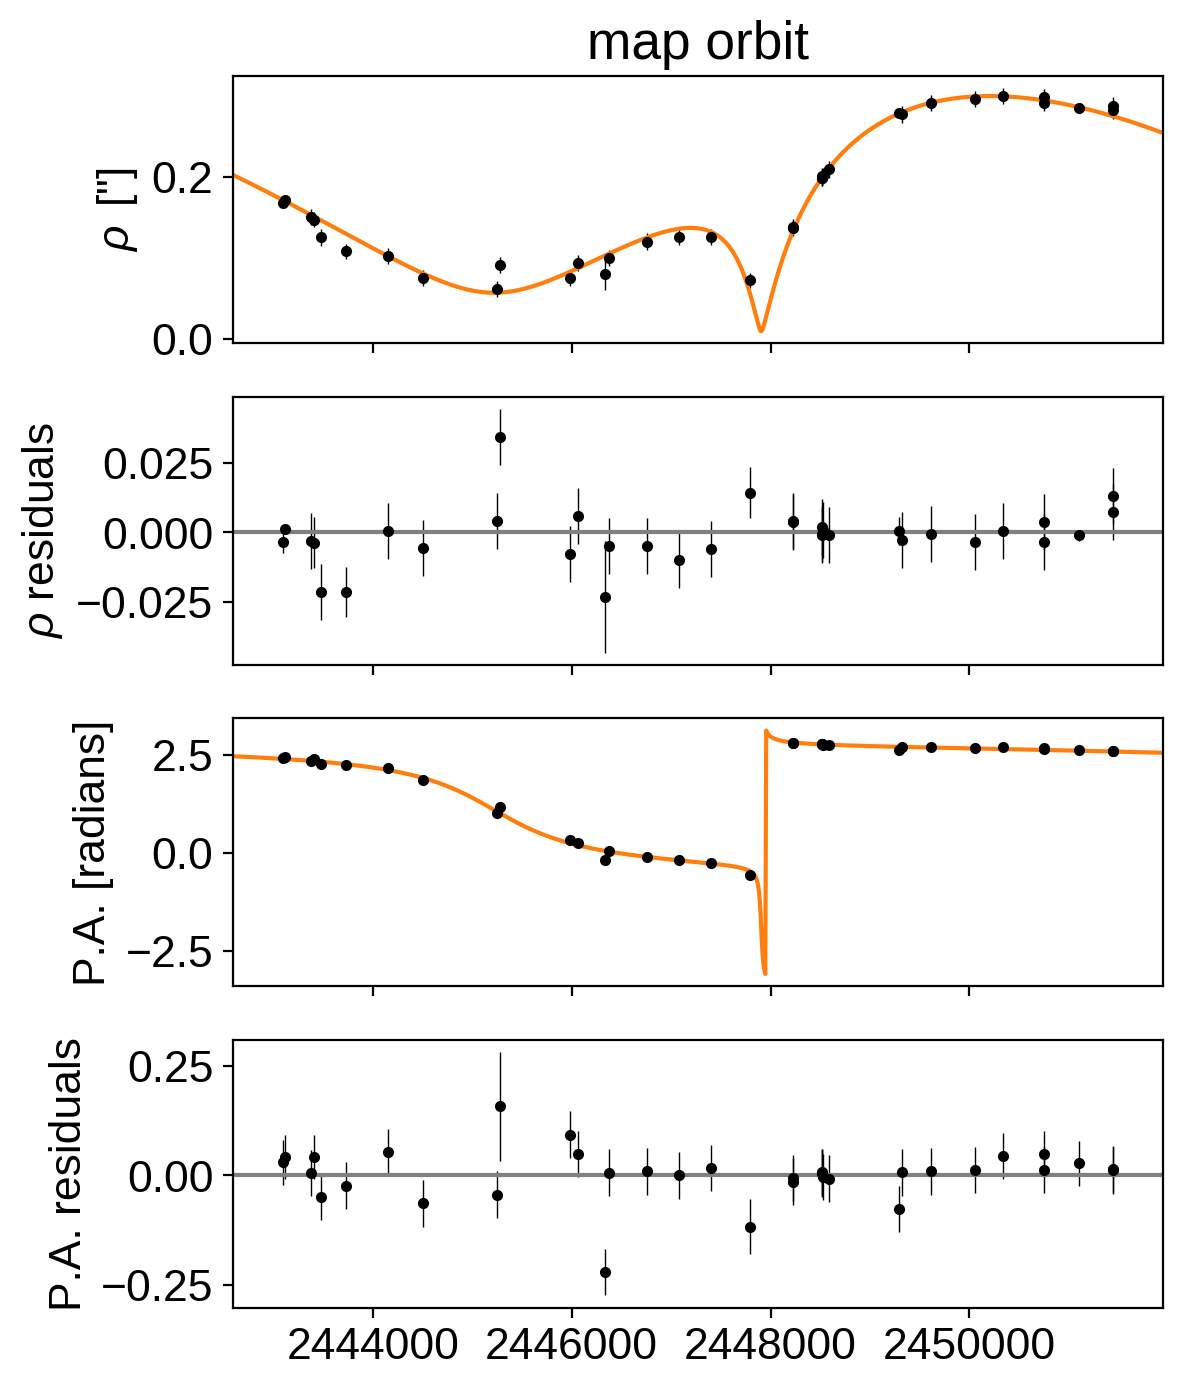

In [9]:
ekw = dict(fmt=".k", lw=0.5)

fig, ax = plt.subplots(nrows=4, sharex=True, figsize=(6, 8))
ax[0].set_ylabel(r'$\rho\,$ ["]')
ax[1].set_ylabel(r"$\rho$ residuals")
ax[2].set_ylabel(r"P.A. [radians]")
ax[3].set_ylabel(r"P.A. residuals")

tot_rho_err = np.sqrt(rho_err ** 2 + np.exp(2 * map_soln["log_rho_s"]))
tot_theta_err = np.sqrt(theta_err ** 2 + np.exp(2 * map_soln["log_theta_s"]))

ax[0].errorbar(astro_jds, rho_data, yerr=tot_rho_err, **ekw)
ax[0].plot(t_fine, map_soln["rho_save"], "C1")

ax[1].axhline(0.0, color="0.5")
ax[1].errorbar(
    astro_jds, rho_data - map_soln["rho_model"], yerr=tot_rho_err, **ekw
)


ax[2].plot(t_fine, map_soln["theta_save"], "C1")
ax[2].errorbar(astro_jds, theta_data, yerr=tot_theta_err, **ekw)

ax[3].axhline(0.0, color="0.5")
ax[3].errorbar(
    astro_jds, theta_data - map_soln["theta_model"], yerr=tot_theta_err, **ekw
)

ax[3].set_xlim(t_fine[0], t_fine[-1])
_ = ax[0].set_title("map orbit")

Now let's sample the posterior.

In [10]:
np.random.seed(1234)
with model:
    trace = pm.sample(
        tune=5000,
        draws=4000,
        start=map_soln,
        cores=2,
        chains=2,
        step=xo.get_dense_nuts_step(target_accept=0.9, adaptation_window=201),
    )

Multiprocess sampling (2 chains in 2 jobs)


NUTS: [log_theta_s, log_rho_s, ecc, cos_incl, phase, m, p, logP, a_ang]


Sampling 2 chains, 0 divergences:   0%|          | 0/18000 [00:00<?, ?draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 7/18000 [00:00<04:26, 67.64draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 10/18000 [00:00<06:53, 43.45draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 13/18000 [00:00<09:38, 31.07draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 16/18000 [00:00<11:15, 26.62draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 19/18000 [00:00<12:50, 23.34draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 22/18000 [00:00<12:02, 24.89draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 25/18000 [00:01<14:41, 20.38draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 28/18000 [00:01<13:52, 21.58draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 31/18000 [00:01<14:54, 20.10draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 34/18000 [00:01<14:13, 21.06draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 37/18000 [00:01<13:56, 21.47draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 40/18000 [00:01<14:26, 20.73draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 43/18000 [00:01<13:50, 21.63draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 46/18000 [00:01<12:57, 23.10draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 49/18000 [00:02<15:09, 19.73draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 52/18000 [00:02<13:52, 21.55draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 55/18000 [00:02<15:36, 19.16draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 58/18000 [00:02<14:02, 21.30draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 61/18000 [00:02<13:22, 22.35draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 64/18000 [00:02<15:01, 19.90draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 67/18000 [00:03<14:14, 20.99draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 70/18000 [00:03<13:32, 22.07draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 73/18000 [00:03<14:26, 20.68draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 76/18000 [00:03<14:17, 20.91draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 79/18000 [00:03<14:53, 20.06draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 82/18000 [00:03<14:14, 20.97draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 86/18000 [00:03<12:54, 23.14draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 89/18000 [00:04<13:42, 21.79draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 92/18000 [00:04<12:46, 23.36draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 95/18000 [00:04<14:55, 20.00draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 98/18000 [00:04<13:49, 21.58draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 101/18000 [00:04<15:55, 18.73draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 104/18000 [00:04<14:47, 20.16draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 107/18000 [00:04<13:26, 22.19draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 110/18000 [00:04<13:11, 22.61draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 113/18000 [00:05<12:46, 23.34draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 116/18000 [00:05<12:23, 24.05draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 119/18000 [00:05<11:45, 25.36draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 122/18000 [00:05<14:14, 20.92draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 125/18000 [00:05<13:17, 22.40draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 128/18000 [00:05<13:44, 21.69draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 131/18000 [00:05<14:19, 20.79draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 134/18000 [00:06<13:16, 22.44draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 137/18000 [00:06<12:30, 23.82draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 140/18000 [00:06<12:29, 23.84draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 143/18000 [00:06<12:06, 24.57draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 148/18000 [00:06<11:14, 26.48draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 151/18000 [00:06<11:31, 25.82draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 154/18000 [00:06<12:19, 24.13draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 157/18000 [00:06<11:47, 25.23draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 160/18000 [00:07<11:29, 25.88draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 163/18000 [00:07<11:03, 26.88draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 166/18000 [00:07<10:46, 27.59draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 171/18000 [00:07<10:09, 29.25draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 175/18000 [00:07<09:31, 31.17draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 179/18000 [00:07<09:13, 32.22draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 183/18000 [00:07<09:33, 31.09draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 187/18000 [00:07<09:00, 32.99draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 191/18000 [00:07<09:10, 32.35draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 195/18000 [00:08<09:54, 29.93draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 199/18000 [00:08<10:38, 27.88draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 202/18000 [00:08<10:42, 27.70draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 205/18000 [00:08<13:27, 22.04draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 208/18000 [00:08<12:36, 23.51draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 211/18000 [00:08<12:14, 24.23draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 214/18000 [00:08<12:34, 23.58draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 217/18000 [00:09<13:00, 22.78draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 220/18000 [00:09<13:17, 22.29draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 223/18000 [00:09<12:50, 23.08draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 227/18000 [00:09<11:40, 25.38draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 230/18000 [00:09<11:35, 25.55draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 233/18000 [00:09<11:09, 26.55draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 236/18000 [00:09<12:15, 24.15draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 240/18000 [00:10<11:19, 26.15draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 243/18000 [00:10<12:24, 23.84draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 246/18000 [00:10<12:40, 23.34draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 249/18000 [00:10<13:20, 22.19draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 253/18000 [00:10<12:19, 24.00draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 257/18000 [00:10<11:19, 26.11draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 260/18000 [00:10<11:02, 26.78draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 264/18000 [00:10<10:12, 28.95draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 268/18000 [00:11<09:46, 30.23draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 272/18000 [00:11<09:53, 29.87draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 277/18000 [00:11<09:56, 29.71draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 281/18000 [00:11<10:10, 29.03draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 284/18000 [00:11<10:48, 27.30draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 287/18000 [00:11<12:05, 24.41draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 290/18000 [00:11<13:05, 22.55draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 293/18000 [00:12<13:37, 21.67draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 299/18000 [00:12<11:23, 25.91draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 302/18000 [00:12<11:06, 26.55draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 305/18000 [00:12<10:51, 27.16draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 308/18000 [00:12<11:35, 25.43draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 311/18000 [00:12<11:41, 25.21draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 314/18000 [00:12<12:39, 23.28draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 317/18000 [00:12<12:17, 23.99draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 320/18000 [00:13<11:43, 25.13draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 324/18000 [00:13<10:27, 28.16draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 327/18000 [00:13<10:34, 27.86draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 330/18000 [00:13<10:26, 28.19draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 334/18000 [00:13<10:07, 29.10draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 338/18000 [00:13<09:28, 31.06draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 342/18000 [00:13<10:02, 29.30draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 347/18000 [00:13<09:43, 30.25draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 351/18000 [00:14<09:23, 31.34draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 355/18000 [00:14<08:56, 32.91draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 359/18000 [00:14<10:51, 27.07draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 362/18000 [00:14<11:26, 25.68draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 365/18000 [00:14<11:14, 26.13draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 368/18000 [00:14<11:12, 26.21draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 371/18000 [00:14<12:11, 24.10draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 374/18000 [00:14<11:42, 25.10draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 377/18000 [00:15<11:11, 26.25draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 380/18000 [00:15<12:11, 24.08draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 383/18000 [00:15<11:36, 25.29draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 387/18000 [00:15<10:21, 28.33draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 393/18000 [00:15<08:48, 33.34draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 399/18000 [00:15<07:54, 37.09draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 410/18000 [00:15<06:20, 46.24draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 422/18000 [00:15<05:11, 56.37draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 438/18000 [00:15<04:13, 69.20draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 452/18000 [00:16<03:39, 79.90draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 464/18000 [00:16<03:18, 88.52draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 479/18000 [00:16<02:54, 100.51draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 494/18000 [00:16<02:37, 111.35draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 507/18000 [00:16<02:30, 116.35draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 520/18000 [00:16<02:30, 116.38draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 533/18000 [00:16<02:41, 108.10draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 545/18000 [00:16<02:42, 107.65draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 559/18000 [00:16<02:31, 115.41draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 572/18000 [00:17<02:37, 110.49draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 587/18000 [00:17<02:26, 118.51draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 601/18000 [00:17<02:20, 123.74draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 614/18000 [00:17<02:22, 122.26draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 629/18000 [00:17<02:15, 128.21draws/s]

Sampling 2 chains, 0 divergences:   4%|▎         | 643/18000 [00:17<02:15, 127.72draws/s]

Sampling 2 chains, 0 divergences:   4%|▎         | 659/18000 [00:17<02:08, 135.39draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 681/18000 [00:17<01:53, 152.08draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 706/18000 [00:17<01:41, 170.90draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 725/18000 [00:17<01:38, 175.54draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 744/18000 [00:18<01:38, 175.61draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 763/18000 [00:18<01:40, 172.03draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 787/18000 [00:18<01:31, 187.48draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 809/18000 [00:18<01:28, 194.04draws/s]

Sampling 2 chains, 0 divergences:   5%|▍         | 837/18000 [00:18<01:20, 213.45draws/s]

Sampling 2 chains, 0 divergences:   5%|▍         | 862/18000 [00:18<01:17, 222.27draws/s]

Sampling 2 chains, 0 divergences:   5%|▍         | 886/18000 [00:18<01:21, 209.61draws/s]

Sampling 2 chains, 0 divergences:   5%|▌         | 908/18000 [00:18<01:20, 211.10draws/s]

Sampling 2 chains, 0 divergences:   5%|▌         | 931/18000 [00:18<01:19, 214.20draws/s]

Sampling 2 chains, 0 divergences:   5%|▌         | 955/18000 [00:19<01:19, 213.22draws/s]

Sampling 2 chains, 0 divergences:   5%|▌         | 977/18000 [00:19<01:19, 214.49draws/s]

Sampling 2 chains, 0 divergences:   6%|▌         | 999/18000 [00:19<01:21, 208.39draws/s]

Sampling 2 chains, 0 divergences:   6%|▌         | 1021/18000 [00:19<01:23, 202.45draws/s]

Sampling 2 chains, 0 divergences:   6%|▌         | 1042/18000 [00:19<01:24, 200.64draws/s]

Sampling 2 chains, 0 divergences:   6%|▌         | 1065/18000 [00:19<01:22, 205.49draws/s]

Sampling 2 chains, 0 divergences:   6%|▌         | 1086/18000 [00:19<01:21, 206.58draws/s]

Sampling 2 chains, 0 divergences:   6%|▌         | 1107/18000 [00:19<01:23, 201.34draws/s]

Sampling 2 chains, 0 divergences:   6%|▋         | 1128/18000 [00:19<01:32, 183.23draws/s]

Sampling 2 chains, 0 divergences:   6%|▋         | 1149/18000 [00:20<01:28, 189.92draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 1174/18000 [00:20<01:23, 202.28draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 1199/18000 [00:20<01:18, 214.51draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 1221/18000 [00:20<01:23, 202.03draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 1242/18000 [00:20<01:27, 190.81draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 1264/18000 [00:20<01:24, 196.92draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 1289/18000 [00:20<01:19, 209.00draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 1314/18000 [00:20<01:17, 216.40draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 1337/18000 [00:20<01:17, 214.02draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 1361/18000 [00:21<01:15, 219.68draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 1384/18000 [00:21<01:20, 206.02draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 1405/18000 [00:21<01:24, 195.44draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 1427/18000 [00:21<01:22, 200.98draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 1448/18000 [00:21<01:23, 198.36draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 1472/18000 [00:21<01:20, 206.25draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 1493/18000 [00:21<01:23, 197.80draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 1514/18000 [00:21<01:23, 197.72draws/s]

Sampling 2 chains, 0 divergences:   9%|▊         | 1534/18000 [00:21<01:28, 186.16draws/s]

Sampling 2 chains, 0 divergences:   9%|▊         | 1553/18000 [00:22<01:30, 180.77draws/s]

Sampling 2 chains, 0 divergences:   9%|▊         | 1572/18000 [00:22<01:31, 179.33draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 1592/18000 [00:22<01:30, 181.79draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 1612/18000 [00:22<01:28, 184.44draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 1635/18000 [00:22<01:24, 193.33draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 1656/18000 [00:22<01:23, 196.72draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 1677/18000 [00:22<01:22, 198.91draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 1699/18000 [00:22<01:20, 203.73draws/s]

Sampling 2 chains, 0 divergences:  10%|▉         | 1720/18000 [00:22<01:20, 202.46draws/s]

Sampling 2 chains, 0 divergences:  10%|▉         | 1743/18000 [00:23<01:18, 206.48draws/s]

Sampling 2 chains, 0 divergences:  10%|▉         | 1766/18000 [00:23<01:16, 212.10draws/s]

Sampling 2 chains, 0 divergences:  10%|▉         | 1788/18000 [00:23<01:19, 203.57draws/s]

Sampling 2 chains, 0 divergences:  10%|█         | 1811/18000 [00:23<01:17, 209.43draws/s]

Sampling 2 chains, 0 divergences:  10%|█         | 1834/18000 [00:23<01:15, 213.52draws/s]

Sampling 2 chains, 0 divergences:  10%|█         | 1860/18000 [00:23<01:11, 224.63draws/s]

Sampling 2 chains, 0 divergences:  10%|█         | 1883/18000 [00:23<01:14, 215.29draws/s]

Sampling 2 chains, 0 divergences:  11%|█         | 1905/18000 [00:23<01:17, 208.37draws/s]

Sampling 2 chains, 0 divergences:  11%|█         | 1929/18000 [00:23<01:14, 215.57draws/s]

Sampling 2 chains, 0 divergences:  11%|█         | 1951/18000 [00:23<01:17, 205.99draws/s]

Sampling 2 chains, 0 divergences:  11%|█         | 1972/18000 [00:24<01:21, 196.95draws/s]

Sampling 2 chains, 0 divergences:  11%|█         | 1995/18000 [00:24<01:18, 204.63draws/s]

Sampling 2 chains, 0 divergences:  11%|█         | 2016/18000 [00:24<01:21, 196.73draws/s]

Sampling 2 chains, 0 divergences:  11%|█▏        | 2037/18000 [00:24<01:20, 198.83draws/s]

Sampling 2 chains, 0 divergences:  11%|█▏        | 2059/18000 [00:24<01:19, 201.20draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 2080/18000 [00:24<01:29, 177.09draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 2099/18000 [00:24<01:32, 172.82draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 2122/18000 [00:24<01:25, 185.93draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 2142/18000 [00:25<01:32, 172.36draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 2160/18000 [00:25<01:33, 168.90draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 2179/18000 [00:25<01:30, 174.48draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 2202/18000 [00:25<01:24, 187.81draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 2222/18000 [00:25<01:26, 181.52draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 2241/18000 [00:25<01:28, 178.48draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 2263/18000 [00:25<01:24, 186.08draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 2288/18000 [00:25<01:18, 201.38draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 2310/18000 [00:25<01:16, 206.18draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 2332/18000 [00:25<01:15, 208.26draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 2354/18000 [00:26<01:15, 206.18draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 2375/18000 [00:26<01:15, 206.09draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 2396/18000 [00:26<01:18, 199.85draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 2417/18000 [00:26<01:18, 199.01draws/s]

Sampling 2 chains, 0 divergences:  14%|█▎        | 2438/18000 [00:26<01:20, 193.11draws/s]

Sampling 2 chains, 0 divergences:  14%|█▎        | 2460/18000 [00:26<01:17, 200.06draws/s]

Sampling 2 chains, 0 divergences:  14%|█▍        | 2481/18000 [00:26<01:22, 188.68draws/s]

Sampling 2 chains, 0 divergences:  14%|█▍        | 2501/18000 [00:26<01:27, 178.12draws/s]

Sampling 2 chains, 0 divergences:  14%|█▍        | 2520/18000 [00:26<01:27, 176.64draws/s]

Sampling 2 chains, 0 divergences:  14%|█▍        | 2539/18000 [00:27<01:26, 179.78draws/s]

Sampling 2 chains, 0 divergences:  14%|█▍        | 2560/18000 [00:27<01:22, 186.18draws/s]

Sampling 2 chains, 0 divergences:  14%|█▍        | 2582/18000 [00:27<01:19, 195.08draws/s]

Sampling 2 chains, 0 divergences:  14%|█▍        | 2607/18000 [00:27<01:14, 207.08draws/s]

Sampling 2 chains, 0 divergences:  15%|█▍        | 2629/18000 [00:27<01:15, 203.28draws/s]

Sampling 2 chains, 0 divergences:  15%|█▍        | 2650/18000 [00:27<01:16, 199.90draws/s]

Sampling 2 chains, 0 divergences:  15%|█▍        | 2671/18000 [00:27<01:18, 195.82draws/s]

Sampling 2 chains, 0 divergences:  15%|█▍        | 2692/18000 [00:27<01:17, 196.57draws/s]

Sampling 2 chains, 0 divergences:  15%|█▌        | 2714/18000 [00:27<01:16, 199.64draws/s]

Sampling 2 chains, 0 divergences:  15%|█▌        | 2737/18000 [00:28<01:13, 206.75draws/s]

Sampling 2 chains, 0 divergences:  15%|█▌        | 2764/18000 [00:28<01:09, 220.22draws/s]

Sampling 2 chains, 0 divergences:  15%|█▌        | 2787/18000 [00:28<01:14, 204.40draws/s]

Sampling 2 chains, 0 divergences:  16%|█▌        | 2808/18000 [00:28<01:20, 189.58draws/s]

Sampling 2 chains, 0 divergences:  16%|█▌        | 2828/18000 [00:28<01:21, 185.34draws/s]

Sampling 2 chains, 0 divergences:  16%|█▌        | 2848/18000 [00:28<01:20, 189.29draws/s]

Sampling 2 chains, 0 divergences:  16%|█▌        | 2871/18000 [00:28<01:16, 197.21draws/s]

Sampling 2 chains, 0 divergences:  16%|█▌        | 2896/18000 [00:28<01:12, 208.82draws/s]

Sampling 2 chains, 0 divergences:  16%|█▌        | 2918/18000 [00:28<01:11, 211.75draws/s]

Sampling 2 chains, 0 divergences:  16%|█▋        | 2940/18000 [00:29<01:16, 196.87draws/s]

Sampling 2 chains, 0 divergences:  16%|█▋        | 2961/18000 [00:29<01:20, 186.86draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 2981/18000 [00:29<01:21, 184.40draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 3003/18000 [00:29<01:18, 190.41draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 3023/18000 [00:29<01:21, 183.58draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 3042/18000 [00:29<01:21, 184.02draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 3069/18000 [00:29<01:14, 201.67draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 3092/18000 [00:29<01:12, 206.68draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 3114/18000 [00:29<01:16, 195.73draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 3135/18000 [00:30<01:16, 194.35draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 3157/18000 [00:30<01:15, 197.64draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 3178/18000 [00:30<01:14, 198.91draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 3199/18000 [00:30<01:17, 191.52draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 3219/18000 [00:30<01:18, 188.62draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 3242/18000 [00:30<01:14, 197.84draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 3267/18000 [00:30<01:10, 209.97draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 3289/18000 [00:30<01:11, 205.89draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 3313/18000 [00:30<01:08, 213.56draws/s]

Sampling 2 chains, 0 divergences:  19%|█▊        | 3337/18000 [00:31<01:06, 220.77draws/s]

Sampling 2 chains, 0 divergences:  19%|█▊        | 3360/18000 [00:31<01:07, 217.57draws/s]

Sampling 2 chains, 0 divergences:  19%|█▉        | 3382/18000 [00:31<01:15, 193.61draws/s]

Sampling 2 chains, 0 divergences:  19%|█▉        | 3404/18000 [00:31<01:13, 198.35draws/s]

Sampling 2 chains, 0 divergences:  19%|█▉        | 3425/18000 [00:31<01:15, 192.06draws/s]

Sampling 2 chains, 0 divergences:  19%|█▉        | 3445/18000 [00:31<01:15, 192.93draws/s]

Sampling 2 chains, 0 divergences:  19%|█▉        | 3466/18000 [00:31<01:13, 196.75draws/s]

Sampling 2 chains, 0 divergences:  19%|█▉        | 3486/18000 [00:31<01:14, 194.51draws/s]

Sampling 2 chains, 0 divergences:  19%|█▉        | 3509/18000 [00:31<01:11, 203.57draws/s]

Sampling 2 chains, 0 divergences:  20%|█▉        | 3532/18000 [00:32<01:09, 209.59draws/s]

Sampling 2 chains, 0 divergences:  20%|█▉        | 3554/18000 [00:32<01:09, 207.19draws/s]

Sampling 2 chains, 0 divergences:  20%|█▉        | 3575/18000 [00:32<01:12, 197.80draws/s]

Sampling 2 chains, 0 divergences:  20%|█▉        | 3595/18000 [00:32<01:14, 194.66draws/s]

Sampling 2 chains, 0 divergences:  20%|██        | 3617/18000 [00:32<01:12, 198.55draws/s]

Sampling 2 chains, 0 divergences:  20%|██        | 3637/18000 [00:32<01:19, 179.97draws/s]

Sampling 2 chains, 0 divergences:  20%|██        | 3656/18000 [00:32<01:21, 175.02draws/s]

Sampling 2 chains, 0 divergences:  20%|██        | 3674/18000 [00:32<01:23, 172.05draws/s]

Sampling 2 chains, 0 divergences:  21%|██        | 3692/18000 [00:32<01:24, 170.13draws/s]

Sampling 2 chains, 0 divergences:  21%|██        | 3712/18000 [00:33<01:20, 177.61draws/s]

Sampling 2 chains, 0 divergences:  21%|██        | 3735/18000 [00:33<01:15, 188.91draws/s]

Sampling 2 chains, 0 divergences:  21%|██        | 3756/18000 [00:33<01:13, 193.05draws/s]

Sampling 2 chains, 0 divergences:  21%|██        | 3779/18000 [00:33<01:10, 202.22draws/s]

Sampling 2 chains, 0 divergences:  21%|██        | 3801/18000 [00:33<01:08, 206.05draws/s]

Sampling 2 chains, 0 divergences:  21%|██        | 3824/18000 [00:33<01:07, 211.26draws/s]

Sampling 2 chains, 0 divergences:  21%|██▏       | 3848/18000 [00:33<01:04, 218.42draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 3871/18000 [00:33<01:04, 218.43draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 3893/18000 [00:33<01:04, 217.88draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 3916/18000 [00:33<01:04, 219.35draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 3939/18000 [00:34<01:08, 206.26draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 3960/18000 [00:34<01:14, 189.40draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 3980/18000 [00:34<01:16, 183.00draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 3999/18000 [00:34<01:21, 171.82draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 4017/18000 [00:34<01:21, 172.35draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 4035/18000 [00:34<01:20, 174.03draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 4059/18000 [00:34<01:13, 188.44draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 4081/18000 [00:34<01:11, 195.84draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 4101/18000 [00:34<01:12, 190.84draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 4122/18000 [00:35<01:10, 195.92draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 4143/18000 [00:35<01:10, 196.68draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 4166/18000 [00:35<01:07, 204.42draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 4188/18000 [00:35<01:06, 207.82draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 4209/18000 [00:35<01:06, 208.04draws/s]

Sampling 2 chains, 0 divergences:  24%|██▎       | 4230/18000 [00:35<01:06, 207.70draws/s]

Sampling 2 chains, 0 divergences:  24%|██▎       | 4251/18000 [00:35<01:07, 202.88draws/s]

Sampling 2 chains, 0 divergences:  24%|██▎       | 4272/18000 [00:35<01:07, 203.59draws/s]

Sampling 2 chains, 0 divergences:  24%|██▍       | 4295/18000 [00:35<01:05, 209.40draws/s]

Sampling 2 chains, 0 divergences:  24%|██▍       | 4317/18000 [00:36<01:06, 207.13draws/s]

Sampling 2 chains, 0 divergences:  24%|██▍       | 4338/18000 [00:36<01:06, 205.70draws/s]

Sampling 2 chains, 0 divergences:  24%|██▍       | 4360/18000 [00:36<01:05, 209.53draws/s]

Sampling 2 chains, 0 divergences:  24%|██▍       | 4382/18000 [00:36<01:09, 195.55draws/s]

Sampling 2 chains, 0 divergences:  24%|██▍       | 4402/18000 [00:36<01:12, 188.62draws/s]

Sampling 2 chains, 0 divergences:  25%|██▍       | 4422/18000 [00:36<01:12, 186.10draws/s]

Sampling 2 chains, 0 divergences:  25%|██▍       | 4444/18000 [00:36<01:09, 194.41draws/s]

Sampling 2 chains, 0 divergences:  25%|██▍       | 4467/18000 [00:36<01:06, 202.06draws/s]

Sampling 2 chains, 0 divergences:  25%|██▍       | 4491/18000 [00:36<01:04, 209.28draws/s]

Sampling 2 chains, 0 divergences:  25%|██▌       | 4515/18000 [00:36<01:03, 212.72draws/s]

Sampling 2 chains, 0 divergences:  25%|██▌       | 4537/18000 [00:37<01:07, 200.12draws/s]

Sampling 2 chains, 0 divergences:  25%|██▌       | 4559/18000 [00:37<01:05, 205.08draws/s]

Sampling 2 chains, 0 divergences:  25%|██▌       | 4580/18000 [00:37<01:06, 200.55draws/s]

Sampling 2 chains, 0 divergences:  26%|██▌       | 4601/18000 [00:37<01:12, 184.21draws/s]

Sampling 2 chains, 0 divergences:  26%|██▌       | 4623/18000 [00:37<01:10, 190.14draws/s]

Sampling 2 chains, 0 divergences:  26%|██▌       | 4646/18000 [00:37<01:07, 198.00draws/s]

Sampling 2 chains, 0 divergences:  26%|██▌       | 4667/18000 [00:37<01:09, 192.40draws/s]

Sampling 2 chains, 0 divergences:  26%|██▌       | 4687/18000 [00:37<01:08, 193.07draws/s]

Sampling 2 chains, 0 divergences:  26%|██▌       | 4707/18000 [00:38<01:11, 185.65draws/s]

Sampling 2 chains, 0 divergences:  26%|██▋       | 4726/18000 [00:38<01:13, 179.40draws/s]

Sampling 2 chains, 0 divergences:  26%|██▋       | 4748/18000 [00:38<01:10, 189.14draws/s]

Sampling 2 chains, 0 divergences:  26%|██▋       | 4768/18000 [00:38<01:11, 183.87draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 4789/18000 [00:38<01:09, 189.04draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 4815/18000 [00:38<01:04, 205.69draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 4837/18000 [00:38<01:03, 206.10draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 4859/18000 [00:38<01:03, 207.44draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 4881/18000 [00:38<01:06, 197.51draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 4902/18000 [00:38<01:07, 195.41draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 4922/18000 [00:39<01:12, 181.28draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 4941/18000 [00:39<01:14, 176.05draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 4961/18000 [00:39<01:12, 179.80draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 4980/18000 [00:39<01:12, 180.01draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 4999/18000 [00:39<01:13, 176.01draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 5018/18000 [00:39<01:12, 179.62draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 5040/18000 [00:39<01:08, 188.81draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 5060/18000 [00:39<01:14, 173.91draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 5078/18000 [00:40<01:17, 167.27draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 5096/18000 [00:40<01:17, 165.71draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 5113/18000 [00:40<01:17, 166.52draws/s]

Sampling 2 chains, 0 divergences:  29%|██▊       | 5134/18000 [00:40<01:13, 176.23draws/s]

Sampling 2 chains, 0 divergences:  29%|██▊       | 5157/18000 [00:40<01:08, 187.85draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 5181/18000 [00:40<01:04, 199.45draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 5205/18000 [00:40<01:01, 208.11draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 5230/18000 [00:40<00:58, 218.37draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 5253/18000 [00:40<01:00, 209.04draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 5275/18000 [00:41<01:07, 188.38draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 5295/18000 [00:41<01:06, 190.23draws/s]

Sampling 2 chains, 0 divergences:  30%|██▉       | 5315/18000 [00:41<01:08, 185.68draws/s]

Sampling 2 chains, 0 divergences:  30%|██▉       | 5334/18000 [00:41<01:09, 181.19draws/s]

Sampling 2 chains, 0 divergences:  30%|██▉       | 5354/18000 [00:41<01:08, 183.76draws/s]

Sampling 2 chains, 0 divergences:  30%|██▉       | 5373/18000 [00:41<01:09, 182.73draws/s]

Sampling 2 chains, 0 divergences:  30%|██▉       | 5392/18000 [00:41<01:09, 181.81draws/s]

Sampling 2 chains, 0 divergences:  30%|███       | 5412/18000 [00:41<01:07, 185.66draws/s]

Sampling 2 chains, 0 divergences:  30%|███       | 5434/18000 [00:41<01:05, 192.79draws/s]

Sampling 2 chains, 0 divergences:  30%|███       | 5457/18000 [00:41<01:02, 200.35draws/s]

Sampling 2 chains, 0 divergences:  30%|███       | 5478/18000 [00:42<01:05, 190.84draws/s]

Sampling 2 chains, 0 divergences:  31%|███       | 5498/18000 [00:42<01:10, 177.05draws/s]

Sampling 2 chains, 0 divergences:  31%|███       | 5517/18000 [00:42<01:11, 174.34draws/s]

Sampling 2 chains, 0 divergences:  31%|███       | 5537/18000 [00:42<01:09, 178.89draws/s]

Sampling 2 chains, 0 divergences:  31%|███       | 5559/18000 [00:42<01:06, 186.57draws/s]

Sampling 2 chains, 0 divergences:  31%|███       | 5578/18000 [00:42<01:06, 185.82draws/s]

Sampling 2 chains, 0 divergences:  31%|███       | 5597/18000 [00:42<01:06, 185.19draws/s]

Sampling 2 chains, 0 divergences:  31%|███       | 5618/18000 [00:42<01:05, 188.90draws/s]

Sampling 2 chains, 0 divergences:  31%|███▏      | 5638/18000 [00:42<01:04, 191.73draws/s]

Sampling 2 chains, 0 divergences:  31%|███▏      | 5658/18000 [00:43<01:04, 191.56draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 5679/18000 [00:43<01:04, 191.48draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 5703/18000 [00:43<01:01, 201.02draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 5724/18000 [00:43<01:03, 194.57draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 5744/18000 [00:43<01:07, 180.26draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 5763/18000 [00:43<01:10, 174.45draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 5781/18000 [00:43<01:11, 170.98draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 5799/18000 [00:43<01:14, 164.21draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 5819/18000 [00:43<01:10, 173.31draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 5838/18000 [00:44<01:09, 175.38draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 5860/18000 [00:44<01:06, 183.89draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 5880/18000 [00:44<01:04, 186.52draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 5899/18000 [00:44<01:05, 185.81draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 5918/18000 [00:44<01:04, 186.86draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 5941/18000 [00:44<01:01, 197.05draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 5963/18000 [00:44<01:00, 200.16draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 5984/18000 [00:44<01:03, 188.03draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 6004/18000 [00:44<01:06, 180.42draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 6023/18000 [00:45<01:08, 173.76draws/s]

Sampling 2 chains, 0 divergences:  34%|███▎      | 6041/18000 [00:45<01:09, 172.16draws/s]

Sampling 2 chains, 0 divergences:  34%|███▎      | 6063/18000 [00:45<01:05, 180.97draws/s]

Sampling 2 chains, 0 divergences:  34%|███▍      | 6082/18000 [00:45<01:05, 182.36draws/s]

Sampling 2 chains, 0 divergences:  34%|███▍      | 6105/18000 [00:45<01:01, 192.51draws/s]

Sampling 2 chains, 0 divergences:  34%|███▍      | 6125/18000 [00:45<01:04, 185.12draws/s]

Sampling 2 chains, 0 divergences:  34%|███▍      | 6144/18000 [00:45<01:10, 168.38draws/s]

Sampling 2 chains, 0 divergences:  34%|███▍      | 6162/18000 [00:45<01:09, 171.10draws/s]

Sampling 2 chains, 0 divergences:  34%|███▍      | 6180/18000 [00:45<01:11, 164.27draws/s]

Sampling 2 chains, 0 divergences:  34%|███▍      | 6200/18000 [00:46<01:09, 170.06draws/s]

Sampling 2 chains, 0 divergences:  35%|███▍      | 6220/18000 [00:46<01:06, 177.58draws/s]

Sampling 2 chains, 0 divergences:  35%|███▍      | 6241/18000 [00:46<01:03, 184.32draws/s]

Sampling 2 chains, 0 divergences:  35%|███▍      | 6262/18000 [00:46<01:02, 189.07draws/s]

Sampling 2 chains, 0 divergences:  35%|███▍      | 6284/18000 [00:46<00:59, 196.95draws/s]

Sampling 2 chains, 0 divergences:  35%|███▌      | 6307/18000 [00:46<00:56, 205.30draws/s]

Sampling 2 chains, 0 divergences:  35%|███▌      | 6328/18000 [00:46<00:59, 196.84draws/s]

Sampling 2 chains, 0 divergences:  35%|███▌      | 6349/18000 [00:46<00:58, 199.40draws/s]

Sampling 2 chains, 0 divergences:  35%|███▌      | 6374/18000 [00:46<00:55, 210.39draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 6400/18000 [00:47<00:52, 222.38draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 6423/18000 [00:47<00:52, 219.86draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 6446/18000 [00:47<00:56, 205.79draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 6467/18000 [00:47<01:02, 185.99draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 6487/18000 [00:47<01:02, 182.92draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 6506/18000 [00:47<01:02, 183.44draws/s]

Sampling 2 chains, 0 divergences:  36%|███▋      | 6527/18000 [00:47<01:00, 190.18draws/s]

Sampling 2 chains, 0 divergences:  36%|███▋      | 6548/18000 [00:47<00:58, 194.17draws/s]

Sampling 2 chains, 0 divergences:  36%|███▋      | 6568/18000 [00:47<00:58, 195.01draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 6588/18000 [00:48<01:03, 180.34draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 6608/18000 [00:48<01:01, 185.51draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 6629/18000 [00:48<01:00, 186.81draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 6648/18000 [00:48<01:03, 177.73draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 6666/18000 [00:48<01:06, 171.01draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 6687/18000 [00:48<01:03, 178.51draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 6710/18000 [00:48<00:59, 190.83draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 6731/18000 [00:48<00:57, 195.60draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 6751/18000 [00:48<00:58, 193.59draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 6771/18000 [00:48<00:57, 195.08draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 6791/18000 [00:49<00:58, 190.86draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 6813/18000 [00:49<00:56, 197.49draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 6837/18000 [00:49<00:53, 208.47draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 6859/18000 [00:49<00:53, 208.51draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 6881/18000 [00:49<00:55, 202.01draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 6903/18000 [00:49<00:54, 204.74draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 6924/18000 [00:49<00:57, 191.54draws/s]

Sampling 2 chains, 0 divergences:  39%|███▊      | 6944/18000 [00:49<01:03, 172.93draws/s]

Sampling 2 chains, 0 divergences:  39%|███▊      | 6962/18000 [00:49<01:03, 173.49draws/s]

Sampling 2 chains, 0 divergences:  39%|███▉      | 6980/18000 [00:50<01:04, 170.65draws/s]

Sampling 2 chains, 0 divergences:  39%|███▉      | 6998/18000 [00:50<01:06, 166.39draws/s]

Sampling 2 chains, 0 divergences:  39%|███▉      | 7015/18000 [00:50<01:07, 163.40draws/s]

Sampling 2 chains, 0 divergences:  39%|███▉      | 7035/18000 [00:50<01:03, 171.51draws/s]

Sampling 2 chains, 0 divergences:  39%|███▉      | 7054/18000 [00:50<01:03, 172.98draws/s]

Sampling 2 chains, 0 divergences:  39%|███▉      | 7072/18000 [00:50<01:07, 160.91draws/s]

Sampling 2 chains, 0 divergences:  39%|███▉      | 7089/18000 [00:50<01:08, 160.28draws/s]

Sampling 2 chains, 0 divergences:  39%|███▉      | 7107/18000 [00:50<01:05, 165.53draws/s]

Sampling 2 chains, 0 divergences:  40%|███▉      | 7125/18000 [00:50<01:04, 168.19draws/s]

Sampling 2 chains, 0 divergences:  40%|███▉      | 7144/18000 [00:51<01:02, 172.91draws/s]

Sampling 2 chains, 0 divergences:  40%|███▉      | 7164/18000 [00:51<01:00, 178.89draws/s]

Sampling 2 chains, 0 divergences:  40%|███▉      | 7184/18000 [00:51<00:58, 184.36draws/s]

Sampling 2 chains, 0 divergences:  40%|████      | 7211/18000 [00:51<00:54, 199.28draws/s]

Sampling 2 chains, 0 divergences:  40%|████      | 7232/18000 [00:51<00:53, 200.78draws/s]

Sampling 2 chains, 0 divergences:  40%|████      | 7253/18000 [00:51<00:58, 184.10draws/s]

Sampling 2 chains, 0 divergences:  40%|████      | 7273/18000 [00:51<00:56, 188.45draws/s]

Sampling 2 chains, 0 divergences:  41%|████      | 7293/18000 [00:51<00:57, 185.83draws/s]

Sampling 2 chains, 0 divergences:  41%|████      | 7312/18000 [00:51<00:58, 181.56draws/s]

Sampling 2 chains, 0 divergences:  41%|████      | 7331/18000 [00:52<00:58, 182.24draws/s]

Sampling 2 chains, 0 divergences:  41%|████      | 7350/18000 [00:52<00:57, 184.42draws/s]

Sampling 2 chains, 0 divergences:  41%|████      | 7369/18000 [00:52<00:58, 180.97draws/s]

Sampling 2 chains, 0 divergences:  41%|████      | 7388/18000 [00:52<01:00, 176.83draws/s]

Sampling 2 chains, 0 divergences:  41%|████      | 7406/18000 [00:52<01:00, 174.26draws/s]

Sampling 2 chains, 0 divergences:  41%|████      | 7424/18000 [00:52<01:01, 171.05draws/s]

Sampling 2 chains, 0 divergences:  41%|████▏     | 7442/18000 [00:52<01:03, 166.15draws/s]

Sampling 2 chains, 0 divergences:  41%|████▏     | 7463/18000 [00:52<00:59, 176.50draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 7482/18000 [00:52<00:58, 178.83draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 7502/18000 [00:53<00:57, 183.57draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 7523/18000 [00:53<00:55, 189.04draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 7543/18000 [00:53<00:56, 184.90draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 7562/18000 [00:53<00:59, 175.92draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 7580/18000 [00:53<00:59, 175.51draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 7601/18000 [00:53<00:56, 182.98draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 7621/18000 [00:53<00:55, 186.08draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 7644/18000 [00:53<00:53, 192.22draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 7665/18000 [00:53<00:53, 193.28draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 7687/18000 [00:53<00:51, 199.04draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 7710/18000 [00:54<00:49, 207.13draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 7733/18000 [00:54<00:48, 210.68draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 7755/18000 [00:54<00:51, 199.85draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 7776/18000 [00:54<00:57, 177.69draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 7795/18000 [00:54<00:57, 176.83draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 7814/18000 [00:54<00:59, 171.87draws/s]

Sampling 2 chains, 0 divergences:  44%|████▎     | 7832/18000 [00:54<00:59, 170.10draws/s]

Sampling 2 chains, 0 divergences:  44%|████▎     | 7853/18000 [00:54<00:56, 179.41draws/s]

Sampling 2 chains, 0 divergences:  44%|████▍     | 7877/18000 [00:55<00:52, 191.48draws/s]

Sampling 2 chains, 0 divergences:  44%|████▍     | 7897/18000 [00:55<00:54, 185.59draws/s]

Sampling 2 chains, 0 divergences:  44%|████▍     | 7916/18000 [00:55<00:55, 182.95draws/s]

Sampling 2 chains, 0 divergences:  44%|████▍     | 7939/18000 [00:55<00:52, 192.24draws/s]

Sampling 2 chains, 0 divergences:  44%|████▍     | 7963/18000 [00:55<00:49, 202.24draws/s]

Sampling 2 chains, 0 divergences:  44%|████▍     | 7984/18000 [00:55<00:49, 201.72draws/s]

Sampling 2 chains, 0 divergences:  44%|████▍     | 8007/18000 [00:55<00:48, 207.22draws/s]

Sampling 2 chains, 0 divergences:  45%|████▍     | 8030/18000 [00:55<00:46, 213.24draws/s]

Sampling 2 chains, 0 divergences:  45%|████▍     | 8052/18000 [00:55<00:52, 190.35draws/s]

Sampling 2 chains, 0 divergences:  45%|████▍     | 8072/18000 [00:56<00:54, 181.22draws/s]

Sampling 2 chains, 0 divergences:  45%|████▍     | 8091/18000 [00:56<00:55, 178.69draws/s]

Sampling 2 chains, 0 divergences:  45%|████▌     | 8110/18000 [00:56<00:55, 178.06draws/s]

Sampling 2 chains, 0 divergences:  45%|████▌     | 8129/18000 [00:56<00:57, 171.32draws/s]

Sampling 2 chains, 0 divergences:  45%|████▌     | 8147/18000 [00:56<00:57, 170.11draws/s]

Sampling 2 chains, 0 divergences:  45%|████▌     | 8168/18000 [00:56<00:54, 180.32draws/s]

Sampling 2 chains, 0 divergences:  46%|████▌     | 8191/18000 [00:56<00:51, 191.14draws/s]

Sampling 2 chains, 0 divergences:  46%|████▌     | 8214/18000 [00:56<00:48, 200.30draws/s]

Sampling 2 chains, 0 divergences:  46%|████▌     | 8235/18000 [00:56<00:48, 201.46draws/s]

Sampling 2 chains, 0 divergences:  46%|████▌     | 8256/18000 [00:56<00:50, 192.68draws/s]

Sampling 2 chains, 0 divergences:  46%|████▌     | 8276/18000 [00:57<00:53, 180.57draws/s]

Sampling 2 chains, 0 divergences:  46%|████▌     | 8295/18000 [00:57<00:53, 182.96draws/s]

Sampling 2 chains, 0 divergences:  46%|████▌     | 8318/18000 [00:57<00:49, 194.89draws/s]

Sampling 2 chains, 0 divergences:  46%|████▋     | 8338/18000 [00:57<00:51, 187.85draws/s]

Sampling 2 chains, 0 divergences:  46%|████▋     | 8358/18000 [00:57<00:51, 188.10draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 8378/18000 [00:57<00:50, 189.19draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 8398/18000 [00:57<00:52, 183.25draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 8422/18000 [00:57<00:48, 195.73draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 8449/18000 [00:57<00:44, 212.70draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 8472/18000 [00:58<00:44, 215.58draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 8495/18000 [00:58<00:43, 216.75draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 8518/18000 [00:58<00:44, 214.88draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 8540/18000 [00:58<00:46, 201.42draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 8561/18000 [00:58<00:51, 182.89draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 8580/18000 [00:58<00:55, 168.60draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 8598/18000 [00:58<00:56, 167.08draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 8619/18000 [00:58<00:53, 176.73draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 8638/18000 [00:59<00:54, 172.89draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 8656/18000 [00:59<00:54, 170.46draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 8674/18000 [00:59<00:54, 171.15draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 8695/18000 [00:59<00:51, 180.75draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 8714/18000 [00:59<00:50, 182.97draws/s]

Sampling 2 chains, 0 divergences:  49%|████▊     | 8733/18000 [00:59<00:51, 180.26draws/s]

Sampling 2 chains, 0 divergences:  49%|████▊     | 8753/18000 [00:59<00:49, 185.39draws/s]

Sampling 2 chains, 0 divergences:  49%|████▉     | 8777/18000 [00:59<00:46, 196.51draws/s]

Sampling 2 chains, 0 divergences:  49%|████▉     | 8801/18000 [00:59<00:44, 206.71draws/s]

Sampling 2 chains, 0 divergences:  49%|████▉     | 8823/18000 [00:59<00:44, 205.73draws/s]

Sampling 2 chains, 0 divergences:  49%|████▉     | 8844/18000 [01:00<00:46, 197.93draws/s]

Sampling 2 chains, 0 divergences:  49%|████▉     | 8865/18000 [01:00<00:45, 200.35draws/s]

Sampling 2 chains, 0 divergences:  49%|████▉     | 8886/18000 [01:00<00:45, 198.63draws/s]

Sampling 2 chains, 0 divergences:  49%|████▉     | 8906/18000 [01:00<00:45, 198.23draws/s]

Sampling 2 chains, 0 divergences:  50%|████▉     | 8926/18000 [01:00<00:48, 185.86draws/s]

Sampling 2 chains, 0 divergences:  50%|████▉     | 8945/18000 [01:00<00:49, 182.35draws/s]

Sampling 2 chains, 0 divergences:  50%|████▉     | 8964/18000 [01:00<00:49, 180.79draws/s]

Sampling 2 chains, 0 divergences:  50%|████▉     | 8983/18000 [01:00<00:51, 176.61draws/s]

Sampling 2 chains, 0 divergences:  50%|█████     | 9001/18000 [01:00<00:51, 173.58draws/s]

Sampling 2 chains, 0 divergences:  50%|█████     | 9021/18000 [01:01<00:50, 179.58draws/s]

Sampling 2 chains, 0 divergences:  50%|█████     | 9041/18000 [01:01<00:48, 184.16draws/s]

Sampling 2 chains, 0 divergences:  50%|█████     | 9060/18000 [01:01<00:49, 182.24draws/s]

Sampling 2 chains, 0 divergences:  50%|█████     | 9079/18000 [01:01<00:49, 178.88draws/s]

Sampling 2 chains, 0 divergences:  51%|█████     | 9099/18000 [01:01<00:48, 183.38draws/s]

Sampling 2 chains, 0 divergences:  51%|█████     | 9120/18000 [01:01<00:47, 188.21draws/s]

Sampling 2 chains, 0 divergences:  51%|█████     | 9139/18000 [01:01<00:48, 184.55draws/s]

Sampling 2 chains, 0 divergences:  51%|█████     | 9158/18000 [01:01<00:47, 186.00draws/s]

Sampling 2 chains, 0 divergences:  51%|█████     | 9177/18000 [01:01<00:48, 182.05draws/s]

Sampling 2 chains, 0 divergences:  51%|█████     | 9197/18000 [01:01<00:47, 185.97draws/s]

Sampling 2 chains, 0 divergences:  51%|█████     | 9223/18000 [01:02<00:43, 201.56draws/s]

Sampling 2 chains, 0 divergences:  51%|█████▏    | 9245/18000 [01:02<00:42, 204.51draws/s]

Sampling 2 chains, 0 divergences:  51%|█████▏    | 9269/18000 [01:02<00:41, 211.77draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 9291/18000 [01:02<00:41, 211.61draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 9316/18000 [01:02<00:39, 218.30draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 9339/18000 [01:02<00:40, 212.21draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 9361/18000 [01:02<00:41, 207.73draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 9382/18000 [01:02<00:46, 183.61draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 9401/18000 [01:03<00:51, 165.80draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 9419/18000 [01:03<00:52, 162.96draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 9437/18000 [01:03<00:52, 163.23draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 9454/18000 [01:03<00:52, 163.76draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 9471/18000 [01:03<00:54, 156.89draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 9491/18000 [01:03<00:50, 167.48draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 9512/18000 [01:03<00:47, 177.42draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 9535/18000 [01:03<00:44, 189.05draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 9559/18000 [01:03<00:42, 198.92draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 9580/18000 [01:03<00:42, 199.67draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 9601/18000 [01:04<00:42, 198.64draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 9622/18000 [01:04<00:44, 186.38draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▎    | 9641/18000 [01:04<00:45, 185.19draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▎    | 9661/18000 [01:04<00:45, 182.67draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▍    | 9680/18000 [01:04<00:46, 177.32draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▍    | 9700/18000 [01:04<00:45, 183.44draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▍    | 9719/18000 [01:04<00:45, 182.80draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▍    | 9742/18000 [01:04<00:42, 193.56draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▍    | 9762/18000 [01:04<00:42, 194.89draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▍    | 9782/18000 [01:05<00:41, 195.98draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▍    | 9804/18000 [01:05<00:40, 202.21draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▍    | 9825/18000 [01:05<00:40, 204.15draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▍    | 9851/18000 [01:05<00:37, 216.39draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▍    | 9874/18000 [01:05<00:37, 217.55draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▍    | 9896/18000 [01:05<00:38, 213.00draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▌    | 9918/18000 [01:05<00:40, 198.23draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▌    | 9939/18000 [01:05<00:42, 190.82draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▌    | 9959/18000 [01:05<00:44, 180.31draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▌    | 9978/18000 [01:06<00:44, 180.16draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▌    | 9997/18000 [01:06<00:44, 180.86draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▌    | 10018/18000 [01:06<00:43, 185.53draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▌    | 10038/18000 [01:06<00:42, 187.39draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▌    | 10061/18000 [01:06<00:40, 197.30draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▌    | 10083/18000 [01:06<00:39, 202.07draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▌    | 10104/18000 [01:06<00:39, 198.00draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▌    | 10124/18000 [01:06<00:40, 194.78draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▋    | 10144/18000 [01:06<00:42, 186.90draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▋    | 10164/18000 [01:07<00:41, 189.00draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 10186/18000 [01:07<00:39, 196.34draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 10207/18000 [01:07<00:39, 199.20draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 10228/18000 [01:07<00:40, 191.23draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 10248/18000 [01:07<00:40, 192.37draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 10269/18000 [01:07<00:39, 197.10draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 10289/18000 [01:07<00:39, 197.16draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 10309/18000 [01:07<00:41, 186.07draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 10328/18000 [01:07<00:41, 187.02draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 10349/18000 [01:07<00:39, 193.35draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 10370/18000 [01:08<00:38, 197.73draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 10390/18000 [01:08<00:39, 193.93draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 10411/18000 [01:08<00:38, 195.59draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 10434/18000 [01:08<00:37, 203.42draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 10455/18000 [01:08<00:36, 204.67draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 10476/18000 [01:08<00:38, 197.33draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 10498/18000 [01:08<00:37, 202.38draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 10519/18000 [01:08<00:36, 204.10draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▊    | 10540/18000 [01:08<00:36, 203.39draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▊    | 10561/18000 [01:09<00:37, 197.00draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▉    | 10581/18000 [01:09<00:38, 194.83draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▉    | 10602/18000 [01:09<00:37, 196.59draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▉    | 10624/18000 [01:09<00:36, 203.02draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▉    | 10646/18000 [01:09<00:35, 204.92draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▉    | 10667/18000 [01:09<00:37, 197.30draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▉    | 10687/18000 [01:09<00:37, 195.88draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▉    | 10707/18000 [01:09<00:37, 193.19draws/s]

Sampling 2 chains, 0 divergences:  60%|█████▉    | 10727/18000 [01:09<00:37, 192.93draws/s]

Sampling 2 chains, 0 divergences:  60%|█████▉    | 10747/18000 [01:09<00:38, 189.49draws/s]

Sampling 2 chains, 0 divergences:  60%|█████▉    | 10768/18000 [01:10<00:37, 194.13draws/s]

Sampling 2 chains, 0 divergences:  60%|█████▉    | 10788/18000 [01:10<00:38, 187.99draws/s]

Sampling 2 chains, 0 divergences:  60%|██████    | 10807/18000 [01:10<00:38, 187.67draws/s]

Sampling 2 chains, 0 divergences:  60%|██████    | 10831/18000 [01:10<00:36, 197.78draws/s]

Sampling 2 chains, 0 divergences:  60%|██████    | 10855/18000 [01:10<00:34, 208.63draws/s]

Sampling 2 chains, 0 divergences:  60%|██████    | 10879/18000 [01:10<00:33, 214.80draws/s]

Sampling 2 chains, 0 divergences:  61%|██████    | 10901/18000 [01:10<00:34, 208.22draws/s]

Sampling 2 chains, 0 divergences:  61%|██████    | 10923/18000 [01:10<00:34, 205.73draws/s]

Sampling 2 chains, 0 divergences:  61%|██████    | 10946/18000 [01:10<00:33, 211.83draws/s]

Sampling 2 chains, 0 divergences:  61%|██████    | 10968/18000 [01:11<00:35, 200.47draws/s]

Sampling 2 chains, 0 divergences:  61%|██████    | 10990/18000 [01:11<00:34, 205.93draws/s]

Sampling 2 chains, 0 divergences:  61%|██████    | 11013/18000 [01:11<00:33, 209.87draws/s]

Sampling 2 chains, 0 divergences:  61%|██████▏   | 11035/18000 [01:11<00:33, 205.01draws/s]

Sampling 2 chains, 0 divergences:  61%|██████▏   | 11056/18000 [01:11<00:34, 203.59draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 11077/18000 [01:11<00:34, 198.41draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 11098/18000 [01:11<00:34, 198.92draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 11120/18000 [01:11<00:34, 201.22draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 11141/18000 [01:11<00:34, 199.53draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 11163/18000 [01:12<00:33, 202.71draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 11184/18000 [01:12<00:34, 197.05draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 11204/18000 [01:12<00:34, 195.86draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 11225/18000 [01:12<00:34, 199.10draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 11251/18000 [01:12<00:31, 211.91draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 11273/18000 [01:12<00:31, 214.27draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 11295/18000 [01:12<00:31, 209.55draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 11317/18000 [01:12<00:31, 211.95draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 11339/18000 [01:12<00:31, 210.22draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 11361/18000 [01:12<00:31, 212.16draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 11383/18000 [01:13<00:31, 207.06draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 11405/18000 [01:13<00:31, 208.19draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 11426/18000 [01:13<00:32, 204.18draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▎   | 11447/18000 [01:13<00:33, 196.87draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▎   | 11468/18000 [01:13<00:33, 197.85draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▍   | 11488/18000 [01:13<00:33, 195.88draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▍   | 11509/18000 [01:13<00:32, 197.72draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▍   | 11529/18000 [01:13<00:33, 195.07draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▍   | 11550/18000 [01:13<00:33, 193.53draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▍   | 11571/18000 [01:14<00:32, 196.44draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▍   | 11593/18000 [01:14<00:31, 200.32draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▍   | 11615/18000 [01:14<00:31, 205.43draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▍   | 11636/18000 [01:14<00:32, 193.26draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▍   | 11656/18000 [01:14<00:33, 192.09draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▍   | 11676/18000 [01:14<00:33, 187.97draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▍   | 11699/18000 [01:14<00:32, 196.70draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▌   | 11719/18000 [01:14<00:31, 196.79draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▌   | 11739/18000 [01:14<00:32, 190.97draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▌   | 11762/18000 [01:14<00:31, 200.79draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▌   | 11783/18000 [01:15<00:32, 192.59draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▌   | 11803/18000 [01:15<00:32, 190.65draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▌   | 11824/18000 [01:15<00:31, 193.85draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▌   | 11844/18000 [01:15<00:32, 191.79draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▌   | 11864/18000 [01:15<00:32, 191.70draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▌   | 11888/18000 [01:15<00:30, 202.36draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▌   | 11910/18000 [01:15<00:29, 204.26draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▋   | 11931/18000 [01:15<00:30, 197.75draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▋   | 11951/18000 [01:15<00:30, 196.73draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 11974/18000 [01:16<00:29, 203.49draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 11995/18000 [01:16<00:29, 203.36draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 12016/18000 [01:16<00:29, 203.49draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 12037/18000 [01:16<00:29, 200.76draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 12058/18000 [01:16<00:31, 190.68draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 12080/18000 [01:16<00:29, 197.85draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 12102/18000 [01:16<00:29, 203.36draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 12123/18000 [01:16<00:28, 202.68draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 12144/18000 [01:16<00:28, 204.76draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 12165/18000 [01:17<00:28, 205.97draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 12186/18000 [01:17<00:28, 204.08draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 12208/18000 [01:17<00:27, 207.59draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 12229/18000 [01:17<00:27, 206.93draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 12250/18000 [01:17<00:28, 200.68draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 12272/18000 [01:17<00:28, 203.67draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 12293/18000 [01:17<00:28, 202.41draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 12314/18000 [01:17<00:28, 202.10draws/s]

Sampling 2 chains, 0 divergences:  69%|██████▊   | 12335/18000 [01:17<00:29, 194.49draws/s]

Sampling 2 chains, 0 divergences:  69%|██████▊   | 12355/18000 [01:17<00:28, 194.99draws/s]

Sampling 2 chains, 0 divergences:  69%|██████▉   | 12375/18000 [01:18<00:28, 194.33draws/s]

Sampling 2 chains, 0 divergences:  69%|██████▉   | 12395/18000 [01:18<00:29, 186.87draws/s]

Sampling 2 chains, 0 divergences:  69%|██████▉   | 12415/18000 [01:18<00:29, 189.47draws/s]

Sampling 2 chains, 0 divergences:  69%|██████▉   | 12438/18000 [01:18<00:28, 196.67draws/s]

Sampling 2 chains, 0 divergences:  69%|██████▉   | 12458/18000 [01:18<00:28, 196.44draws/s]

Sampling 2 chains, 0 divergences:  69%|██████▉   | 12480/18000 [01:18<00:27, 200.12draws/s]

Sampling 2 chains, 0 divergences:  69%|██████▉   | 12501/18000 [01:18<00:27, 199.71draws/s]

Sampling 2 chains, 0 divergences:  70%|██████▉   | 12522/18000 [01:18<00:27, 200.49draws/s]

Sampling 2 chains, 0 divergences:  70%|██████▉   | 12543/18000 [01:18<00:27, 200.69draws/s]

Sampling 2 chains, 0 divergences:  70%|██████▉   | 12565/18000 [01:19<00:26, 205.82draws/s]

Sampling 2 chains, 0 divergences:  70%|██████▉   | 12586/18000 [01:19<00:26, 203.78draws/s]

Sampling 2 chains, 0 divergences:  70%|███████   | 12608/18000 [01:19<00:26, 204.93draws/s]

Sampling 2 chains, 0 divergences:  70%|███████   | 12629/18000 [01:19<00:26, 201.93draws/s]

Sampling 2 chains, 0 divergences:  70%|███████   | 12650/18000 [01:19<00:26, 202.91draws/s]

Sampling 2 chains, 0 divergences:  70%|███████   | 12672/18000 [01:19<00:26, 204.74draws/s]

Sampling 2 chains, 0 divergences:  71%|███████   | 12693/18000 [01:19<00:27, 196.03draws/s]

Sampling 2 chains, 0 divergences:  71%|███████   | 12714/18000 [01:19<00:27, 195.65draws/s]

Sampling 2 chains, 0 divergences:  71%|███████   | 12734/18000 [01:19<00:26, 196.53draws/s]

Sampling 2 chains, 0 divergences:  71%|███████   | 12755/18000 [01:19<00:26, 194.95draws/s]

Sampling 2 chains, 0 divergences:  71%|███████   | 12775/18000 [01:20<00:26, 196.28draws/s]

Sampling 2 chains, 0 divergences:  71%|███████   | 12795/18000 [01:20<00:26, 196.39draws/s]

Sampling 2 chains, 0 divergences:  71%|███████   | 12815/18000 [01:20<00:26, 192.75draws/s]

Sampling 2 chains, 0 divergences:  71%|███████▏  | 12835/18000 [01:20<00:26, 192.16draws/s]

Sampling 2 chains, 0 divergences:  71%|███████▏  | 12856/18000 [01:20<00:26, 195.81draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▏  | 12877/18000 [01:20<00:25, 199.66draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▏  | 12899/18000 [01:20<00:25, 202.84draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▏  | 12920/18000 [01:20<00:24, 204.00draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▏  | 12941/18000 [01:20<00:25, 200.62draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▏  | 12962/18000 [01:21<00:25, 199.40draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▏  | 12985/18000 [01:21<00:24, 204.55draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▏  | 13006/18000 [01:21<00:25, 192.84draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▏  | 13027/18000 [01:21<00:25, 194.67draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▏  | 13047/18000 [01:21<00:25, 195.64draws/s]

Sampling 2 chains, 0 divergences:  73%|███████▎  | 13068/18000 [01:21<00:24, 198.41draws/s]

Sampling 2 chains, 0 divergences:  73%|███████▎  | 13090/18000 [01:21<00:24, 201.12draws/s]

Sampling 2 chains, 0 divergences:  73%|███████▎  | 13111/18000 [01:21<00:24, 200.22draws/s]

Sampling 2 chains, 0 divergences:  73%|███████▎  | 13133/18000 [01:21<00:23, 203.65draws/s]

Sampling 2 chains, 0 divergences:  73%|███████▎  | 13154/18000 [01:21<00:24, 197.05draws/s]

Sampling 2 chains, 0 divergences:  73%|███████▎  | 13175/18000 [01:22<00:24, 197.76draws/s]

Sampling 2 chains, 0 divergences:  73%|███████▎  | 13195/18000 [01:22<00:24, 194.92draws/s]

Sampling 2 chains, 0 divergences:  73%|███████▎  | 13216/18000 [01:22<00:24, 198.78draws/s]

Sampling 2 chains, 0 divergences:  74%|███████▎  | 13237/18000 [01:22<00:23, 200.81draws/s]

Sampling 2 chains, 0 divergences:  74%|███████▎  | 13260/18000 [01:22<00:22, 208.08draws/s]

Sampling 2 chains, 0 divergences:  74%|███████▍  | 13285/18000 [01:22<00:21, 216.75draws/s]

Sampling 2 chains, 0 divergences:  74%|███████▍  | 13307/18000 [01:22<00:22, 211.63draws/s]

Sampling 2 chains, 0 divergences:  74%|███████▍  | 13329/18000 [01:22<00:22, 208.99draws/s]

Sampling 2 chains, 0 divergences:  74%|███████▍  | 13351/18000 [01:22<00:24, 193.71draws/s]

Sampling 2 chains, 0 divergences:  74%|███████▍  | 13371/18000 [01:23<00:24, 191.69draws/s]

Sampling 2 chains, 0 divergences:  74%|███████▍  | 13392/18000 [01:23<00:23, 195.63draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▍  | 13413/18000 [01:23<00:23, 197.83draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▍  | 13433/18000 [01:23<00:23, 193.96draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▍  | 13454/18000 [01:23<00:22, 197.80draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▍  | 13476/18000 [01:23<00:22, 202.00draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▌  | 13501/18000 [01:23<00:21, 210.52draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▌  | 13523/18000 [01:23<00:21, 205.80draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▌  | 13544/18000 [01:23<00:21, 206.82draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▌  | 13565/18000 [01:24<00:21, 203.52draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▌  | 13586/18000 [01:24<00:22, 197.35draws/s]

Sampling 2 chains, 0 divergences:  76%|███████▌  | 13606/18000 [01:24<00:22, 197.25draws/s]

Sampling 2 chains, 0 divergences:  76%|███████▌  | 13626/18000 [01:24<00:23, 189.69draws/s]

Sampling 2 chains, 0 divergences:  76%|███████▌  | 13646/18000 [01:24<00:22, 192.25draws/s]

Sampling 2 chains, 0 divergences:  76%|███████▌  | 13668/18000 [01:24<00:21, 197.68draws/s]

Sampling 2 chains, 0 divergences:  76%|███████▌  | 13692/18000 [01:24<00:20, 207.24draws/s]

Sampling 2 chains, 0 divergences:  76%|███████▌  | 13714/18000 [01:24<00:20, 209.68draws/s]

Sampling 2 chains, 0 divergences:  76%|███████▋  | 13736/18000 [01:24<00:21, 200.14draws/s]

Sampling 2 chains, 0 divergences:  76%|███████▋  | 13758/18000 [01:24<00:21, 200.20draws/s]

Sampling 2 chains, 0 divergences:  77%|███████▋  | 13780/18000 [01:25<00:21, 200.40draws/s]

Sampling 2 chains, 0 divergences:  77%|███████▋  | 13804/18000 [01:25<00:20, 209.69draws/s]

Sampling 2 chains, 0 divergences:  77%|███████▋  | 13826/18000 [01:25<00:20, 206.19draws/s]

Sampling 2 chains, 0 divergences:  77%|███████▋  | 13850/18000 [01:25<00:19, 213.66draws/s]

Sampling 2 chains, 0 divergences:  77%|███████▋  | 13873/18000 [01:25<00:19, 215.01draws/s]

Sampling 2 chains, 0 divergences:  77%|███████▋  | 13895/18000 [01:25<00:19, 214.13draws/s]

Sampling 2 chains, 0 divergences:  77%|███████▋  | 13917/18000 [01:25<00:19, 212.42draws/s]

Sampling 2 chains, 0 divergences:  77%|███████▋  | 13939/18000 [01:25<00:19, 207.40draws/s]

Sampling 2 chains, 0 divergences:  78%|███████▊  | 13960/18000 [01:25<00:20, 198.26draws/s]

Sampling 2 chains, 0 divergences:  78%|███████▊  | 13981/18000 [01:26<00:20, 196.50draws/s]

Sampling 2 chains, 0 divergences:  78%|███████▊  | 14003/18000 [01:26<00:19, 200.60draws/s]

Sampling 2 chains, 0 divergences:  78%|███████▊  | 14024/18000 [01:26<00:19, 199.26draws/s]

Sampling 2 chains, 0 divergences:  78%|███████▊  | 14046/18000 [01:26<00:19, 202.04draws/s]

Sampling 2 chains, 0 divergences:  78%|███████▊  | 14067/18000 [01:26<00:26, 150.46draws/s]

Sampling 2 chains, 0 divergences:  78%|███████▊  | 14085/18000 [01:26<00:25, 151.80draws/s]

Sampling 2 chains, 0 divergences:  78%|███████▊  | 14107/18000 [01:26<00:23, 165.17draws/s]

Sampling 2 chains, 0 divergences:  78%|███████▊  | 14130/18000 [01:26<00:21, 177.19draws/s]

Sampling 2 chains, 0 divergences:  79%|███████▊  | 14151/18000 [01:27<00:20, 183.74draws/s]

Sampling 2 chains, 0 divergences:  79%|███████▊  | 14171/18000 [01:27<00:20, 185.35draws/s]

Sampling 2 chains, 0 divergences:  79%|███████▉  | 14193/18000 [01:27<00:19, 194.51draws/s]

Sampling 2 chains, 0 divergences:  79%|███████▉  | 14215/18000 [01:27<00:19, 197.84draws/s]

Sampling 2 chains, 0 divergences:  79%|███████▉  | 14236/18000 [01:27<00:19, 192.58draws/s]

Sampling 2 chains, 0 divergences:  79%|███████▉  | 14257/18000 [01:27<00:19, 195.75draws/s]

Sampling 2 chains, 0 divergences:  79%|███████▉  | 14277/18000 [01:27<00:19, 192.61draws/s]

Sampling 2 chains, 0 divergences:  79%|███████▉  | 14298/18000 [01:27<00:18, 196.36draws/s]

Sampling 2 chains, 0 divergences:  80%|███████▉  | 14319/18000 [01:27<00:18, 198.63draws/s]

Sampling 2 chains, 0 divergences:  80%|███████▉  | 14339/18000 [01:27<00:18, 195.48draws/s]

Sampling 2 chains, 0 divergences:  80%|███████▉  | 14359/18000 [01:28<00:18, 193.99draws/s]

Sampling 2 chains, 0 divergences:  80%|███████▉  | 14380/18000 [01:28<00:18, 197.68draws/s]

Sampling 2 chains, 0 divergences:  80%|████████  | 14400/18000 [01:28<00:18, 193.23draws/s]

Sampling 2 chains, 0 divergences:  80%|████████  | 14421/18000 [01:28<00:18, 197.64draws/s]

Sampling 2 chains, 0 divergences:  80%|████████  | 14442/18000 [01:28<00:17, 200.67draws/s]

Sampling 2 chains, 0 divergences:  80%|████████  | 14463/18000 [01:28<00:17, 198.37draws/s]

Sampling 2 chains, 0 divergences:  80%|████████  | 14483/18000 [01:28<00:17, 198.78draws/s]

Sampling 2 chains, 0 divergences:  81%|████████  | 14505/18000 [01:28<00:17, 204.13draws/s]

Sampling 2 chains, 0 divergences:  81%|████████  | 14527/18000 [01:28<00:16, 207.69draws/s]

Sampling 2 chains, 0 divergences:  81%|████████  | 14549/18000 [01:29<00:16, 209.42draws/s]

Sampling 2 chains, 0 divergences:  81%|████████  | 14571/18000 [01:29<00:16, 210.78draws/s]

Sampling 2 chains, 0 divergences:  81%|████████  | 14593/18000 [01:29<00:16, 203.32draws/s]

Sampling 2 chains, 0 divergences:  81%|████████  | 14614/18000 [01:29<00:17, 196.78draws/s]

Sampling 2 chains, 0 divergences:  81%|████████▏ | 14639/18000 [01:29<00:16, 208.81draws/s]

Sampling 2 chains, 0 divergences:  81%|████████▏ | 14661/18000 [01:29<00:16, 198.56draws/s]

Sampling 2 chains, 0 divergences:  82%|████████▏ | 14682/18000 [01:29<00:16, 196.75draws/s]

Sampling 2 chains, 0 divergences:  82%|████████▏ | 14702/18000 [01:29<00:17, 193.57draws/s]

Sampling 2 chains, 0 divergences:  82%|████████▏ | 14722/18000 [01:29<00:16, 195.28draws/s]

Sampling 2 chains, 0 divergences:  82%|████████▏ | 14744/18000 [01:29<00:16, 198.05draws/s]

Sampling 2 chains, 0 divergences:  82%|████████▏ | 14765/18000 [01:30<00:16, 201.15draws/s]

Sampling 2 chains, 0 divergences:  82%|████████▏ | 14786/18000 [01:30<00:16, 200.52draws/s]

Sampling 2 chains, 0 divergences:  82%|████████▏ | 14807/18000 [01:30<00:15, 200.96draws/s]

Sampling 2 chains, 0 divergences:  82%|████████▏ | 14828/18000 [01:30<00:15, 200.01draws/s]

Sampling 2 chains, 0 divergences:  82%|████████▏ | 14849/18000 [01:30<00:16, 186.58draws/s]

Sampling 2 chains, 0 divergences:  83%|████████▎ | 14868/18000 [01:30<00:16, 186.50draws/s]

Sampling 2 chains, 0 divergences:  83%|████████▎ | 14887/18000 [01:30<00:16, 185.70draws/s]

Sampling 2 chains, 0 divergences:  83%|████████▎ | 14910/18000 [01:30<00:15, 196.31draws/s]

Sampling 2 chains, 0 divergences:  83%|████████▎ | 14931/18000 [01:30<00:15, 196.21draws/s]

Sampling 2 chains, 0 divergences:  83%|████████▎ | 14952/18000 [01:31<00:15, 200.10draws/s]

Sampling 2 chains, 0 divergences:  83%|████████▎ | 14973/18000 [01:31<00:15, 198.33draws/s]

Sampling 2 chains, 0 divergences:  83%|████████▎ | 14993/18000 [01:31<00:15, 197.59draws/s]

Sampling 2 chains, 0 divergences:  83%|████████▎ | 15017/18000 [01:31<00:14, 206.97draws/s]

Sampling 2 chains, 0 divergences:  84%|████████▎ | 15038/18000 [01:31<00:14, 203.78draws/s]

Sampling 2 chains, 0 divergences:  84%|████████▎ | 15059/18000 [01:31<00:14, 197.74draws/s]

Sampling 2 chains, 0 divergences:  84%|████████▍ | 15079/18000 [01:31<00:14, 196.67draws/s]

Sampling 2 chains, 0 divergences:  84%|████████▍ | 15100/18000 [01:31<00:14, 199.21draws/s]

Sampling 2 chains, 0 divergences:  84%|████████▍ | 15120/18000 [01:31<00:14, 198.48draws/s]

Sampling 2 chains, 0 divergences:  84%|████████▍ | 15140/18000 [01:31<00:14, 197.52draws/s]

Sampling 2 chains, 0 divergences:  84%|████████▍ | 15160/18000 [01:32<00:14, 197.56draws/s]

Sampling 2 chains, 0 divergences:  84%|████████▍ | 15181/18000 [01:32<00:14, 198.57draws/s]

Sampling 2 chains, 0 divergences:  84%|████████▍ | 15204/18000 [01:32<00:13, 203.74draws/s]

Sampling 2 chains, 0 divergences:  85%|████████▍ | 15225/18000 [01:32<00:13, 200.84draws/s]

Sampling 2 chains, 0 divergences:  85%|████████▍ | 15246/18000 [01:32<00:13, 201.39draws/s]

Sampling 2 chains, 0 divergences:  85%|████████▍ | 15267/18000 [01:32<00:13, 195.56draws/s]

Sampling 2 chains, 0 divergences:  85%|████████▍ | 15287/18000 [01:32<00:14, 189.08draws/s]

Sampling 2 chains, 0 divergences:  85%|████████▌ | 15307/18000 [01:32<00:14, 190.48draws/s]

Sampling 2 chains, 0 divergences:  85%|████████▌ | 15327/18000 [01:32<00:14, 187.34draws/s]

Sampling 2 chains, 0 divergences:  85%|████████▌ | 15348/18000 [01:33<00:13, 190.80draws/s]

Sampling 2 chains, 0 divergences:  85%|████████▌ | 15368/18000 [01:33<00:14, 185.28draws/s]

Sampling 2 chains, 0 divergences:  86%|████████▌ | 15390/18000 [01:33<00:13, 193.72draws/s]

Sampling 2 chains, 0 divergences:  86%|████████▌ | 15411/18000 [01:33<00:13, 196.01draws/s]

Sampling 2 chains, 0 divergences:  86%|████████▌ | 15431/18000 [01:33<00:13, 192.97draws/s]

Sampling 2 chains, 0 divergences:  86%|████████▌ | 15451/18000 [01:33<00:13, 191.85draws/s]

Sampling 2 chains, 0 divergences:  86%|████████▌ | 15473/18000 [01:33<00:12, 198.41draws/s]

Sampling 2 chains, 0 divergences:  86%|████████▌ | 15493/18000 [01:33<00:12, 197.81draws/s]

Sampling 2 chains, 0 divergences:  86%|████████▌ | 15513/18000 [01:33<00:12, 198.46draws/s]

Sampling 2 chains, 0 divergences:  86%|████████▋ | 15536/18000 [01:34<00:11, 205.39draws/s]

Sampling 2 chains, 0 divergences:  86%|████████▋ | 15557/18000 [01:34<00:12, 193.30draws/s]

Sampling 2 chains, 0 divergences:  87%|████████▋ | 15579/18000 [01:34<00:12, 199.71draws/s]

Sampling 2 chains, 0 divergences:  87%|████████▋ | 15600/18000 [01:34<00:12, 196.48draws/s]

Sampling 2 chains, 0 divergences:  87%|████████▋ | 15621/18000 [01:34<00:11, 199.68draws/s]

Sampling 2 chains, 0 divergences:  87%|████████▋ | 15642/18000 [01:34<00:11, 197.97draws/s]

Sampling 2 chains, 0 divergences:  87%|████████▋ | 15663/18000 [01:34<00:11, 200.53draws/s]

Sampling 2 chains, 0 divergences:  87%|████████▋ | 15684/18000 [01:34<00:11, 194.57draws/s]

Sampling 2 chains, 0 divergences:  87%|████████▋ | 15706/18000 [01:34<00:11, 200.78draws/s]

Sampling 2 chains, 0 divergences:  87%|████████▋ | 15727/18000 [01:34<00:11, 202.93draws/s]

Sampling 2 chains, 0 divergences:  87%|████████▋ | 15748/18000 [01:35<00:11, 203.09draws/s]

Sampling 2 chains, 0 divergences:  88%|████████▊ | 15769/18000 [01:35<00:11, 197.39draws/s]

Sampling 2 chains, 0 divergences:  88%|████████▊ | 15789/18000 [01:35<00:11, 187.73draws/s]

Sampling 2 chains, 0 divergences:  88%|████████▊ | 15811/18000 [01:35<00:11, 194.38draws/s]

Sampling 2 chains, 0 divergences:  88%|████████▊ | 15831/18000 [01:35<00:11, 190.15draws/s]

Sampling 2 chains, 0 divergences:  88%|████████▊ | 15851/18000 [01:35<00:11, 190.20draws/s]

Sampling 2 chains, 0 divergences:  88%|████████▊ | 15874/18000 [01:35<00:10, 199.29draws/s]

Sampling 2 chains, 0 divergences:  88%|████████▊ | 15895/18000 [01:35<00:10, 192.88draws/s]

Sampling 2 chains, 0 divergences:  88%|████████▊ | 15915/18000 [01:35<00:11, 187.75draws/s]

Sampling 2 chains, 0 divergences:  89%|████████▊ | 15938/18000 [01:36<00:10, 196.40draws/s]

Sampling 2 chains, 0 divergences:  89%|████████▊ | 15958/18000 [01:36<00:10, 190.56draws/s]

Sampling 2 chains, 0 divergences:  89%|████████▉ | 15979/18000 [01:36<00:10, 193.21draws/s]

Sampling 2 chains, 0 divergences:  89%|████████▉ | 16000/18000 [01:36<00:10, 194.44draws/s]

Sampling 2 chains, 0 divergences:  89%|████████▉ | 16023/18000 [01:36<00:09, 202.83draws/s]

Sampling 2 chains, 0 divergences:  89%|████████▉ | 16048/18000 [01:36<00:09, 213.51draws/s]

Sampling 2 chains, 0 divergences:  89%|████████▉ | 16070/18000 [01:36<00:09, 207.88draws/s]

Sampling 2 chains, 0 divergences:  89%|████████▉ | 16092/18000 [01:36<00:09, 205.09draws/s]

Sampling 2 chains, 0 divergences:  90%|████████▉ | 16113/18000 [01:36<00:09, 203.95draws/s]

Sampling 2 chains, 0 divergences:  90%|████████▉ | 16134/18000 [01:37<00:09, 202.37draws/s]

Sampling 2 chains, 0 divergences:  90%|████████▉ | 16155/18000 [01:37<00:09, 197.62draws/s]

Sampling 2 chains, 0 divergences:  90%|████████▉ | 16175/18000 [01:37<00:09, 191.80draws/s]

Sampling 2 chains, 0 divergences:  90%|████████▉ | 16196/18000 [01:37<00:09, 195.56draws/s]

Sampling 2 chains, 0 divergences:  90%|█████████ | 16217/18000 [01:37<00:08, 198.17draws/s]

Sampling 2 chains, 0 divergences:  90%|█████████ | 16237/18000 [01:37<00:09, 191.65draws/s]

Sampling 2 chains, 0 divergences:  90%|█████████ | 16259/18000 [01:37<00:08, 195.93draws/s]

Sampling 2 chains, 0 divergences:  90%|█████████ | 16279/18000 [01:37<00:09, 190.46draws/s]

Sampling 2 chains, 0 divergences:  91%|█████████ | 16302/18000 [01:37<00:08, 198.96draws/s]

Sampling 2 chains, 0 divergences:  91%|█████████ | 16323/18000 [01:38<00:08, 190.06draws/s]

Sampling 2 chains, 0 divergences:  91%|█████████ | 16345/18000 [01:38<00:08, 196.59draws/s]

Sampling 2 chains, 0 divergences:  91%|█████████ | 16365/18000 [01:38<00:08, 192.17draws/s]

Sampling 2 chains, 0 divergences:  91%|█████████ | 16385/18000 [01:38<00:08, 189.56draws/s]

Sampling 2 chains, 0 divergences:  91%|█████████ | 16405/18000 [01:38<00:08, 191.61draws/s]

Sampling 2 chains, 0 divergences:  91%|█████████▏| 16425/18000 [01:38<00:08, 191.35draws/s]

Sampling 2 chains, 0 divergences:  91%|█████████▏| 16447/18000 [01:38<00:07, 198.31draws/s]

Sampling 2 chains, 0 divergences:  91%|█████████▏| 16467/18000 [01:38<00:07, 192.71draws/s]

Sampling 2 chains, 0 divergences:  92%|█████████▏| 16487/18000 [01:38<00:08, 186.53draws/s]

Sampling 2 chains, 0 divergences:  92%|█████████▏| 16508/18000 [01:38<00:07, 191.51draws/s]

Sampling 2 chains, 0 divergences:  92%|█████████▏| 16529/18000 [01:39<00:07, 193.33draws/s]

Sampling 2 chains, 0 divergences:  92%|█████████▏| 16551/18000 [01:39<00:07, 199.51draws/s]

Sampling 2 chains, 0 divergences:  92%|█████████▏| 16575/18000 [01:39<00:06, 210.01draws/s]

Sampling 2 chains, 0 divergences:  92%|█████████▏| 16597/18000 [01:39<00:06, 212.57draws/s]

Sampling 2 chains, 0 divergences:  92%|█████████▏| 16622/18000 [01:39<00:06, 220.17draws/s]

Sampling 2 chains, 0 divergences:  92%|█████████▏| 16647/18000 [01:39<00:05, 226.19draws/s]

Sampling 2 chains, 0 divergences:  93%|█████████▎| 16670/18000 [01:39<00:06, 212.17draws/s]

Sampling 2 chains, 0 divergences:  93%|█████████▎| 16692/18000 [01:39<00:06, 208.74draws/s]

Sampling 2 chains, 0 divergences:  93%|█████████▎| 16714/18000 [01:39<00:06, 205.24draws/s]

Sampling 2 chains, 0 divergences:  93%|█████████▎| 16735/18000 [01:40<00:06, 200.73draws/s]

Sampling 2 chains, 0 divergences:  93%|█████████▎| 16756/18000 [01:40<00:06, 192.88draws/s]

Sampling 2 chains, 0 divergences:  93%|█████████▎| 16778/18000 [01:40<00:06, 199.40draws/s]

Sampling 2 chains, 0 divergences:  93%|█████████▎| 16799/18000 [01:40<00:06, 193.69draws/s]

Sampling 2 chains, 0 divergences:  93%|█████████▎| 16820/18000 [01:40<00:06, 195.57draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▎| 16840/18000 [01:40<00:05, 193.73draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▎| 16860/18000 [01:40<00:05, 193.11draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▍| 16880/18000 [01:40<00:05, 190.29draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▍| 16900/18000 [01:40<00:05, 189.78draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▍| 16921/18000 [01:41<00:05, 195.06draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▍| 16943/18000 [01:41<00:05, 199.85draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▍| 16966/18000 [01:41<00:05, 206.01draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▍| 16987/18000 [01:41<00:05, 197.34draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▍| 17011/18000 [01:41<00:04, 207.48draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▍| 17032/18000 [01:41<00:04, 200.93draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▍| 17056/18000 [01:41<00:04, 208.05draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▍| 17078/18000 [01:41<00:04, 195.90draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▍| 17098/18000 [01:41<00:04, 187.45draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▌| 17121/18000 [01:42<00:04, 195.66draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▌| 17141/18000 [01:42<00:04, 190.94draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▌| 17161/18000 [01:42<00:04, 189.38draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▌| 17182/18000 [01:42<00:04, 194.80draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▌| 17202/18000 [01:42<00:04, 193.85draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▌| 17223/18000 [01:42<00:03, 195.98draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▌| 17244/18000 [01:42<00:03, 199.39draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▌| 17265/18000 [01:42<00:03, 192.51draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▌| 17285/18000 [01:42<00:03, 186.99draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▌| 17308/18000 [01:42<00:03, 197.17draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▋| 17328/18000 [01:43<00:03, 193.30draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▋| 17349/18000 [01:43<00:03, 194.88draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 17372/18000 [01:43<00:03, 197.84draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 17394/18000 [01:43<00:02, 202.58draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 17416/18000 [01:43<00:02, 205.29draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 17437/18000 [01:43<00:02, 203.22draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 17458/18000 [01:43<00:02, 204.71draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 17479/18000 [01:43<00:02, 201.34draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 17500/18000 [01:43<00:02, 197.98draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 17520/18000 [01:44<00:02, 196.22draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 17542/18000 [01:44<00:02, 202.07draws/s]

Sampling 2 chains, 0 divergences:  98%|█████████▊| 17563/18000 [01:44<00:02, 192.96draws/s]

Sampling 2 chains, 0 divergences:  98%|█████████▊| 17583/18000 [01:44<00:02, 186.86draws/s]

Sampling 2 chains, 0 divergences:  98%|█████████▊| 17605/18000 [01:44<00:02, 195.19draws/s]

Sampling 2 chains, 0 divergences:  98%|█████████▊| 17626/18000 [01:44<00:01, 196.99draws/s]

Sampling 2 chains, 0 divergences:  98%|█████████▊| 17646/18000 [01:44<00:01, 196.74draws/s]

Sampling 2 chains, 0 divergences:  98%|█████████▊| 17666/18000 [01:44<00:01, 194.91draws/s]

Sampling 2 chains, 0 divergences:  98%|█████████▊| 17687/18000 [01:44<00:01, 196.84draws/s]

Sampling 2 chains, 0 divergences:  98%|█████████▊| 17709/18000 [01:44<00:01, 202.08draws/s]

Sampling 2 chains, 0 divergences:  99%|█████████▊| 17731/18000 [01:45<00:01, 206.30draws/s]

Sampling 2 chains, 0 divergences:  99%|█████████▊| 17754/18000 [01:45<00:01, 212.69draws/s]

Sampling 2 chains, 0 divergences:  99%|█████████▉| 17776/18000 [01:45<00:01, 202.21draws/s]

Sampling 2 chains, 0 divergences:  99%|█████████▉| 17797/18000 [01:45<00:00, 203.57draws/s]

Sampling 2 chains, 0 divergences:  99%|█████████▉| 17818/18000 [01:45<00:00, 200.26draws/s]

Sampling 2 chains, 0 divergences:  99%|█████████▉| 17839/18000 [01:45<00:00, 196.08draws/s]

Sampling 2 chains, 0 divergences:  99%|█████████▉| 17860/18000 [01:45<00:00, 196.87draws/s]

Sampling 2 chains, 0 divergences:  99%|█████████▉| 17880/18000 [01:45<00:00, 189.88draws/s]

Sampling 2 chains, 0 divergences:  99%|█████████▉| 17900/18000 [01:46<00:00, 164.54draws/s]

Sampling 2 chains, 0 divergences: 100%|█████████▉| 17918/18000 [01:46<00:00, 137.66draws/s]

Sampling 2 chains, 0 divergences: 100%|█████████▉| 17933/18000 [01:46<00:00, 130.78draws/s]

Sampling 2 chains, 0 divergences: 100%|█████████▉| 17947/18000 [01:46<00:00, 122.49draws/s]

Sampling 2 chains, 0 divergences: 100%|█████████▉| 17960/18000 [01:46<00:00, 120.82draws/s]

Sampling 2 chains, 0 divergences: 100%|█████████▉| 17973/18000 [01:46<00:00, 112.13draws/s]

Sampling 2 chains, 0 divergences: 100%|█████████▉| 17985/18000 [01:46<00:00, 109.37draws/s]

Sampling 2 chains, 0 divergences: 100%|█████████▉| 17997/18000 [01:46<00:00, 105.33draws/s]

Sampling 2 chains, 0 divergences: 100%|██████████| 18000/18000 [01:46<00:00, 168.25draws/s]

The number of effective samples is smaller than 25% for some parameters.


First we can check the convergence for some of the key parameters.

In [11]:
pm.summary(
    trace, varnames=["P", "tperi", "a_ang", "omega", "Omega", "incl", "ecc"]
)

mean       sd       hpd_3%      hpd_97%  mcse_mean  mcse_sd  \
P        10387.670  131.137    10177.405    10658.795      4.073    2.907   
tperi  2447861.189   20.021  2447822.509  2447897.464      0.292    0.207   
a_ang        0.318    0.008        0.304        0.333      0.000    0.000   
omega        1.235    0.014        1.209        1.261      0.000    0.000   
Omega        2.787    0.012        2.764        2.807      0.000    0.000   
incl         1.691    0.006        1.680        1.703      0.000    0.000   
ecc          0.776    0.012        0.753        0.799      0.000    0.000   

       ess_mean  ess_sd  ess_bulk  ess_tail  r_hat  
P        1037.0  1018.0    1503.0     881.0    1.0  
tperi    4690.0  4690.0    4703.0    4481.0    1.0  
a_ang    3442.0  3414.0    3572.0    3612.0    1.0  
omega    3744.0  3744.0    3751.0    3669.0    1.0  
Omega    4522.0  4519.0    4549.0    4469.0    1.0  
incl     2668.0  2668.0    2720.0    1454.0    1.0  
ecc      2568.0  2549.0    2659.0    2555.0    1.0

That looks pretty good.
Now here's a corner plot showing the covariances between parameters.

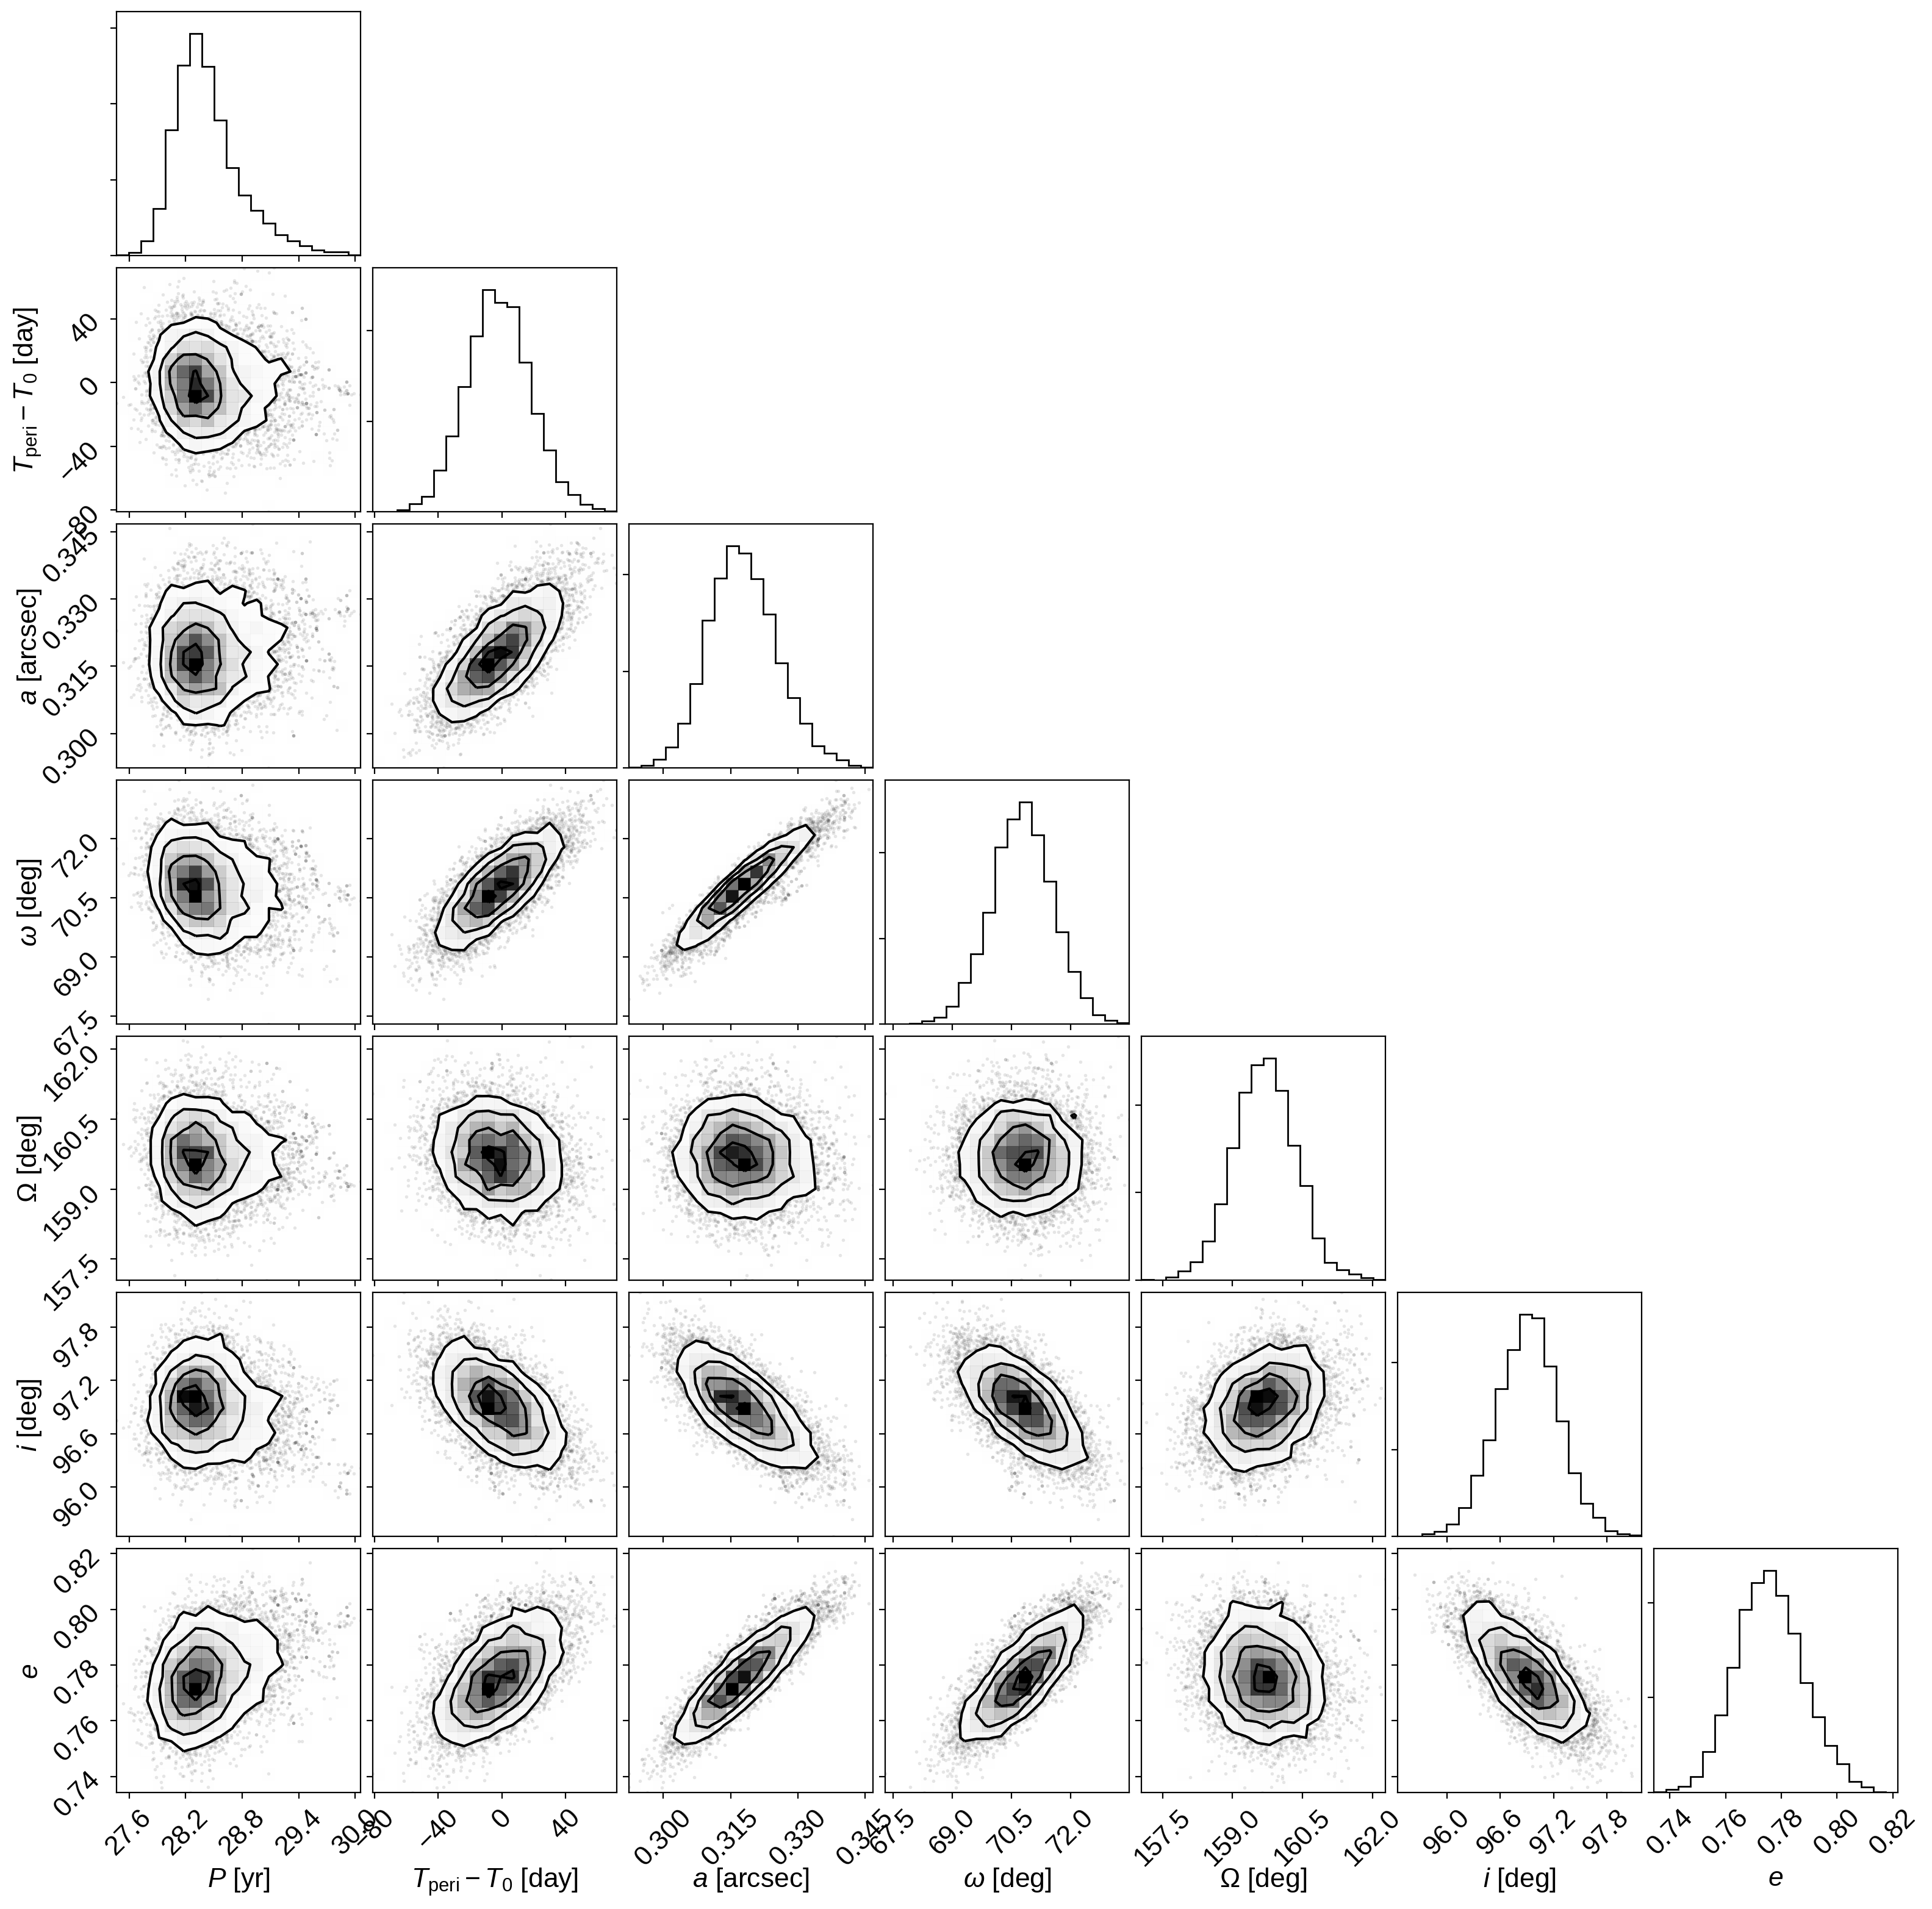

In [12]:
import corner

samples = pm.trace_to_dataframe(trace, varnames=["ecc"])
samples["$P$ [yr]"] = trace["P"] / yr
samples["$T_\mathrm{peri} - T_0$ [day]"] = trace["tperi"] - T0
samples["$a$ [arcsec]"] = trace["a_ang"]
samples["$\omega$ [deg]"] = (trace["omega"] / deg) % 360
samples["$\Omega$ [deg]"] = (trace["Omega"] / deg) % 360
samples["$i$ [deg]"] = (trace["incl"] / deg) % 360
samples["$e$"] = samples["ecc"]
del samples["ecc"]
_ = corner.corner(samples)

Finally, we can plot the posterior constraints on $\rho$ and $\theta$.
This figure is much like the one for the MAP solution above, but this time the orange is a contour (not a line) showing the 68% credible region for the model.

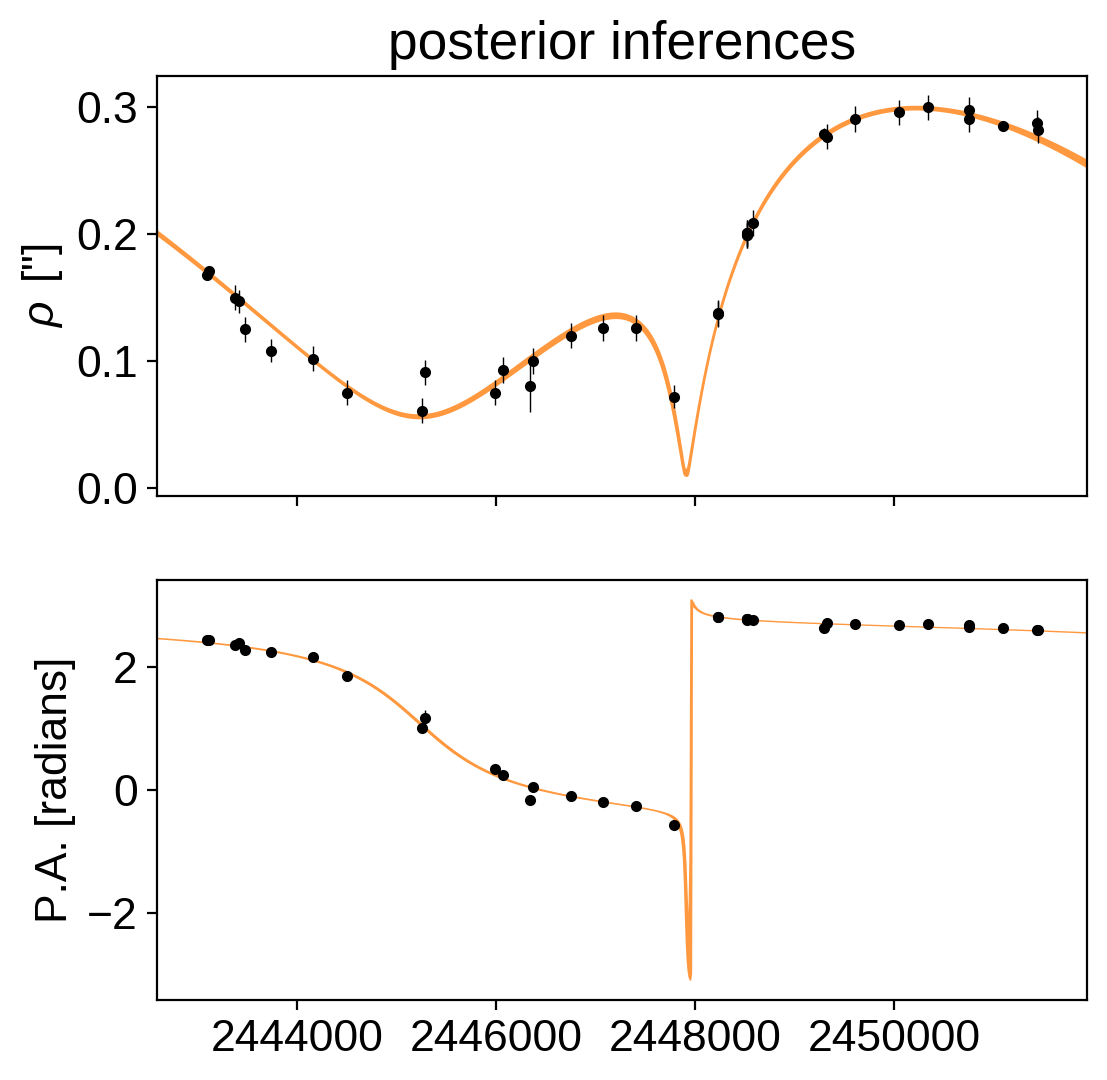

In [13]:
ekw = dict(fmt=".k", lw=0.5)

fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
ax[0].set_ylabel(r'$\rho\,$ ["]')
ax[1].set_ylabel(r"P.A. [radians]")

tot_rho_err = np.sqrt(
    rho_err ** 2 + np.exp(2 * np.median(trace["log_rho_s"], axis=0))
)
tot_theta_err = np.sqrt(
    theta_err ** 2 + np.exp(2 * np.median(trace["log_theta_s"], axis=0))
)

ax[0].errorbar(astro_jds, rho_data, yerr=tot_rho_err, **ekw)
q = np.percentile(trace["rho_save"], [16, 84], axis=0)
ax[0].fill_between(t_fine, q[0], q[1], color="C1", alpha=0.8, lw=0)

ax[1].errorbar(astro_jds, theta_data, yerr=tot_theta_err, **ekw)
q = np.percentile(trace["theta_save"], [16, 84], axis=0)
ax[1].fill_between(t_fine, q[0], q[1], color="C1", alpha=0.8, lw=0)

ax[-1].set_xlim(t_fine[0], t_fine[-1])
_ = ax[0].set_title("posterior inferences")

As we can see from the narrow range of orbits (the orange swath appears like a thin line), the orbit is actually highly constrained by the astrometry.
We also see two outlier epochs in the vicinity of 2445000 - 2447000, since adjacent epochs seem to be right on the orbit.
It's likely the uncertainties were not estimated correctly for these, and the simlplistic jitter model we implemented isn't sophisticated to apply more weight to only these discrepant points.

## Including parallax

While this is encouraging that we fit an astrometric orbit, a simple astrometric fit to just $\rho$ and $\theta$ isn't actually that physically satisfying, since many of the orbital parameters simply have to do with the orientation relative to us ($i$, $\omega$, and $\Omega$). The only truely intrinsic parameters are $P$ and $e$. To learn more about some of the physical parameters, such as the total mass of the system, we'd like to incorporate distance information to put a physical scale to the problem.

The *Gaia* DR2 parallax is $\varpi = 24.05 \pm 0.45$ mas.

We can use exactly the same model as above with only an added parallax constraint:

In [14]:
plx_model, plx_map_soln = get_model(parallax=[24.05, 0.45])

optimizing logp for variables: [log_theta_s, log_rho_s]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=1.076402e+02]

1it [00:00, 356.69it/s, logp=1.076402e+02]

2it [00:00, 441.62it/s, logp=1.476711e+02]

3it [00:00, 491.65it/s, logp=1.084303e+02]

4it [00:00, 548.47it/s, logp=1.485840e+02]

5it [00:00, 599.36it/s, logp=1.497845e+02]

6it [00:00, 645.54it/s, logp=1.499280e+02]

7it [00:00, 683.52it/s, logp=1.499286e+02]

8it [00:00, 683.43it/s, logp=1.499286e+02]

9it [00:00, 711.58it/s, logp=1.499286e+02]

10it [00:01,  6.39it/s, logp=1.499286e+02]


message: Optimization terminated successfully.
logp: 107.64015029566296 -> 149.92860106267193


optimizing logp for variables: [phase]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=1.499286e+02]

1it [00:00, 571.82it/s, logp=1.499286e+02]

2it [00:00, 711.50it/s, logp=-1.185553e+04]

3it [00:00, 805.41it/s, logp=1.499517e+02] 

4it [00:00, 868.66it/s, logp=1.499982e+02]

5it [00:00, 935.35it/s, logp=1.501832e+02]

6it [00:00, 976.56it/s, logp=1.509035e+02]

7it [00:00, 1005.41it/s, logp=1.535077e+02]

8it [00:00, 940.69it/s, logp=1.593811e+02] 

9it [00:00, 958.36it/s, logp=1.662757e+02]

10it [00:00, 947.74it/s, logp=1.694242e+02]

11it [00:00, 950.83it/s, logp=1.703302e+02]

12it [00:00, 958.53it/s, logp=1.704061e+02]

13it [00:00, 971.70it/s, logp=1.704094e+02]

14it [00:00, 984.00it/s, logp=1.704128e+02]

15it [00:00, 992.69it/s, logp=1.704184e+02]

16it [00:00, 974.70it/s, logp=1.704249e+02]

17it [00:00, 979.09it/s, logp=1.704265e+02]

18it [00:00, 974.73it/s, logp=1.704268e+02]

19it [00:00, 981.69it/s, logp=1.704268e+02]

20it [00:00, 990.85it/s, logp=1.704268e+02]

21it [00:00, 999.15it/s, logp=1.704268e+02]

22it [00:00, 27.43it/s, logp=1.704268e+02] 


message: Optimization terminated successfully.
logp: 149.92860106267193 -> 170.4268151845905


optimizing logp for variables: [ecc, m, p]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=1.704268e+02]

1it [00:00, 459.85it/s, logp=1.704268e+02]

2it [00:00, 553.85it/s, logp=-4.518236e+03]

3it [00:00, 639.60it/s, logp=1.710200e+02] 

4it [00:00, 680.70it/s, logp=1.695336e+02]

5it [00:00, 726.94it/s, logp=1.711520e+02]

6it [00:00, 756.96it/s, logp=1.714066e+02]

7it [00:00, 789.72it/s, logp=1.721879e+02]

8it [00:00, 796.39it/s, logp=1.742150e+02]

9it [00:00, 822.81it/s, logp=1.812157e+02]

10it [00:00, 839.36it/s, logp=1.949820e+02]

11it [00:00, 828.30it/s, logp=1.964691e+02]

12it [00:00, 839.46it/s, logp=1.992100e+02]

13it [00:00, 848.16it/s, logp=2.038785e+02]

14it [00:00, 856.19it/s, logp=2.102587e+02]

15it [00:00, 805.94it/s, logp=2.122110e+02]

16it [00:00, 815.36it/s, logp=2.126408e+02]

17it [00:00, 768.01it/s, logp=2.126846e+02]

18it [00:00, 772.90it/s, logp=2.126998e+02]

19it [00:00, 774.56it/s, logp=2.127263e+02]

20it [00:00, 782.58it/s, logp=2.127699e+02]

21it [00:00, 789.70it/s, logp=2.128244e+02]

22it [00:00, 795.98it/s, logp=2.128398e+02]

23it [00:00, 739.13it/s, logp=2.128456e+02]

24it [00:00, 743.71it/s, logp=2.128460e+02]

25it [00:00, 750.74it/s, logp=2.128463e+02]

26it [00:00, 737.45it/s, logp=2.128468e+02]

27it [00:00, 729.78it/s, logp=2.128475e+02]

28it [00:00, 735.11it/s, logp=2.128479e+02]

29it [00:00, 733.34it/s, logp=2.128480e+02]

30it [00:00, 736.41it/s, logp=2.128480e+02]

31it [00:00, 740.73it/s, logp=2.128480e+02]

32it [00:00, 743.06it/s, logp=2.128480e+02]

33it [00:00, 743.01it/s, logp=2.128480e+02]

34it [00:00, 40.69it/s, logp=2.128480e+02] 


message: Optimization terminated successfully.
logp: 170.42681518459054 -> 212.8480158855976


optimizing logp for variables: [phase, a_ang, logP]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=2.128480e+02]

1it [00:00, 456.25it/s, logp=2.128480e+02]

2it [00:00, 532.64it/s, logp=-4.375386e+03]

3it [00:00, 635.98it/s, logp=2.129960e+02] 

4it [00:00, 657.36it/s, logp=2.131453e+02]

5it [00:00, 703.44it/s, logp=2.132729e+02]

6it [00:00, 742.09it/s, logp=2.132857e+02]

7it [00:00, 777.15it/s, logp=2.132857e+02]

8it [00:00, 813.36it/s, logp=2.132860e+02]

9it [00:00, 835.65it/s, logp=2.132860e+02]

10it [00:00, 820.34it/s, logp=2.132860e+02]

11it [00:00, 13.68it/s, logp=2.132860e+02] 


message: Optimization terminated successfully.
logp: 212.8480158855976 -> 213.28597909410882


optimizing logp for variables: [log_theta_s, log_rho_s, ecc, cos_incl, phase, m, p, logP, a_ang, m_plx]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=2.132860e+02]

1it [00:00, 435.64it/s, logp=2.132860e+02]

2it [00:00, 547.38it/s, logp=-4.038433e+03]

3it [00:00, 651.09it/s, logp=2.152474e+02] 

4it [00:00, 692.96it/s, logp=1.676432e+02]

5it [00:00, 729.34it/s, logp=2.153207e+02]

6it [00:00, 694.15it/s, logp=2.154316e+02]

7it [00:00, 703.07it/s, logp=2.156115e+02]

8it [00:00, 701.68it/s, logp=2.158705e+02]

9it [00:00, 712.40it/s, logp=2.160160e+02]

10it [00:00, 726.88it/s, logp=2.158620e+02]

11it [00:00, 746.00it/s, logp=2.160652e+02]

12it [00:00, 752.04it/s, logp=2.160890e+02]

13it [00:00, 747.70it/s, logp=2.161353e+02]

14it [00:00, 754.68it/s, logp=2.162848e+02]

15it [00:00, 759.65it/s, logp=2.166196e+02]

16it [00:00, 767.15it/s, logp=2.171740e+02]

17it [00:00, 774.08it/s, logp=2.175761e+02]

18it [00:00, 766.15it/s, logp=2.174845e+02]

19it [00:00, 775.78it/s, logp=2.176565e+02]

20it [00:00, 776.61it/s, logp=2.177043e+02]

21it [00:00, 772.02it/s, logp=2.177335e+02]

22it [00:00, 772.69it/s, logp=2.177622e+02]

23it [00:00, 776.99it/s, logp=2.177547e+02]

24it [00:00, 784.69it/s, logp=2.177767e+02]

25it [00:00, 785.28it/s, logp=2.177873e+02]

26it [00:00, 787.34it/s, logp=2.177936e+02]

27it [00:00, 784.86it/s, logp=2.178014e+02]

28it [00:00, 784.26it/s, logp=2.178034e+02]

29it [00:00, 788.16it/s, logp=2.178054e+02]

30it [00:00, 786.83it/s, logp=2.178058e+02]

31it [00:00, 785.19it/s, logp=2.178059e+02]

32it [00:00, 776.94it/s, logp=2.178059e+02]

33it [00:00, 780.00it/s, logp=2.178059e+02]

34it [00:00, 780.43it/s, logp=2.178059e+02]

35it [00:00, 784.78it/s, logp=2.178059e+02]

36it [00:00, 781.71it/s, logp=2.178059e+02]

37it [00:00, 783.00it/s, logp=2.178059e+02]

38it [00:00, 785.35it/s, logp=2.178059e+02]

39it [00:00, 790.90it/s, logp=2.178059e+02]

40it [00:00, 795.72it/s, logp=2.178059e+02]

41it [00:00, 800.08it/s, logp=2.178059e+02]

42it [00:00, 798.82it/s, logp=2.178059e+02]

43it [00:00, 800.10it/s, logp=2.178059e+02]

44it [00:00, 804.87it/s, logp=2.178059e+02]

45it [00:00, 809.73it/s, logp=2.178059e+02]

46it [00:00, 812.93it/s, logp=2.178059e+02]

47it [00:00, 816.80it/s, logp=2.178059e+02]

48it [00:00, 819.70it/s, logp=2.178059e+02]

49it [00:00, 823.82it/s, logp=2.178059e+02]

50it [00:00, 826.72it/s, logp=2.178059e+02]

51it [00:00, 829.39it/s, logp=2.178059e+02]

52it [00:00, 824.29it/s, logp=2.178059e+02]

53it [00:00, 828.46it/s, logp=2.178059e+02]

54it [00:00, 830.85it/s, logp=2.178059e+02]

55it [00:00, 826.24it/s, logp=2.178059e+02]

56it [00:00, 829.20it/s, logp=2.178059e+02]

57it [00:00, 829.19it/s, logp=2.178059e+02]

58it [00:00, 829.57it/s, logp=2.178059e+02]

59it [00:00, 828.44it/s, logp=2.178059e+02]

60it [00:00, 830.31it/s, logp=2.178059e+02]

61it [00:00, 832.28it/s, logp=2.178059e+02]

62it [00:00, 835.51it/s, logp=2.178059e+02]

63it [00:00, 837.69it/s, logp=2.178059e+02]

64it [00:00, 841.07it/s, logp=2.178059e+02]

65it [00:00, 841.38it/s, logp=2.178059e+02]

66it [00:00, 844.47it/s, logp=2.178059e+02]

67it [00:00, 846.27it/s, logp=2.178059e+02]

68it [00:00, 848.32it/s, logp=2.178059e+02]

69it [00:00, 849.97it/s, logp=2.178059e+02]

70it [00:00, 851.67it/s, logp=2.178059e+02]

71it [00:00, 853.36it/s, logp=2.178059e+02]

72it [00:00, 854.78it/s, logp=2.178059e+02]

73it [00:00, 855.89it/s, logp=2.178059e+02]

74it [00:00, 858.69it/s, logp=2.178059e+02]

75it [00:00, 853.98it/s, logp=2.178059e+02]

76it [00:00, 853.14it/s, logp=2.178059e+02]

77it [00:00, 847.31it/s, logp=2.178059e+02]

78it [00:00, 848.93it/s, logp=2.178059e+02]

79it [00:00, 850.69it/s, logp=2.178059e+02]

80it [00:00, 852.66it/s, logp=2.178059e+02]

81it [00:00, 854.14it/s, logp=2.178059e+02]

82it [00:00, 851.52it/s, logp=2.178059e+02]

83it [00:00, 852.20it/s, logp=2.178059e+02]

84it [00:00, 852.82it/s, logp=2.178059e+02]

85it [00:00, 854.62it/s, logp=2.178059e+02]

86it [00:00, 859.40it/s, logp=2.178059e+02]

86it [00:00, 859.40it/s, logp=2.178059e+02]

87it [00:00, 859.40it/s, logp=2.178059e+02]

88it [00:00, 859.40it/s, logp=2.178059e+02]

89it [00:00, 859.40it/s, logp=2.178059e+02]

90it [00:00, 859.40it/s, logp=2.178059e+02]

91it [00:00, 859.40it/s, logp=2.178059e+02]

92it [00:00, 859.40it/s, logp=2.178059e+02]

93it [00:00, 859.40it/s, logp=2.178059e+02]

94it [00:00, 859.40it/s, logp=2.178059e+02]

95it [00:00, 859.40it/s, logp=2.178059e+02]

96it [00:00, 859.40it/s, logp=2.178059e+02]

97it [00:00, 859.40it/s, logp=2.178059e+02]

98it [00:00, 859.40it/s, logp=2.178059e+02]

99it [00:00, 859.40it/s, logp=2.178059e+02]

100it [00:00, 859.40it/s, logp=2.178059e+02]

101it [00:00, 859.40it/s, logp=2.178059e+02]

102it [00:00, 859.40it/s, logp=2.178059e+02]

103it [00:00, 859.40it/s, logp=2.178059e+02]

104it [00:00, 859.40it/s, logp=2.178059e+02]

105it [00:00, 859.40it/s, logp=2.178059e+02]

106it [00:00, 859.40it/s, logp=2.178059e+02]

107it [00:00, 859.40it/s, logp=2.178059e+02]

108it [00:00, 859.40it/s, logp=2.178059e+02]

109it [00:00, 859.40it/s, logp=2.178059e+02]

110it [00:00, 859.40it/s, logp=2.178059e+02]

111it [00:00, 859.40it/s, logp=2.178059e+02]

112it [00:00, 859.40it/s, logp=2.178059e+02]

113it [00:00, 859.40it/s, logp=2.178059e+02]

114it [00:00, 126.61it/s, logp=2.178059e+02]


message: Desired error not necessarily achieved due to precision loss.
logp: 213.28597909410882 -> 217.8058683350306


In [15]:
np.random.seed(5432)
with plx_model:
    plx_trace = pm.sample(
        tune=5000,
        draws=4000,
        start=plx_map_soln,
        cores=2,
        chains=2,
        step=xo.get_dense_nuts_step(target_accept=0.9, start=plx_map_soln),
    )

Multiprocess sampling (2 chains in 2 jobs)


NUTS: [log_theta_s, log_rho_s, ecc, cos_incl, phase, m, p, logP, a_ang, m_plx]


Sampling 2 chains, 0 divergences:   0%|          | 0/18000 [00:00<?, ?draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 7/18000 [00:00<05:17, 56.58draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 9/18000 [00:00<08:42, 34.45draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 11/18000 [00:00<11:03, 27.13draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 13/18000 [00:00<12:44, 23.53draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 15/18000 [00:00<13:43, 21.85draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 17/18000 [00:00<14:43, 20.35draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 19/18000 [00:00<15:28, 19.37draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 21/18000 [00:00<15:39, 19.13draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 23/18000 [00:01<15:42, 19.07draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 25/18000 [00:01<15:45, 19.01draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 27/18000 [00:01<15:55, 18.80draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 29/18000 [00:01<16:03, 18.64draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 32/18000 [00:01<15:52, 18.86draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 34/18000 [00:01<16:13, 18.46draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 36/18000 [00:01<16:29, 18.16draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 38/18000 [00:01<16:38, 17.98draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 42/18000 [00:01<14:14, 21.03draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 45/18000 [00:02<14:49, 20.18draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 48/18000 [00:02<15:41, 19.06draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 53/18000 [00:02<13:33, 22.07draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 57/18000 [00:02<13:14, 22.59draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 60/18000 [00:02<12:42, 23.53draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 63/18000 [00:02<12:21, 24.18draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 66/18000 [00:03<14:44, 20.28draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 69/18000 [00:03<14:41, 20.33draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 72/18000 [00:03<15:13, 19.62draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 75/18000 [00:03<14:12, 21.02draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 78/18000 [00:03<16:21, 18.26draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 80/18000 [00:03<16:16, 18.35draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 82/18000 [00:03<16:13, 18.40draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 85/18000 [00:04<14:54, 20.02draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 88/18000 [00:04<15:20, 19.45draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 91/18000 [00:04<14:37, 20.40draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 94/18000 [00:04<14:33, 20.51draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 97/18000 [00:04<14:58, 19.93draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 100/18000 [00:04<15:03, 19.81draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 103/18000 [00:04<15:43, 18.96draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 106/18000 [00:05<15:11, 19.63draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 109/18000 [00:05<13:57, 21.37draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 112/18000 [00:05<14:10, 21.04draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 116/18000 [00:05<12:33, 23.75draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 119/18000 [00:05<13:02, 22.86draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 122/18000 [00:05<13:13, 22.52draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 125/18000 [00:05<13:23, 22.25draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 128/18000 [00:06<14:39, 20.32draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 131/18000 [00:06<13:50, 21.52draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 134/18000 [00:06<13:48, 21.56draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 137/18000 [00:06<13:09, 22.62draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 140/18000 [00:06<12:21, 24.09draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 143/18000 [00:06<13:26, 22.15draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 146/18000 [00:06<12:39, 23.52draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 149/18000 [00:06<12:52, 23.11draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 152/18000 [00:07<12:33, 23.68draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 155/18000 [00:07<13:05, 22.73draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 158/18000 [00:07<12:28, 23.82draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 161/18000 [00:07<11:57, 24.85draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 165/18000 [00:07<11:58, 24.83draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 168/18000 [00:07<12:18, 24.13draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 171/18000 [00:07<12:25, 23.93draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 174/18000 [00:07<13:02, 22.79draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 177/18000 [00:08<14:36, 20.34draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 180/18000 [00:08<14:32, 20.42draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 184/18000 [00:08<12:55, 22.96draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 187/18000 [00:08<12:17, 24.16draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 190/18000 [00:08<14:25, 20.58draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 193/18000 [00:08<13:41, 21.66draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 196/18000 [00:09<14:09, 20.96draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 199/18000 [00:09<16:03, 18.48draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 201/18000 [00:09<16:15, 18.25draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 204/18000 [00:09<14:38, 20.26draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 207/18000 [00:09<15:32, 19.09draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 210/18000 [00:09<14:24, 20.57draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 213/18000 [00:09<15:22, 19.28draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 216/18000 [00:10<14:13, 20.83draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 223/18000 [00:10<11:16, 26.28draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 233/18000 [00:10<08:48, 33.64draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 244/18000 [00:10<06:58, 42.46draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 261/18000 [00:10<05:24, 54.61draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 284/18000 [00:10<04:10, 70.69draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 308/18000 [00:10<03:17, 89.52draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 328/18000 [00:10<02:45, 106.98draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 352/18000 [00:10<02:17, 128.03draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 373/18000 [00:10<02:05, 140.94draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 393/18000 [00:11<01:53, 154.61draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 419/18000 [00:11<01:40, 174.42draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 441/18000 [00:11<01:38, 178.31draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 466/18000 [00:11<01:31, 192.54draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 488/18000 [00:11<01:29, 194.93draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 513/18000 [00:11<01:23, 208.33draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 536/18000 [00:11<01:31, 189.99draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 557/18000 [00:11<01:40, 172.89draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 576/18000 [00:12<01:52, 154.40draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 596/18000 [00:12<01:45, 165.73draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 620/18000 [00:12<01:35, 182.33draws/s]

Sampling 2 chains, 0 divergences:   4%|▎         | 640/18000 [00:12<01:39, 174.61draws/s]

Sampling 2 chains, 0 divergences:   4%|▎         | 659/18000 [00:12<01:38, 175.72draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 678/18000 [00:12<01:38, 176.62draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 697/18000 [00:12<01:38, 175.27draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 716/18000 [00:12<01:38, 176.06draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 737/18000 [00:12<01:33, 183.74draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 756/18000 [00:13<01:37, 177.31draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 774/18000 [00:13<01:40, 171.65draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 792/18000 [00:13<01:42, 168.28draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 809/18000 [00:13<01:42, 167.27draws/s]

Sampling 2 chains, 0 divergences:   5%|▍         | 832/18000 [00:13<01:34, 181.86draws/s]

Sampling 2 chains, 0 divergences:   5%|▍         | 851/18000 [00:13<01:35, 179.86draws/s]

Sampling 2 chains, 0 divergences:   5%|▍         | 871/18000 [00:13<01:33, 183.44draws/s]

Sampling 2 chains, 0 divergences:   5%|▍         | 893/18000 [00:13<01:28, 192.76draws/s]

Sampling 2 chains, 0 divergences:   5%|▌         | 913/18000 [00:13<01:36, 177.64draws/s]

Sampling 2 chains, 0 divergences:   5%|▌         | 933/18000 [00:14<01:32, 183.53draws/s]

Sampling 2 chains, 0 divergences:   5%|▌         | 952/18000 [00:14<01:37, 174.16draws/s]

Sampling 2 chains, 0 divergences:   5%|▌         | 970/18000 [00:14<01:41, 168.22draws/s]

Sampling 2 chains, 0 divergences:   5%|▌         | 988/18000 [00:14<01:40, 169.79draws/s]

Sampling 2 chains, 0 divergences:   6%|▌         | 1008/18000 [00:14<01:37, 174.36draws/s]

Sampling 2 chains, 0 divergences:   6%|▌         | 1026/18000 [00:14<01:40, 169.62draws/s]

Sampling 2 chains, 0 divergences:   6%|▌         | 1045/18000 [00:14<01:36, 174.91draws/s]

Sampling 2 chains, 0 divergences:   6%|▌         | 1069/18000 [00:14<01:30, 187.39draws/s]

Sampling 2 chains, 0 divergences:   6%|▌         | 1089/18000 [00:14<01:34, 178.51draws/s]

Sampling 2 chains, 0 divergences:   6%|▌         | 1108/18000 [00:15<01:36, 175.18draws/s]

Sampling 2 chains, 0 divergences:   6%|▋         | 1126/18000 [00:15<01:35, 175.80draws/s]

Sampling 2 chains, 0 divergences:   6%|▋         | 1144/18000 [00:15<01:35, 176.19draws/s]

Sampling 2 chains, 0 divergences:   6%|▋         | 1162/18000 [00:15<01:38, 171.20draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 1183/18000 [00:15<01:34, 178.45draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 1202/18000 [00:15<01:38, 170.49draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 1220/18000 [00:15<01:42, 164.01draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 1237/18000 [00:15<01:46, 157.08draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 1257/18000 [00:15<01:41, 165.08draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 1277/18000 [00:16<01:36, 173.50draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 1296/18000 [00:16<01:36, 173.52draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 1314/18000 [00:16<01:37, 170.35draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 1339/18000 [00:16<01:28, 188.17draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 1360/18000 [00:16<01:25, 193.84draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 1380/18000 [00:16<01:36, 172.68draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 1399/18000 [00:16<01:44, 159.57draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 1416/18000 [00:16<01:50, 150.37draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 1432/18000 [00:16<01:55, 143.81draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 1455/18000 [00:17<01:43, 160.29draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 1475/18000 [00:17<01:38, 167.40draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 1499/18000 [00:17<01:30, 181.80draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 1519/18000 [00:17<01:29, 183.76draws/s]

Sampling 2 chains, 0 divergences:   9%|▊         | 1539/18000 [00:17<01:29, 184.37draws/s]

Sampling 2 chains, 0 divergences:   9%|▊         | 1558/18000 [00:17<01:31, 179.55draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 1578/18000 [00:17<01:30, 181.72draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 1598/18000 [00:17<01:29, 183.41draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 1619/18000 [00:17<01:26, 189.85draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 1641/18000 [00:18<01:23, 195.92draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 1662/18000 [00:18<01:23, 196.16draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 1682/18000 [00:18<01:34, 173.16draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 1700/18000 [00:18<01:39, 163.22draws/s]

Sampling 2 chains, 0 divergences:  10%|▉         | 1719/18000 [00:18<01:35, 170.39draws/s]

Sampling 2 chains, 0 divergences:  10%|▉         | 1740/18000 [00:18<01:30, 180.47draws/s]

Sampling 2 chains, 0 divergences:  10%|▉         | 1760/18000 [00:18<01:27, 185.88draws/s]

Sampling 2 chains, 0 divergences:  10%|▉         | 1782/18000 [00:18<01:23, 194.15draws/s]

Sampling 2 chains, 0 divergences:  10%|█         | 1807/18000 [00:18<01:18, 206.43draws/s]

Sampling 2 chains, 0 divergences:  10%|█         | 1829/18000 [00:19<01:20, 199.82draws/s]

Sampling 2 chains, 0 divergences:  10%|█         | 1851/18000 [00:19<01:20, 200.94draws/s]

Sampling 2 chains, 0 divergences:  10%|█         | 1872/18000 [00:19<01:21, 198.45draws/s]

Sampling 2 chains, 0 divergences:  11%|█         | 1893/18000 [00:19<01:23, 192.28draws/s]

Sampling 2 chains, 0 divergences:  11%|█         | 1913/18000 [00:19<01:23, 193.42draws/s]

Sampling 2 chains, 0 divergences:  11%|█         | 1933/18000 [00:19<01:29, 178.83draws/s]

Sampling 2 chains, 0 divergences:  11%|█         | 1952/18000 [00:19<01:36, 165.77draws/s]

Sampling 2 chains, 0 divergences:  11%|█         | 1971/18000 [00:19<01:33, 171.63draws/s]

Sampling 2 chains, 0 divergences:  11%|█         | 1989/18000 [00:19<01:38, 162.77draws/s]

Sampling 2 chains, 0 divergences:  11%|█         | 2006/18000 [00:20<01:42, 156.38draws/s]

Sampling 2 chains, 0 divergences:  11%|█         | 2023/18000 [00:20<01:41, 157.41draws/s]

Sampling 2 chains, 0 divergences:  11%|█▏        | 2039/18000 [00:20<01:41, 157.54draws/s]

Sampling 2 chains, 0 divergences:  11%|█▏        | 2057/18000 [00:20<01:40, 159.25draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 2078/18000 [00:20<01:32, 171.29draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 2100/18000 [00:20<01:27, 182.23draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 2119/18000 [00:20<01:28, 179.69draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 2138/18000 [00:20<01:27, 181.53draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 2157/18000 [00:20<01:32, 170.75draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 2175/18000 [00:21<01:32, 170.25draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 2193/18000 [00:21<01:36, 163.29draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 2210/18000 [00:21<01:37, 161.49draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 2235/18000 [00:21<01:27, 180.22draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 2260/18000 [00:21<01:20, 196.40draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 2283/18000 [00:21<01:16, 205.24draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 2305/18000 [00:21<01:16, 206.42draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 2327/18000 [00:21<01:21, 192.66draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 2347/18000 [00:21<01:29, 175.35draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 2366/18000 [00:22<01:34, 164.58draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 2384/18000 [00:22<01:43, 151.49draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 2400/18000 [00:22<01:45, 147.82draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 2416/18000 [00:22<01:44, 148.83draws/s]

Sampling 2 chains, 0 divergences:  14%|█▎        | 2433/18000 [00:22<01:41, 152.75draws/s]

Sampling 2 chains, 0 divergences:  14%|█▎        | 2450/18000 [00:22<01:38, 157.48draws/s]

Sampling 2 chains, 0 divergences:  14%|█▎        | 2470/18000 [00:22<01:34, 165.10draws/s]

Sampling 2 chains, 0 divergences:  14%|█▍        | 2487/18000 [00:22<01:34, 164.77draws/s]

Sampling 2 chains, 0 divergences:  14%|█▍        | 2504/18000 [00:22<01:33, 165.41draws/s]

Sampling 2 chains, 0 divergences:  14%|█▍        | 2523/18000 [00:23<01:30, 170.56draws/s]

Sampling 2 chains, 0 divergences:  14%|█▍        | 2545/18000 [00:23<01:25, 181.26draws/s]

Sampling 2 chains, 0 divergences:  14%|█▍        | 2566/18000 [00:23<01:22, 187.59draws/s]

Sampling 2 chains, 0 divergences:  14%|█▍        | 2590/18000 [00:23<01:17, 198.84draws/s]

Sampling 2 chains, 0 divergences:  15%|█▍        | 2611/18000 [00:23<01:18, 196.85draws/s]

Sampling 2 chains, 0 divergences:  15%|█▍        | 2631/18000 [00:23<01:17, 197.32draws/s]

Sampling 2 chains, 0 divergences:  15%|█▍        | 2651/18000 [00:23<01:18, 196.44draws/s]

Sampling 2 chains, 0 divergences:  15%|█▍        | 2671/18000 [00:23<01:24, 180.97draws/s]

Sampling 2 chains, 0 divergences:  15%|█▍        | 2691/18000 [00:23<01:23, 182.51draws/s]

Sampling 2 chains, 0 divergences:  15%|█▌        | 2711/18000 [00:24<01:22, 184.77draws/s]

Sampling 2 chains, 0 divergences:  15%|█▌        | 2730/18000 [00:24<01:26, 177.49draws/s]

Sampling 2 chains, 0 divergences:  15%|█▌        | 2748/18000 [00:24<01:26, 175.62draws/s]

Sampling 2 chains, 0 divergences:  15%|█▌        | 2766/18000 [00:24<01:32, 164.54draws/s]

Sampling 2 chains, 0 divergences:  15%|█▌        | 2786/18000 [00:24<01:28, 172.81draws/s]

Sampling 2 chains, 0 divergences:  16%|█▌        | 2804/18000 [00:24<01:33, 161.93draws/s]

Sampling 2 chains, 0 divergences:  16%|█▌        | 2823/18000 [00:24<01:31, 165.69draws/s]

Sampling 2 chains, 0 divergences:  16%|█▌        | 2840/18000 [00:24<01:40, 151.09draws/s]

Sampling 2 chains, 0 divergences:  16%|█▌        | 2856/18000 [00:24<01:45, 143.73draws/s]

Sampling 2 chains, 0 divergences:  16%|█▌        | 2875/18000 [00:25<01:40, 150.93draws/s]

Sampling 2 chains, 0 divergences:  16%|█▌        | 2893/18000 [00:25<01:37, 155.73draws/s]

Sampling 2 chains, 0 divergences:  16%|█▌        | 2915/18000 [00:25<01:29, 169.23draws/s]

Sampling 2 chains, 0 divergences:  16%|█▋        | 2933/18000 [00:25<01:29, 168.44draws/s]

Sampling 2 chains, 0 divergences:  16%|█▋        | 2951/18000 [00:25<01:38, 153.26draws/s]

Sampling 2 chains, 0 divergences:  16%|█▋        | 2967/18000 [00:25<01:41, 148.10draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 2984/18000 [00:25<01:37, 154.01draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 3004/18000 [00:25<01:31, 163.46draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 3026/18000 [00:25<01:25, 175.30draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 3046/18000 [00:26<01:22, 181.72draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 3065/18000 [00:26<01:22, 180.45draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 3088/18000 [00:26<01:17, 191.64draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 3114/18000 [00:26<01:11, 207.90draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 3136/18000 [00:26<01:10, 211.35draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 3158/18000 [00:26<01:11, 207.40draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 3180/18000 [00:26<01:14, 197.93draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 3201/18000 [00:26<01:13, 200.06draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 3222/18000 [00:26<01:17, 191.45draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 3243/18000 [00:27<01:15, 195.19draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 3263/18000 [00:27<01:15, 196.45draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 3283/18000 [00:27<01:14, 197.39draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 3303/18000 [00:27<01:16, 191.58draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 3328/18000 [00:27<01:11, 205.91draws/s]

Sampling 2 chains, 0 divergences:  19%|█▊        | 3349/18000 [00:27<01:17, 188.37draws/s]

Sampling 2 chains, 0 divergences:  19%|█▊        | 3369/18000 [00:27<01:23, 175.57draws/s]

Sampling 2 chains, 0 divergences:  19%|█▉        | 3388/18000 [00:27<01:25, 170.14draws/s]

Sampling 2 chains, 0 divergences:  19%|█▉        | 3406/18000 [00:27<01:27, 165.91draws/s]

Sampling 2 chains, 0 divergences:  19%|█▉        | 3426/18000 [00:28<01:24, 171.92draws/s]

Sampling 2 chains, 0 divergences:  19%|█▉        | 3445/18000 [00:28<01:23, 173.71draws/s]

Sampling 2 chains, 0 divergences:  19%|█▉        | 3463/18000 [00:28<01:23, 175.13draws/s]

Sampling 2 chains, 0 divergences:  19%|█▉        | 3483/18000 [00:28<01:20, 181.36draws/s]

Sampling 2 chains, 0 divergences:  19%|█▉        | 3504/18000 [00:28<01:18, 185.26draws/s]

Sampling 2 chains, 0 divergences:  20%|█▉        | 3525/18000 [00:28<01:15, 191.74draws/s]

Sampling 2 chains, 0 divergences:  20%|█▉        | 3545/18000 [00:28<01:19, 181.37draws/s]

Sampling 2 chains, 0 divergences:  20%|█▉        | 3564/18000 [00:28<01:28, 162.51draws/s]

Sampling 2 chains, 0 divergences:  20%|█▉        | 3586/18000 [00:28<01:22, 173.92draws/s]

Sampling 2 chains, 0 divergences:  20%|██        | 3607/18000 [00:29<01:19, 181.87draws/s]

Sampling 2 chains, 0 divergences:  20%|██        | 3627/18000 [00:29<01:17, 186.18draws/s]

Sampling 2 chains, 0 divergences:  20%|██        | 3646/18000 [00:29<01:16, 186.92draws/s]

Sampling 2 chains, 0 divergences:  20%|██        | 3666/18000 [00:29<01:15, 190.14draws/s]

Sampling 2 chains, 0 divergences:  20%|██        | 3686/18000 [00:29<01:24, 169.23draws/s]

Sampling 2 chains, 0 divergences:  21%|██        | 3704/18000 [00:29<01:27, 163.21draws/s]

Sampling 2 chains, 0 divergences:  21%|██        | 3721/18000 [00:29<01:28, 161.51draws/s]

Sampling 2 chains, 0 divergences:  21%|██        | 3740/18000 [00:29<01:25, 167.58draws/s]

Sampling 2 chains, 0 divergences:  21%|██        | 3758/18000 [00:29<01:27, 163.10draws/s]

Sampling 2 chains, 0 divergences:  21%|██        | 3775/18000 [00:30<01:33, 152.22draws/s]

Sampling 2 chains, 0 divergences:  21%|██        | 3791/18000 [00:30<01:32, 152.91draws/s]

Sampling 2 chains, 0 divergences:  21%|██        | 3810/18000 [00:30<01:28, 160.56draws/s]

Sampling 2 chains, 0 divergences:  21%|██▏       | 3829/18000 [00:30<01:24, 168.32draws/s]

Sampling 2 chains, 0 divergences:  21%|██▏       | 3847/18000 [00:30<01:24, 166.77draws/s]

Sampling 2 chains, 0 divergences:  21%|██▏       | 3865/18000 [00:30<01:23, 168.33draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 3882/18000 [00:30<01:27, 160.79draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 3899/18000 [00:30<01:31, 154.88draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 3915/18000 [00:30<01:35, 146.90draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 3930/18000 [00:31<01:35, 147.66draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 3950/18000 [00:31<01:27, 159.68draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 3969/18000 [00:31<01:24, 166.91draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 3991/18000 [00:31<01:18, 179.42draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 4012/18000 [00:31<01:15, 185.57draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 4032/18000 [00:31<01:13, 189.29draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 4056/18000 [00:31<01:09, 201.60draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 4077/18000 [00:31<01:08, 203.07draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 4098/18000 [00:31<01:08, 204.26draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 4119/18000 [00:31<01:10, 196.23draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 4144/18000 [00:32<01:06, 208.87draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 4169/18000 [00:32<01:03, 219.17draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 4192/18000 [00:32<01:05, 209.98draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 4214/18000 [00:32<01:06, 206.16draws/s]

Sampling 2 chains, 0 divergences:  24%|██▎       | 4235/18000 [00:32<01:10, 195.59draws/s]

Sampling 2 chains, 0 divergences:  24%|██▎       | 4255/18000 [00:32<01:17, 177.81draws/s]

Sampling 2 chains, 0 divergences:  24%|██▎       | 4274/18000 [00:32<01:22, 167.21draws/s]

Sampling 2 chains, 0 divergences:  24%|██▍       | 4292/18000 [00:32<01:21, 168.36draws/s]

Sampling 2 chains, 0 divergences:  24%|██▍       | 4316/18000 [00:33<01:15, 182.26draws/s]

Sampling 2 chains, 0 divergences:  24%|██▍       | 4337/18000 [00:33<01:12, 189.76draws/s]

Sampling 2 chains, 0 divergences:  24%|██▍       | 4360/18000 [00:33<01:08, 198.45draws/s]

Sampling 2 chains, 0 divergences:  24%|██▍       | 4383/18000 [00:33<01:05, 206.65draws/s]

Sampling 2 chains, 0 divergences:  24%|██▍       | 4405/18000 [00:33<01:05, 206.46draws/s]

Sampling 2 chains, 0 divergences:  25%|██▍       | 4426/18000 [00:33<01:07, 201.90draws/s]

Sampling 2 chains, 0 divergences:  25%|██▍       | 4448/18000 [00:33<01:06, 204.49draws/s]

Sampling 2 chains, 0 divergences:  25%|██▍       | 4469/18000 [00:33<01:09, 194.47draws/s]

Sampling 2 chains, 0 divergences:  25%|██▍       | 4489/18000 [00:33<01:14, 182.21draws/s]

Sampling 2 chains, 0 divergences:  25%|██▌       | 4508/18000 [00:34<01:14, 180.60draws/s]

Sampling 2 chains, 0 divergences:  25%|██▌       | 4527/18000 [00:34<01:16, 175.47draws/s]

Sampling 2 chains, 0 divergences:  25%|██▌       | 4549/18000 [00:34<01:12, 185.92draws/s]

Sampling 2 chains, 0 divergences:  25%|██▌       | 4571/18000 [00:34<01:09, 193.52draws/s]

Sampling 2 chains, 0 divergences:  26%|██▌       | 4592/18000 [00:34<01:08, 197.11draws/s]

Sampling 2 chains, 0 divergences:  26%|██▌       | 4612/18000 [00:34<01:10, 188.78draws/s]

Sampling 2 chains, 0 divergences:  26%|██▌       | 4632/18000 [00:34<01:17, 171.53draws/s]

Sampling 2 chains, 0 divergences:  26%|██▌       | 4650/18000 [00:34<01:21, 164.18draws/s]

Sampling 2 chains, 0 divergences:  26%|██▌       | 4667/18000 [00:34<01:23, 159.75draws/s]

Sampling 2 chains, 0 divergences:  26%|██▌       | 4684/18000 [00:35<01:25, 155.77draws/s]

Sampling 2 chains, 0 divergences:  26%|██▌       | 4700/18000 [00:35<01:26, 153.38draws/s]

Sampling 2 chains, 0 divergences:  26%|██▌       | 4717/18000 [00:35<01:24, 157.34draws/s]

Sampling 2 chains, 0 divergences:  26%|██▋       | 4734/18000 [00:35<01:23, 158.13draws/s]

Sampling 2 chains, 0 divergences:  26%|██▋       | 4750/18000 [00:35<01:23, 157.81draws/s]

Sampling 2 chains, 0 divergences:  26%|██▋       | 4767/18000 [00:35<01:22, 160.63draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 4784/18000 [00:35<01:27, 150.47draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 4800/18000 [00:35<01:28, 149.78draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 4816/18000 [00:35<01:28, 149.14draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 4832/18000 [00:36<01:29, 146.75draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 4851/18000 [00:36<01:24, 155.84draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 4869/18000 [00:36<01:21, 161.90draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 4889/18000 [00:36<01:18, 167.55draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 4909/18000 [00:36<01:16, 172.08draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 4927/18000 [00:36<01:15, 172.38draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 4946/18000 [00:36<01:13, 177.17draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 4966/18000 [00:36<01:11, 183.11draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 4985/18000 [00:36<01:13, 176.15draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 5005/18000 [00:36<01:12, 179.49draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 5025/18000 [00:37<01:11, 181.32draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 5044/18000 [00:37<01:12, 177.50draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 5065/18000 [00:37<01:09, 185.69draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 5084/18000 [00:37<01:11, 179.53draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 5103/18000 [00:37<01:10, 182.10draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 5122/18000 [00:37<01:10, 183.07draws/s]

Sampling 2 chains, 0 divergences:  29%|██▊       | 5142/18000 [00:37<01:08, 187.52draws/s]

Sampling 2 chains, 0 divergences:  29%|██▊       | 5161/18000 [00:37<01:16, 167.63draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 5179/18000 [00:37<01:17, 166.16draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 5196/18000 [00:38<01:18, 163.07draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 5216/18000 [00:38<01:14, 171.44draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 5236/18000 [00:38<01:12, 176.41draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 5255/18000 [00:38<01:11, 179.17draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 5275/18000 [00:38<01:09, 184.03draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 5294/18000 [00:38<01:08, 184.16draws/s]

Sampling 2 chains, 0 divergences:  30%|██▉       | 5313/18000 [00:38<01:09, 183.11draws/s]

Sampling 2 chains, 0 divergences:  30%|██▉       | 5332/18000 [00:38<01:15, 168.57draws/s]

Sampling 2 chains, 0 divergences:  30%|██▉       | 5350/18000 [00:38<01:18, 160.80draws/s]

Sampling 2 chains, 0 divergences:  30%|██▉       | 5367/18000 [00:39<01:23, 151.02draws/s]

Sampling 2 chains, 0 divergences:  30%|██▉       | 5383/18000 [00:39<01:24, 150.08draws/s]

Sampling 2 chains, 0 divergences:  30%|██▉       | 5399/18000 [00:39<01:22, 152.26draws/s]

Sampling 2 chains, 0 divergences:  30%|███       | 5416/18000 [00:39<01:20, 157.08draws/s]

Sampling 2 chains, 0 divergences:  30%|███       | 5432/18000 [00:39<01:21, 154.31draws/s]

Sampling 2 chains, 0 divergences:  30%|███       | 5451/18000 [00:39<01:17, 161.36draws/s]

Sampling 2 chains, 0 divergences:  30%|███       | 5471/18000 [00:39<01:14, 169.27draws/s]

Sampling 2 chains, 0 divergences:  31%|███       | 5491/18000 [00:39<01:11, 173.84draws/s]

Sampling 2 chains, 0 divergences:  31%|███       | 5509/18000 [00:39<01:15, 166.19draws/s]

Sampling 2 chains, 0 divergences:  31%|███       | 5526/18000 [00:40<01:14, 166.74draws/s]

Sampling 2 chains, 0 divergences:  31%|███       | 5546/18000 [00:40<01:11, 175.36draws/s]

Sampling 2 chains, 0 divergences:  31%|███       | 5564/18000 [00:40<01:10, 175.27draws/s]

Sampling 2 chains, 0 divergences:  31%|███       | 5587/18000 [00:40<01:06, 185.73draws/s]

Sampling 2 chains, 0 divergences:  31%|███       | 5608/18000 [00:40<01:04, 191.05draws/s]

Sampling 2 chains, 0 divergences:  31%|███▏      | 5628/18000 [00:40<01:13, 168.15draws/s]

Sampling 2 chains, 0 divergences:  31%|███▏      | 5646/18000 [00:40<01:13, 167.81draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 5670/18000 [00:40<01:07, 182.86draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 5690/18000 [00:40<01:05, 187.60draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 5711/18000 [00:41<01:03, 192.54draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 5731/18000 [00:41<01:03, 194.24draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 5751/18000 [00:41<01:03, 191.96draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 5772/18000 [00:41<01:02, 196.17draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 5796/18000 [00:41<00:59, 206.17draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 5817/18000 [00:41<01:06, 184.58draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 5837/18000 [00:41<01:07, 180.02draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 5857/18000 [00:41<01:06, 183.62draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 5878/18000 [00:41<01:03, 189.73draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 5899/18000 [00:41<01:01, 195.27draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 5922/18000 [00:42<00:59, 203.78draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 5944/18000 [00:42<00:58, 206.66draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 5965/18000 [00:42<00:58, 206.00draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 5986/18000 [00:42<01:00, 200.20draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 6007/18000 [00:42<01:02, 190.56draws/s]

Sampling 2 chains, 0 divergences:  34%|███▎      | 6030/18000 [00:42<01:00, 196.54draws/s]

Sampling 2 chains, 0 divergences:  34%|███▎      | 6051/18000 [00:42<00:59, 199.53draws/s]

Sampling 2 chains, 0 divergences:  34%|███▎      | 6073/18000 [00:42<00:58, 204.23draws/s]

Sampling 2 chains, 0 divergences:  34%|███▍      | 6094/18000 [00:42<00:58, 204.76draws/s]

Sampling 2 chains, 0 divergences:  34%|███▍      | 6115/18000 [00:43<00:58, 201.59draws/s]

Sampling 2 chains, 0 divergences:  34%|███▍      | 6136/18000 [00:43<01:01, 191.55draws/s]

Sampling 2 chains, 0 divergences:  34%|███▍      | 6156/18000 [00:43<01:06, 177.16draws/s]

Sampling 2 chains, 0 divergences:  34%|███▍      | 6175/18000 [00:43<01:07, 174.07draws/s]

Sampling 2 chains, 0 divergences:  34%|███▍      | 6194/18000 [00:43<01:06, 178.00draws/s]

Sampling 2 chains, 0 divergences:  35%|███▍      | 6214/18000 [00:43<01:04, 183.83draws/s]

Sampling 2 chains, 0 divergences:  35%|███▍      | 6233/18000 [00:43<01:03, 184.85draws/s]

Sampling 2 chains, 0 divergences:  35%|███▍      | 6252/18000 [00:43<01:03, 185.04draws/s]

Sampling 2 chains, 0 divergences:  35%|███▍      | 6273/18000 [00:43<01:02, 187.60draws/s]

Sampling 2 chains, 0 divergences:  35%|███▍      | 6292/18000 [00:44<01:06, 175.45draws/s]

Sampling 2 chains, 0 divergences:  35%|███▌      | 6310/18000 [00:44<01:08, 169.69draws/s]

Sampling 2 chains, 0 divergences:  35%|███▌      | 6328/18000 [00:44<01:09, 167.42draws/s]

Sampling 2 chains, 0 divergences:  35%|███▌      | 6345/18000 [00:44<01:09, 166.85draws/s]

Sampling 2 chains, 0 divergences:  35%|███▌      | 6365/18000 [00:44<01:06, 174.05draws/s]

Sampling 2 chains, 0 divergences:  35%|███▌      | 6383/18000 [00:44<01:09, 166.37draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 6400/18000 [00:44<01:14, 155.65draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 6416/18000 [00:44<01:16, 150.83draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 6432/18000 [00:44<01:18, 147.36draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 6449/18000 [00:45<01:15, 152.56draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 6470/18000 [00:45<01:09, 166.06draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 6491/18000 [00:45<01:05, 176.48draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 6510/18000 [00:45<01:08, 166.82draws/s]

Sampling 2 chains, 0 divergences:  36%|███▋      | 6528/18000 [00:45<01:07, 169.84draws/s]

Sampling 2 chains, 0 divergences:  36%|███▋      | 6546/18000 [00:45<01:10, 163.41draws/s]

Sampling 2 chains, 0 divergences:  36%|███▋      | 6567/18000 [00:45<01:06, 171.74draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 6585/18000 [00:45<01:06, 172.94draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 6603/18000 [00:45<01:11, 158.68draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 6620/18000 [00:46<01:16, 148.80draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 6636/18000 [00:46<01:15, 150.58draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 6656/18000 [00:46<01:09, 162.06draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 6677/18000 [00:46<01:06, 171.42draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 6696/18000 [00:46<01:04, 175.41draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 6714/18000 [00:46<01:06, 170.84draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 6732/18000 [00:46<01:08, 163.49draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 6754/18000 [00:46<01:04, 174.71draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 6773/18000 [00:46<01:03, 176.16draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 6792/18000 [00:47<01:03, 177.66draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 6810/18000 [00:47<01:05, 171.53draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 6828/18000 [00:47<01:05, 169.78draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 6846/18000 [00:47<01:08, 163.04draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 6863/18000 [00:47<01:07, 164.01draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 6881/18000 [00:47<01:06, 166.50draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 6901/18000 [00:47<01:04, 173.33draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 6924/18000 [00:47<00:59, 185.63draws/s]

Sampling 2 chains, 0 divergences:  39%|███▊      | 6944/18000 [00:47<00:59, 187.15draws/s]

Sampling 2 chains, 0 divergences:  39%|███▊      | 6964/18000 [00:48<00:58, 189.83draws/s]

Sampling 2 chains, 0 divergences:  39%|███▉      | 6984/18000 [00:48<00:59, 185.10draws/s]

Sampling 2 chains, 0 divergences:  39%|███▉      | 7003/18000 [00:48<01:03, 174.16draws/s]

Sampling 2 chains, 0 divergences:  39%|███▉      | 7021/18000 [00:48<01:04, 169.82draws/s]

Sampling 2 chains, 0 divergences:  39%|███▉      | 7041/18000 [00:48<01:02, 176.23draws/s]

Sampling 2 chains, 0 divergences:  39%|███▉      | 7059/18000 [00:48<01:03, 172.16draws/s]

Sampling 2 chains, 0 divergences:  39%|███▉      | 7077/18000 [00:48<01:06, 164.73draws/s]

Sampling 2 chains, 0 divergences:  39%|███▉      | 7095/18000 [00:48<01:05, 166.26draws/s]

Sampling 2 chains, 0 divergences:  40%|███▉      | 7115/18000 [00:48<01:03, 172.38draws/s]

Sampling 2 chains, 0 divergences:  40%|███▉      | 7133/18000 [00:49<01:06, 164.47draws/s]

Sampling 2 chains, 0 divergences:  40%|███▉      | 7150/18000 [00:49<01:06, 162.82draws/s]

Sampling 2 chains, 0 divergences:  40%|███▉      | 7168/18000 [00:49<01:05, 165.88draws/s]

Sampling 2 chains, 0 divergences:  40%|███▉      | 7188/18000 [00:49<01:02, 172.58draws/s]

Sampling 2 chains, 0 divergences:  40%|████      | 7206/18000 [00:49<01:04, 167.41draws/s]

Sampling 2 chains, 0 divergences:  40%|████      | 7224/18000 [00:49<01:03, 169.62draws/s]

Sampling 2 chains, 0 divergences:  40%|████      | 7243/18000 [00:49<01:01, 174.33draws/s]

Sampling 2 chains, 0 divergences:  40%|████      | 7261/18000 [00:49<01:01, 175.90draws/s]

Sampling 2 chains, 0 divergences:  40%|████      | 7279/18000 [00:49<01:00, 177.01draws/s]

Sampling 2 chains, 0 divergences:  41%|████      | 7299/18000 [00:49<00:58, 182.19draws/s]

Sampling 2 chains, 0 divergences:  41%|████      | 7318/18000 [00:50<01:00, 177.91draws/s]

Sampling 2 chains, 0 divergences:  41%|████      | 7336/18000 [00:50<01:00, 175.05draws/s]

Sampling 2 chains, 0 divergences:  41%|████      | 7356/18000 [00:50<00:59, 178.73draws/s]

Sampling 2 chains, 0 divergences:  41%|████      | 7377/18000 [00:50<00:57, 185.26draws/s]

Sampling 2 chains, 0 divergences:  41%|████      | 7396/18000 [00:50<00:58, 181.41draws/s]

Sampling 2 chains, 0 divergences:  41%|████      | 7415/18000 [00:50<00:59, 177.35draws/s]

Sampling 2 chains, 0 divergences:  41%|████▏     | 7434/18000 [00:50<00:58, 179.80draws/s]

Sampling 2 chains, 0 divergences:  41%|████▏     | 7453/18000 [00:50<01:00, 175.68draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 7471/18000 [00:50<01:04, 164.35draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 7490/18000 [00:51<01:02, 168.34draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 7512/18000 [00:51<00:58, 178.24draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 7531/18000 [00:51<01:03, 164.87draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 7548/18000 [00:51<01:05, 160.40draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 7566/18000 [00:51<01:03, 164.59draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 7589/18000 [00:51<00:58, 178.42draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 7608/18000 [00:51<01:00, 171.87draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 7627/18000 [00:51<00:58, 176.74draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 7645/18000 [00:51<00:58, 175.94draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 7663/18000 [00:52<00:59, 173.62draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 7684/18000 [00:52<00:56, 183.03draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 7703/18000 [00:52<00:55, 184.09draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 7722/18000 [00:52<00:58, 176.91draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 7740/18000 [00:52<01:00, 169.43draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 7758/18000 [00:52<01:03, 160.71draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 7779/18000 [00:52<00:59, 171.52draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 7801/18000 [00:52<00:56, 181.37draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 7820/18000 [00:52<00:57, 178.42draws/s]

Sampling 2 chains, 0 divergences:  44%|████▎     | 7839/18000 [00:53<00:56, 179.80draws/s]

Sampling 2 chains, 0 divergences:  44%|████▎     | 7861/18000 [00:53<00:54, 187.65draws/s]

Sampling 2 chains, 0 divergences:  44%|████▍     | 7881/18000 [00:53<00:55, 181.91draws/s]

Sampling 2 chains, 0 divergences:  44%|████▍     | 7900/18000 [00:53<00:58, 171.83draws/s]

Sampling 2 chains, 0 divergences:  44%|████▍     | 7918/18000 [00:53<00:58, 172.60draws/s]

Sampling 2 chains, 0 divergences:  44%|████▍     | 7936/18000 [00:53<01:01, 164.36draws/s]

Sampling 2 chains, 0 divergences:  44%|████▍     | 7954/18000 [00:53<01:00, 165.70draws/s]

Sampling 2 chains, 0 divergences:  44%|████▍     | 7976/18000 [00:53<00:56, 178.24draws/s]

Sampling 2 chains, 0 divergences:  44%|████▍     | 7995/18000 [00:53<00:57, 172.94draws/s]

Sampling 2 chains, 0 divergences:  45%|████▍     | 8013/18000 [00:54<00:57, 173.08draws/s]

Sampling 2 chains, 0 divergences:  45%|████▍     | 8031/18000 [00:54<01:00, 164.81draws/s]

Sampling 2 chains, 0 divergences:  45%|████▍     | 8048/18000 [00:54<01:03, 157.10draws/s]

Sampling 2 chains, 0 divergences:  45%|████▍     | 8066/18000 [00:54<01:01, 161.48draws/s]

Sampling 2 chains, 0 divergences:  45%|████▍     | 8083/18000 [00:54<01:02, 159.80draws/s]

Sampling 2 chains, 0 divergences:  45%|████▌     | 8103/18000 [00:54<00:59, 167.45draws/s]

Sampling 2 chains, 0 divergences:  45%|████▌     | 8120/18000 [00:54<00:59, 165.56draws/s]

Sampling 2 chains, 0 divergences:  45%|████▌     | 8137/18000 [00:54<00:59, 164.80draws/s]

Sampling 2 chains, 0 divergences:  45%|████▌     | 8154/18000 [00:54<00:59, 166.11draws/s]

Sampling 2 chains, 0 divergences:  45%|████▌     | 8176/18000 [00:55<00:55, 176.09draws/s]

Sampling 2 chains, 0 divergences:  46%|████▌     | 8198/18000 [00:55<00:52, 187.24draws/s]

Sampling 2 chains, 0 divergences:  46%|████▌     | 8219/18000 [00:55<00:50, 192.18draws/s]

Sampling 2 chains, 0 divergences:  46%|████▌     | 8240/18000 [00:55<00:49, 197.09draws/s]

Sampling 2 chains, 0 divergences:  46%|████▌     | 8260/18000 [00:55<00:49, 194.88draws/s]

Sampling 2 chains, 0 divergences:  46%|████▌     | 8282/18000 [00:55<00:48, 199.92draws/s]

Sampling 2 chains, 0 divergences:  46%|████▌     | 8303/18000 [00:55<00:48, 200.93draws/s]

Sampling 2 chains, 0 divergences:  46%|████▌     | 8324/18000 [00:55<00:47, 202.55draws/s]

Sampling 2 chains, 0 divergences:  46%|████▋     | 8346/18000 [00:55<00:47, 204.78draws/s]

Sampling 2 chains, 0 divergences:  46%|████▋     | 8369/18000 [00:55<00:45, 209.77draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 8391/18000 [00:56<00:46, 206.91draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 8416/18000 [00:56<00:44, 216.22draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 8438/18000 [00:56<00:45, 210.09draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 8460/18000 [00:56<00:47, 200.48draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 8481/18000 [00:56<00:52, 181.07draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 8500/18000 [00:56<00:52, 181.90draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 8519/18000 [00:56<00:53, 176.71draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 8540/18000 [00:56<00:51, 185.39draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 8559/18000 [00:56<00:51, 182.33draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 8578/18000 [00:57<00:54, 173.54draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 8596/18000 [00:57<00:57, 162.55draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 8613/18000 [00:57<00:57, 164.03draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 8630/18000 [00:57<00:57, 161.89draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 8647/18000 [00:57<00:58, 161.23draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 8664/18000 [00:57<00:58, 160.26draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 8681/18000 [00:57<00:59, 155.43draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 8697/18000 [00:57<01:01, 150.41draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 8713/18000 [00:57<01:03, 146.17draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 8730/18000 [00:58<01:01, 151.55draws/s]

Sampling 2 chains, 0 divergences:  49%|████▊     | 8750/18000 [00:58<00:57, 161.42draws/s]

Sampling 2 chains, 0 divergences:  49%|████▊     | 8767/18000 [00:58<00:57, 160.03draws/s]

Sampling 2 chains, 0 divergences:  49%|████▉     | 8784/18000 [00:58<00:56, 161.89draws/s]

Sampling 2 chains, 0 divergences:  49%|████▉     | 8801/18000 [00:58<00:57, 159.71draws/s]

Sampling 2 chains, 0 divergences:  49%|████▉     | 8822/18000 [00:58<00:53, 170.90draws/s]

Sampling 2 chains, 0 divergences:  49%|████▉     | 8842/18000 [00:58<00:51, 177.10draws/s]

Sampling 2 chains, 0 divergences:  49%|████▉     | 8865/18000 [00:58<00:48, 188.92draws/s]

Sampling 2 chains, 0 divergences:  49%|████▉     | 8885/18000 [00:58<00:50, 182.10draws/s]

Sampling 2 chains, 0 divergences:  49%|████▉     | 8904/18000 [00:59<00:54, 166.75draws/s]

Sampling 2 chains, 0 divergences:  50%|████▉     | 8922/18000 [00:59<00:56, 159.68draws/s]

Sampling 2 chains, 0 divergences:  50%|████▉     | 8939/18000 [00:59<00:56, 161.17draws/s]

Sampling 2 chains, 0 divergences:  50%|████▉     | 8956/18000 [00:59<00:56, 158.94draws/s]

Sampling 2 chains, 0 divergences:  50%|████▉     | 8973/18000 [00:59<00:57, 158.35draws/s]

Sampling 2 chains, 0 divergences:  50%|████▉     | 8990/18000 [00:59<00:56, 159.54draws/s]

Sampling 2 chains, 0 divergences:  50%|█████     | 9007/18000 [00:59<00:56, 159.19draws/s]

Sampling 2 chains, 0 divergences:  50%|█████     | 9023/18000 [00:59<00:58, 153.90draws/s]

Sampling 2 chains, 0 divergences:  50%|█████     | 9039/18000 [00:59<00:57, 155.37draws/s]

Sampling 2 chains, 0 divergences:  50%|█████     | 9056/18000 [01:00<00:56, 158.97draws/s]

Sampling 2 chains, 0 divergences:  50%|█████     | 9072/18000 [01:00<00:58, 152.43draws/s]

Sampling 2 chains, 0 divergences:  50%|█████     | 9089/18000 [01:00<00:57, 155.65draws/s]

Sampling 2 chains, 0 divergences:  51%|█████     | 9105/18000 [01:00<00:57, 154.29draws/s]

Sampling 2 chains, 0 divergences:  51%|█████     | 9121/18000 [01:00<00:58, 152.48draws/s]

Sampling 2 chains, 0 divergences:  51%|█████     | 9137/18000 [01:00<00:57, 154.62draws/s]

Sampling 2 chains, 0 divergences:  51%|█████     | 9153/18000 [01:00<01:00, 146.70draws/s]

Sampling 2 chains, 0 divergences:  51%|█████     | 9169/18000 [01:00<00:59, 147.77draws/s]

Sampling 2 chains, 0 divergences:  51%|█████     | 9184/18000 [01:00<01:01, 144.33draws/s]

Sampling 2 chains, 0 divergences:  51%|█████     | 9201/18000 [01:01<00:58, 149.58draws/s]

Sampling 2 chains, 0 divergences:  51%|█████     | 9220/18000 [01:01<00:55, 158.78draws/s]

Sampling 2 chains, 0 divergences:  51%|█████▏    | 9240/18000 [01:01<00:52, 166.55draws/s]

Sampling 2 chains, 0 divergences:  51%|█████▏    | 9259/18000 [01:01<00:50, 172.21draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 9277/18000 [01:01<00:50, 173.23draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 9295/18000 [01:01<00:52, 164.58draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 9313/18000 [01:01<00:53, 163.77draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 9330/18000 [01:01<00:54, 160.38draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 9347/18000 [01:01<00:55, 155.80draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 9363/18000 [01:02<00:55, 156.69draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 9381/18000 [01:02<00:53, 162.09draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 9401/18000 [01:02<00:50, 170.95draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 9422/18000 [01:02<00:47, 180.80draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 9441/18000 [01:02<00:46, 183.41draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 9460/18000 [01:02<00:46, 184.98draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 9479/18000 [01:02<00:46, 183.64draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 9500/18000 [01:02<00:44, 189.47draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 9520/18000 [01:02<00:46, 182.84draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 9539/18000 [01:02<00:47, 177.30draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 9559/18000 [01:03<00:46, 180.91draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 9578/18000 [01:03<00:45, 183.15draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 9597/18000 [01:03<00:46, 179.35draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 9616/18000 [01:03<00:47, 178.12draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▎    | 9634/18000 [01:03<00:51, 163.62draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▎    | 9651/18000 [01:03<00:53, 155.72draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▎    | 9667/18000 [01:03<00:53, 155.82draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▍    | 9688/18000 [01:03<00:49, 168.11draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▍    | 9710/18000 [01:03<00:46, 179.99draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▍    | 9729/18000 [01:04<00:47, 174.17draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▍    | 9747/18000 [01:04<00:49, 166.79draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▍    | 9765/18000 [01:04<00:49, 164.86draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▍    | 9782/18000 [01:04<00:50, 161.99draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▍    | 9800/18000 [01:04<00:49, 164.65draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▍    | 9819/18000 [01:04<00:47, 171.05draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▍    | 9838/18000 [01:04<00:46, 175.84draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▍    | 9856/18000 [01:04<00:48, 168.72draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▍    | 9874/18000 [01:04<00:47, 170.44draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▍    | 9892/18000 [01:05<00:48, 168.77draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▌    | 9910/18000 [01:05<00:47, 170.23draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▌    | 9929/18000 [01:05<00:46, 174.55draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▌    | 9947/18000 [01:05<00:47, 170.38draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▌    | 9967/18000 [01:05<00:45, 177.62draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▌    | 9985/18000 [01:05<00:45, 175.39draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▌    | 10003/18000 [01:05<00:45, 176.26draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▌    | 10021/18000 [01:05<00:47, 168.12draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▌    | 10038/18000 [01:05<00:47, 168.54draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▌    | 10057/18000 [01:05<00:46, 170.96draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▌    | 10076/18000 [01:06<00:45, 174.20draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▌    | 10094/18000 [01:06<00:45, 174.16draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▌    | 10112/18000 [01:06<00:45, 171.76draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▋    | 10130/18000 [01:06<00:46, 170.31draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▋    | 10149/18000 [01:06<00:45, 173.99draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▋    | 10168/18000 [01:06<00:44, 175.88draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 10186/18000 [01:06<00:44, 175.91draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 10204/18000 [01:06<00:44, 173.64draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 10222/18000 [01:06<00:44, 173.16draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 10240/18000 [01:07<00:47, 164.11draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 10257/18000 [01:07<00:46, 164.81draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 10274/18000 [01:07<00:46, 164.83draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 10291/18000 [01:07<00:46, 166.04draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 10308/18000 [01:07<00:46, 165.05draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 10325/18000 [01:07<00:47, 161.68draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 10342/18000 [01:07<00:47, 162.60draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 10360/18000 [01:07<00:45, 166.19draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 10377/18000 [01:07<00:46, 163.84draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 10395/18000 [01:07<00:45, 167.34draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 10412/18000 [01:08<00:46, 164.58draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 10429/18000 [01:08<00:45, 165.29draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 10447/18000 [01:08<00:44, 169.42draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 10465/18000 [01:08<00:43, 172.24draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 10483/18000 [01:08<00:44, 169.03draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 10503/18000 [01:08<00:42, 176.93draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 10521/18000 [01:08<00:44, 168.13draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▊    | 10538/18000 [01:08<00:44, 166.81draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▊    | 10555/18000 [01:08<00:44, 165.77draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▊    | 10572/18000 [01:09<00:44, 166.79draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▉    | 10589/18000 [01:09<00:45, 164.41draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▉    | 10608/18000 [01:09<00:43, 168.73draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▉    | 10625/18000 [01:09<00:44, 164.85draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▉    | 10642/18000 [01:09<00:44, 165.28draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▉    | 10659/18000 [01:09<00:48, 152.40draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▉    | 10676/18000 [01:09<00:47, 153.38draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▉    | 10695/18000 [01:09<00:44, 162.46draws/s]

Sampling 2 chains, 0 divergences:  60%|█████▉    | 10713/18000 [01:09<00:44, 164.01draws/s]

Sampling 2 chains, 0 divergences:  60%|█████▉    | 10730/18000 [01:10<00:44, 163.07draws/s]

Sampling 2 chains, 0 divergences:  60%|█████▉    | 10747/18000 [01:10<00:45, 158.04draws/s]

Sampling 2 chains, 0 divergences:  60%|█████▉    | 10765/18000 [01:10<00:44, 162.14draws/s]

Sampling 2 chains, 0 divergences:  60%|█████▉    | 10784/18000 [01:10<00:43, 166.68draws/s]

Sampling 2 chains, 0 divergences:  60%|██████    | 10802/18000 [01:10<00:42, 168.62draws/s]

Sampling 2 chains, 0 divergences:  60%|██████    | 10821/18000 [01:10<00:41, 173.85draws/s]

Sampling 2 chains, 0 divergences:  60%|██████    | 10840/18000 [01:10<00:40, 176.35draws/s]

Sampling 2 chains, 0 divergences:  60%|██████    | 10859/18000 [01:10<00:39, 178.54draws/s]

Sampling 2 chains, 0 divergences:  60%|██████    | 10877/18000 [01:10<00:40, 175.00draws/s]

Sampling 2 chains, 0 divergences:  61%|██████    | 10895/18000 [01:10<00:41, 172.66draws/s]

Sampling 2 chains, 0 divergences:  61%|██████    | 10913/18000 [01:11<00:41, 172.72draws/s]

Sampling 2 chains, 0 divergences:  61%|██████    | 10931/18000 [01:11<00:41, 170.90draws/s]

Sampling 2 chains, 0 divergences:  61%|██████    | 10949/18000 [01:11<00:41, 171.22draws/s]

Sampling 2 chains, 0 divergences:  61%|██████    | 10968/18000 [01:11<00:40, 173.75draws/s]

Sampling 2 chains, 0 divergences:  61%|██████    | 10986/18000 [01:11<00:40, 173.02draws/s]

Sampling 2 chains, 0 divergences:  61%|██████    | 11004/18000 [01:11<00:40, 171.01draws/s]

Sampling 2 chains, 0 divergences:  61%|██████    | 11023/18000 [01:11<00:40, 172.30draws/s]

Sampling 2 chains, 0 divergences:  61%|██████▏   | 11042/18000 [01:11<00:40, 173.78draws/s]

Sampling 2 chains, 0 divergences:  61%|██████▏   | 11060/18000 [01:11<00:41, 166.96draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 11079/18000 [01:12<00:40, 169.45draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 11097/18000 [01:12<00:41, 166.01draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 11114/18000 [01:12<00:42, 160.92draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 11133/18000 [01:12<00:40, 168.18draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 11151/18000 [01:12<00:40, 170.02draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 11169/18000 [01:12<00:39, 170.82draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 11187/18000 [01:12<00:42, 159.93draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 11205/18000 [01:12<00:41, 164.82draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 11223/18000 [01:12<00:40, 168.46draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 11241/18000 [01:13<00:39, 169.49draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 11259/18000 [01:13<00:40, 166.51draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 11277/18000 [01:13<00:40, 167.98draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 11294/18000 [01:13<00:41, 160.19draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 11311/18000 [01:13<00:41, 161.65draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 11329/18000 [01:13<00:40, 164.57draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 11346/18000 [01:13<00:41, 161.39draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 11363/18000 [01:13<00:41, 159.99draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 11380/18000 [01:13<00:41, 161.18draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 11397/18000 [01:13<00:41, 157.80draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 11416/18000 [01:14<00:39, 165.01draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▎   | 11433/18000 [01:14<00:39, 165.04draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▎   | 11451/18000 [01:14<00:38, 168.80draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▎   | 11469/18000 [01:14<00:38, 170.22draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▍   | 11487/18000 [01:14<00:39, 163.93draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▍   | 11504/18000 [01:14<00:39, 163.43draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▍   | 11521/18000 [01:14<00:39, 163.51draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▍   | 11538/18000 [01:14<00:40, 159.71draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▍   | 11559/18000 [01:14<00:38, 169.23draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▍   | 11577/18000 [01:15<00:38, 165.91draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▍   | 11596/18000 [01:15<00:37, 172.37draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▍   | 11614/18000 [01:15<00:37, 169.80draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▍   | 11632/18000 [01:15<00:37, 168.98draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▍   | 11650/18000 [01:15<00:36, 171.79draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▍   | 11668/18000 [01:15<00:36, 172.09draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▍   | 11686/18000 [01:15<00:38, 164.00draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▌   | 11705/18000 [01:15<00:37, 170.02draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▌   | 11723/18000 [01:15<00:37, 167.37draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▌   | 11740/18000 [01:16<00:38, 164.64draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▌   | 11757/18000 [01:16<00:39, 159.75draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▌   | 11774/18000 [01:16<00:40, 154.82draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▌   | 11795/18000 [01:16<00:37, 165.66draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▌   | 11812/18000 [01:16<00:37, 163.04draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▌   | 11831/18000 [01:16<00:37, 166.30draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▌   | 11848/18000 [01:16<00:37, 166.21draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▌   | 11866/18000 [01:16<00:36, 166.99draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▌   | 11886/18000 [01:16<00:34, 174.69draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▌   | 11905/18000 [01:16<00:34, 175.88draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▌   | 11924/18000 [01:17<00:34, 176.65draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▋   | 11942/18000 [01:17<00:35, 172.54draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▋   | 11960/18000 [01:17<00:35, 172.17draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 11979/18000 [01:17<00:34, 176.86draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 12001/18000 [01:17<00:32, 185.52draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 12020/18000 [01:17<00:34, 174.32draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 12038/18000 [01:17<00:34, 170.67draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 12057/18000 [01:17<00:34, 174.48draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 12075/18000 [01:17<00:34, 171.29draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 12093/18000 [01:18<00:34, 170.89draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 12113/18000 [01:18<00:33, 177.75draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 12131/18000 [01:18<00:33, 177.08draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 12149/18000 [01:18<00:33, 174.86draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 12167/18000 [01:18<00:35, 165.21draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 12184/18000 [01:18<00:35, 165.76draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 12201/18000 [01:18<00:35, 163.07draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 12218/18000 [01:18<00:35, 164.04draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 12237/18000 [01:18<00:33, 170.04draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 12256/18000 [01:19<00:32, 174.07draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 12274/18000 [01:19<00:34, 164.77draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 12291/18000 [01:19<00:35, 162.73draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 12308/18000 [01:19<00:37, 152.04draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 12325/18000 [01:19<00:36, 153.72draws/s]

Sampling 2 chains, 0 divergences:  69%|██████▊   | 12342/18000 [01:19<00:36, 156.98draws/s]

Sampling 2 chains, 0 divergences:  69%|██████▊   | 12360/18000 [01:19<00:34, 163.03draws/s]

Sampling 2 chains, 0 divergences:  69%|██████▉   | 12377/18000 [01:19<00:34, 163.69draws/s]

Sampling 2 chains, 0 divergences:  69%|██████▉   | 12394/18000 [01:19<00:35, 159.47draws/s]

Sampling 2 chains, 0 divergences:  69%|██████▉   | 12411/18000 [01:20<00:35, 159.25draws/s]

Sampling 2 chains, 0 divergences:  69%|██████▉   | 12430/18000 [01:20<00:33, 166.42draws/s]

Sampling 2 chains, 0 divergences:  69%|██████▉   | 12447/18000 [01:20<00:33, 167.29draws/s]

Sampling 2 chains, 0 divergences:  69%|██████▉   | 12464/18000 [01:20<00:33, 166.34draws/s]

Sampling 2 chains, 0 divergences:  69%|██████▉   | 12483/18000 [01:20<00:32, 170.29draws/s]

Sampling 2 chains, 0 divergences:  69%|██████▉   | 12501/18000 [01:20<00:32, 170.65draws/s]

Sampling 2 chains, 0 divergences:  70%|██████▉   | 12519/18000 [01:20<00:32, 170.17draws/s]

Sampling 2 chains, 0 divergences:  70%|██████▉   | 12537/18000 [01:20<00:32, 168.43draws/s]

Sampling 2 chains, 0 divergences:  70%|██████▉   | 12556/18000 [01:20<00:31, 170.67draws/s]

Sampling 2 chains, 0 divergences:  70%|██████▉   | 12574/18000 [01:20<00:32, 168.55draws/s]

Sampling 2 chains, 0 divergences:  70%|██████▉   | 12592/18000 [01:21<00:31, 169.82draws/s]

Sampling 2 chains, 0 divergences:  70%|███████   | 12611/18000 [01:21<00:31, 172.13draws/s]

Sampling 2 chains, 0 divergences:  70%|███████   | 12629/18000 [01:21<00:31, 169.03draws/s]

Sampling 2 chains, 0 divergences:  70%|███████   | 12646/18000 [01:21<00:32, 165.33draws/s]

Sampling 2 chains, 0 divergences:  70%|███████   | 12667/18000 [01:21<00:30, 174.61draws/s]

Sampling 2 chains, 0 divergences:  70%|███████   | 12686/18000 [01:21<00:30, 175.75draws/s]

Sampling 2 chains, 0 divergences:  71%|███████   | 12704/18000 [01:21<00:30, 172.12draws/s]

Sampling 2 chains, 0 divergences:  71%|███████   | 12722/18000 [01:21<00:30, 171.29draws/s]

Sampling 2 chains, 0 divergences:  71%|███████   | 12742/18000 [01:21<00:29, 178.22draws/s]

Sampling 2 chains, 0 divergences:  71%|███████   | 12760/18000 [01:22<00:29, 178.45draws/s]

Sampling 2 chains, 0 divergences:  71%|███████   | 12780/18000 [01:22<00:28, 183.92draws/s]

Sampling 2 chains, 0 divergences:  71%|███████   | 12799/18000 [01:22<00:28, 180.62draws/s]

Sampling 2 chains, 0 divergences:  71%|███████   | 12818/18000 [01:22<00:29, 175.16draws/s]

Sampling 2 chains, 0 divergences:  71%|███████▏  | 12836/18000 [01:22<00:30, 171.81draws/s]

Sampling 2 chains, 0 divergences:  71%|███████▏  | 12854/18000 [01:22<00:30, 168.84draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▏  | 12871/18000 [01:22<00:30, 168.42draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▏  | 12888/18000 [01:22<00:30, 166.38draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▏  | 12905/18000 [01:22<00:31, 162.85draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▏  | 12922/18000 [01:22<00:31, 163.48draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▏  | 12939/18000 [01:23<00:31, 162.65draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▏  | 12958/18000 [01:23<00:29, 169.49draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▏  | 12976/18000 [01:23<00:29, 167.67draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▏  | 12996/18000 [01:23<00:28, 175.47draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▏  | 13014/18000 [01:23<00:29, 167.35draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▏  | 13032/18000 [01:23<00:29, 169.37draws/s]

Sampling 2 chains, 0 divergences:  73%|███████▎  | 13051/18000 [01:23<00:28, 174.17draws/s]

Sampling 2 chains, 0 divergences:  73%|███████▎  | 13069/18000 [01:23<00:28, 171.27draws/s]

Sampling 2 chains, 0 divergences:  73%|███████▎  | 13087/18000 [01:23<00:28, 169.91draws/s]

Sampling 2 chains, 0 divergences:  73%|███████▎  | 13106/18000 [01:24<00:28, 174.15draws/s]

Sampling 2 chains, 0 divergences:  73%|███████▎  | 13124/18000 [01:24<00:28, 173.60draws/s]

Sampling 2 chains, 0 divergences:  73%|███████▎  | 13142/18000 [01:24<00:28, 169.16draws/s]

Sampling 2 chains, 0 divergences:  73%|███████▎  | 13159/18000 [01:24<00:28, 168.65draws/s]

Sampling 2 chains, 0 divergences:  73%|███████▎  | 13176/18000 [01:24<00:30, 159.94draws/s]

Sampling 2 chains, 0 divergences:  73%|███████▎  | 13193/18000 [01:24<00:30, 159.75draws/s]

Sampling 2 chains, 0 divergences:  73%|███████▎  | 13210/18000 [01:24<00:30, 159.29draws/s]

Sampling 2 chains, 0 divergences:  73%|███████▎  | 13227/18000 [01:24<00:29, 160.61draws/s]

Sampling 2 chains, 0 divergences:  74%|███████▎  | 13244/18000 [01:24<00:29, 160.10draws/s]

Sampling 2 chains, 0 divergences:  74%|███████▎  | 13261/18000 [01:25<00:29, 159.50draws/s]

Sampling 2 chains, 0 divergences:  74%|███████▍  | 13279/18000 [01:25<00:29, 160.12draws/s]

Sampling 2 chains, 0 divergences:  74%|███████▍  | 13299/18000 [01:25<00:27, 169.26draws/s]

Sampling 2 chains, 0 divergences:  74%|███████▍  | 13317/18000 [01:25<00:29, 159.88draws/s]

Sampling 2 chains, 0 divergences:  74%|███████▍  | 13334/18000 [01:25<00:29, 157.04draws/s]

Sampling 2 chains, 0 divergences:  74%|███████▍  | 13353/18000 [01:25<00:28, 163.16draws/s]

Sampling 2 chains, 0 divergences:  74%|███████▍  | 13370/18000 [01:25<00:28, 163.99draws/s]

Sampling 2 chains, 0 divergences:  74%|███████▍  | 13388/18000 [01:25<00:27, 167.80draws/s]

Sampling 2 chains, 0 divergences:  74%|███████▍  | 13405/18000 [01:25<00:27, 167.16draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▍  | 13423/18000 [01:26<00:27, 168.68draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▍  | 13440/18000 [01:26<00:27, 168.73draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▍  | 13457/18000 [01:26<00:26, 168.28draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▍  | 13474/18000 [01:26<00:27, 164.98draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▍  | 13491/18000 [01:26<00:27, 166.43draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▌  | 13510/18000 [01:26<00:26, 172.40draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▌  | 13529/18000 [01:26<00:25, 177.03draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▌  | 13547/18000 [01:26<00:25, 175.41draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▌  | 13565/18000 [01:26<00:26, 166.78draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▌  | 13582/18000 [01:26<00:26, 164.16draws/s]

Sampling 2 chains, 0 divergences:  76%|███████▌  | 13601/18000 [01:27<00:26, 166.83draws/s]

Sampling 2 chains, 0 divergences:  76%|███████▌  | 13618/18000 [01:27<00:26, 167.62draws/s]

Sampling 2 chains, 0 divergences:  76%|███████▌  | 13635/18000 [01:27<00:27, 159.83draws/s]

Sampling 2 chains, 0 divergences:  76%|███████▌  | 13653/18000 [01:27<00:26, 161.99draws/s]

Sampling 2 chains, 0 divergences:  76%|███████▌  | 13671/18000 [01:27<00:26, 165.92draws/s]

Sampling 2 chains, 0 divergences:  76%|███████▌  | 13689/18000 [01:27<00:25, 168.35draws/s]

Sampling 2 chains, 0 divergences:  76%|███████▌  | 13708/18000 [01:27<00:24, 172.52draws/s]

Sampling 2 chains, 0 divergences:  76%|███████▋  | 13726/18000 [01:27<00:24, 174.48draws/s]

Sampling 2 chains, 0 divergences:  76%|███████▋  | 13744/18000 [01:27<00:24, 170.34draws/s]

Sampling 2 chains, 0 divergences:  76%|███████▋  | 13762/18000 [01:28<00:25, 166.61draws/s]

Sampling 2 chains, 0 divergences:  77%|███████▋  | 13779/18000 [01:28<00:25, 167.57draws/s]

Sampling 2 chains, 0 divergences:  77%|███████▋  | 13800/18000 [01:28<00:23, 175.03draws/s]

Sampling 2 chains, 0 divergences:  77%|███████▋  | 13819/18000 [01:28<00:23, 175.50draws/s]

Sampling 2 chains, 0 divergences:  77%|███████▋  | 13837/18000 [01:28<00:24, 167.41draws/s]

Sampling 2 chains, 0 divergences:  77%|███████▋  | 13857/18000 [01:28<00:23, 175.44draws/s]

Sampling 2 chains, 0 divergences:  77%|███████▋  | 13875/18000 [01:28<00:24, 167.31draws/s]

Sampling 2 chains, 0 divergences:  77%|███████▋  | 13892/18000 [01:28<00:25, 162.77draws/s]

Sampling 2 chains, 0 divergences:  77%|███████▋  | 13910/18000 [01:28<00:24, 164.55draws/s]

Sampling 2 chains, 0 divergences:  77%|███████▋  | 13927/18000 [01:28<00:24, 164.20draws/s]

Sampling 2 chains, 0 divergences:  77%|███████▋  | 13945/18000 [01:29<00:24, 167.06draws/s]

Sampling 2 chains, 0 divergences:  78%|███████▊  | 13964/18000 [01:29<00:23, 168.74draws/s]

Sampling 2 chains, 0 divergences:  78%|███████▊  | 13984/18000 [01:29<00:23, 173.03draws/s]

Sampling 2 chains, 0 divergences:  78%|███████▊  | 14002/18000 [01:29<00:23, 170.63draws/s]

Sampling 2 chains, 0 divergences:  78%|███████▊  | 14020/18000 [01:29<00:23, 172.33draws/s]

Sampling 2 chains, 0 divergences:  78%|███████▊  | 14038/18000 [01:29<00:22, 174.44draws/s]

Sampling 2 chains, 0 divergences:  78%|███████▊  | 14056/18000 [01:29<00:23, 167.40draws/s]

Sampling 2 chains, 0 divergences:  78%|███████▊  | 14073/18000 [01:29<00:23, 165.36draws/s]

Sampling 2 chains, 0 divergences:  78%|███████▊  | 14092/18000 [01:29<00:23, 166.52draws/s]

Sampling 2 chains, 0 divergences:  78%|███████▊  | 14110/18000 [01:30<00:23, 167.69draws/s]

Sampling 2 chains, 0 divergences:  78%|███████▊  | 14128/18000 [01:30<00:23, 167.81draws/s]

Sampling 2 chains, 0 divergences:  79%|███████▊  | 14145/18000 [01:30<00:22, 168.22draws/s]

Sampling 2 chains, 0 divergences:  79%|███████▊  | 14162/18000 [01:30<00:22, 168.46draws/s]

Sampling 2 chains, 0 divergences:  79%|███████▉  | 14179/18000 [01:30<00:22, 168.00draws/s]

Sampling 2 chains, 0 divergences:  79%|███████▉  | 14198/18000 [01:30<00:21, 173.54draws/s]

Sampling 2 chains, 0 divergences:  79%|███████▉  | 14216/18000 [01:30<00:22, 169.90draws/s]

Sampling 2 chains, 0 divergences:  79%|███████▉  | 14234/18000 [01:30<00:22, 167.56draws/s]

Sampling 2 chains, 0 divergences:  79%|███████▉  | 14251/18000 [01:30<00:22, 166.98draws/s]

Sampling 2 chains, 0 divergences:  79%|███████▉  | 14268/18000 [01:31<00:22, 166.91draws/s]

Sampling 2 chains, 0 divergences:  79%|███████▉  | 14285/18000 [01:31<00:22, 166.96draws/s]

Sampling 2 chains, 0 divergences:  79%|███████▉  | 14305/18000 [01:31<00:21, 174.59draws/s]

Sampling 2 chains, 0 divergences:  80%|███████▉  | 14323/18000 [01:31<00:21, 172.59draws/s]

Sampling 2 chains, 0 divergences:  80%|███████▉  | 14341/18000 [01:31<00:21, 169.50draws/s]

Sampling 2 chains, 0 divergences:  80%|███████▉  | 14359/18000 [01:31<00:21, 168.95draws/s]

Sampling 2 chains, 0 divergences:  80%|███████▉  | 14376/18000 [01:31<00:22, 158.32draws/s]

Sampling 2 chains, 0 divergences:  80%|███████▉  | 14394/18000 [01:31<00:22, 162.96draws/s]

Sampling 2 chains, 0 divergences:  80%|████████  | 14411/18000 [01:31<00:21, 164.03draws/s]

Sampling 2 chains, 0 divergences:  80%|████████  | 14428/18000 [01:31<00:22, 161.76draws/s]

Sampling 2 chains, 0 divergences:  80%|████████  | 14446/18000 [01:32<00:21, 166.80draws/s]

Sampling 2 chains, 0 divergences:  80%|████████  | 14463/18000 [01:32<00:21, 164.49draws/s]

Sampling 2 chains, 0 divergences:  80%|████████  | 14483/18000 [01:32<00:20, 171.51draws/s]

Sampling 2 chains, 0 divergences:  81%|████████  | 14503/18000 [01:32<00:19, 178.79draws/s]

Sampling 2 chains, 0 divergences:  81%|████████  | 14523/18000 [01:32<00:19, 181.46draws/s]

Sampling 2 chains, 0 divergences:  81%|████████  | 14542/18000 [01:32<00:18, 182.55draws/s]

Sampling 2 chains, 0 divergences:  81%|████████  | 14561/18000 [01:32<00:19, 174.90draws/s]

Sampling 2 chains, 0 divergences:  81%|████████  | 14579/18000 [01:32<00:20, 168.42draws/s]

Sampling 2 chains, 0 divergences:  81%|████████  | 14596/18000 [01:32<00:20, 167.09draws/s]

Sampling 2 chains, 0 divergences:  81%|████████  | 14616/18000 [01:33<00:19, 175.53draws/s]

Sampling 2 chains, 0 divergences:  81%|████████▏ | 14634/18000 [01:33<00:19, 172.38draws/s]

Sampling 2 chains, 0 divergences:  81%|████████▏ | 14652/18000 [01:33<00:19, 171.87draws/s]

Sampling 2 chains, 0 divergences:  82%|████████▏ | 14670/18000 [01:33<00:19, 168.87draws/s]

Sampling 2 chains, 0 divergences:  82%|████████▏ | 14688/18000 [01:33<00:19, 171.95draws/s]

Sampling 2 chains, 0 divergences:  82%|████████▏ | 14706/18000 [01:33<00:18, 173.40draws/s]

Sampling 2 chains, 0 divergences:  82%|████████▏ | 14727/18000 [01:33<00:18, 180.28draws/s]

Sampling 2 chains, 0 divergences:  82%|████████▏ | 14746/18000 [01:33<00:18, 180.64draws/s]

Sampling 2 chains, 0 divergences:  82%|████████▏ | 14765/18000 [01:33<00:18, 172.53draws/s]

Sampling 2 chains, 0 divergences:  82%|████████▏ | 14783/18000 [01:33<00:18, 173.16draws/s]

Sampling 2 chains, 0 divergences:  82%|████████▏ | 14801/18000 [01:34<00:18, 171.58draws/s]

Sampling 2 chains, 0 divergences:  82%|████████▏ | 14819/18000 [01:34<00:18, 172.41draws/s]

Sampling 2 chains, 0 divergences:  82%|████████▏ | 14837/18000 [01:34<00:18, 174.32draws/s]

Sampling 2 chains, 0 divergences:  83%|████████▎ | 14855/18000 [01:34<00:18, 172.19draws/s]

Sampling 2 chains, 0 divergences:  83%|████████▎ | 14873/18000 [01:34<00:18, 169.01draws/s]

Sampling 2 chains, 0 divergences:  83%|████████▎ | 14890/18000 [01:34<00:18, 165.36draws/s]

Sampling 2 chains, 0 divergences:  83%|████████▎ | 14908/18000 [01:34<00:18, 168.71draws/s]

Sampling 2 chains, 0 divergences:  83%|████████▎ | 14925/18000 [01:34<00:18, 168.86draws/s]

Sampling 2 chains, 0 divergences:  83%|████████▎ | 14943/18000 [01:34<00:17, 171.32draws/s]

Sampling 2 chains, 0 divergences:  83%|████████▎ | 14961/18000 [01:35<00:18, 168.12draws/s]

Sampling 2 chains, 0 divergences:  83%|████████▎ | 14978/18000 [01:35<00:18, 167.85draws/s]

Sampling 2 chains, 0 divergences:  83%|████████▎ | 14996/18000 [01:35<00:17, 168.38draws/s]

Sampling 2 chains, 0 divergences:  83%|████████▎ | 15016/18000 [01:35<00:16, 176.31draws/s]

Sampling 2 chains, 0 divergences:  84%|████████▎ | 15036/18000 [01:35<00:16, 176.88draws/s]

Sampling 2 chains, 0 divergences:  84%|████████▎ | 15055/18000 [01:35<00:16, 180.36draws/s]

Sampling 2 chains, 0 divergences:  84%|████████▎ | 15074/18000 [01:35<00:16, 178.27draws/s]

Sampling 2 chains, 0 divergences:  84%|████████▍ | 15092/18000 [01:35<00:16, 176.83draws/s]

Sampling 2 chains, 0 divergences:  84%|████████▍ | 15110/18000 [01:35<00:16, 171.09draws/s]

Sampling 2 chains, 0 divergences:  84%|████████▍ | 15128/18000 [01:36<00:16, 170.41draws/s]

Sampling 2 chains, 0 divergences:  84%|████████▍ | 15147/18000 [01:36<00:16, 174.18draws/s]

Sampling 2 chains, 0 divergences:  84%|████████▍ | 15167/18000 [01:36<00:15, 181.00draws/s]

Sampling 2 chains, 0 divergences:  84%|████████▍ | 15186/18000 [01:36<00:15, 182.25draws/s]

Sampling 2 chains, 0 divergences:  84%|████████▍ | 15205/18000 [01:36<00:15, 180.64draws/s]

Sampling 2 chains, 0 divergences:  85%|████████▍ | 15224/18000 [01:36<00:15, 180.89draws/s]

Sampling 2 chains, 0 divergences:  85%|████████▍ | 15244/18000 [01:36<00:14, 184.75draws/s]

Sampling 2 chains, 0 divergences:  85%|████████▍ | 15263/18000 [01:36<00:15, 179.61draws/s]

Sampling 2 chains, 0 divergences:  85%|████████▍ | 15282/18000 [01:36<00:15, 179.47draws/s]

Sampling 2 chains, 0 divergences:  85%|████████▌ | 15300/18000 [01:36<00:15, 178.86draws/s]

Sampling 2 chains, 0 divergences:  85%|████████▌ | 15318/18000 [01:37<00:15, 172.47draws/s]

Sampling 2 chains, 0 divergences:  85%|████████▌ | 15336/18000 [01:37<00:16, 164.47draws/s]

Sampling 2 chains, 0 divergences:  85%|████████▌ | 15353/18000 [01:37<00:16, 165.13draws/s]

Sampling 2 chains, 0 divergences:  85%|████████▌ | 15372/18000 [01:37<00:15, 170.62draws/s]

Sampling 2 chains, 0 divergences:  86%|████████▌ | 15390/18000 [01:37<00:15, 169.80draws/s]

Sampling 2 chains, 0 divergences:  86%|████████▌ | 15408/18000 [01:37<00:15, 171.47draws/s]

Sampling 2 chains, 0 divergences:  86%|████████▌ | 15426/18000 [01:37<00:15, 164.97draws/s]

Sampling 2 chains, 0 divergences:  86%|████████▌ | 15444/18000 [01:37<00:15, 167.51draws/s]

Sampling 2 chains, 0 divergences:  86%|████████▌ | 15462/18000 [01:37<00:14, 169.48draws/s]

Sampling 2 chains, 0 divergences:  86%|████████▌ | 15482/18000 [01:38<00:14, 177.19draws/s]

Sampling 2 chains, 0 divergences:  86%|████████▌ | 15500/18000 [01:38<00:14, 174.38draws/s]

Sampling 2 chains, 0 divergences:  86%|████████▌ | 15518/18000 [01:38<00:14, 169.83draws/s]

Sampling 2 chains, 0 divergences:  86%|████████▋ | 15536/18000 [01:38<00:14, 166.44draws/s]

Sampling 2 chains, 0 divergences:  86%|████████▋ | 15553/18000 [01:38<00:14, 167.48draws/s]

Sampling 2 chains, 0 divergences:  87%|████████▋ | 15572/18000 [01:38<00:14, 172.41draws/s]

Sampling 2 chains, 0 divergences:  87%|████████▋ | 15591/18000 [01:38<00:13, 175.41draws/s]

Sampling 2 chains, 0 divergences:  87%|████████▋ | 15609/18000 [01:38<00:13, 172.56draws/s]

Sampling 2 chains, 0 divergences:  87%|████████▋ | 15627/18000 [01:38<00:13, 170.97draws/s]

Sampling 2 chains, 0 divergences:  87%|████████▋ | 15645/18000 [01:38<00:13, 170.73draws/s]

Sampling 2 chains, 0 divergences:  87%|████████▋ | 15663/18000 [01:39<00:14, 166.39draws/s]

Sampling 2 chains, 0 divergences:  87%|████████▋ | 15682/18000 [01:39<00:13, 169.46draws/s]

Sampling 2 chains, 0 divergences:  87%|████████▋ | 15701/18000 [01:39<00:13, 172.40draws/s]

Sampling 2 chains, 0 divergences:  87%|████████▋ | 15720/18000 [01:39<00:12, 176.98draws/s]

Sampling 2 chains, 0 divergences:  87%|████████▋ | 15738/18000 [01:39<00:12, 174.80draws/s]

Sampling 2 chains, 0 divergences:  88%|████████▊ | 15756/18000 [01:39<00:13, 169.27draws/s]

Sampling 2 chains, 0 divergences:  88%|████████▊ | 15773/18000 [01:39<00:13, 168.82draws/s]

Sampling 2 chains, 0 divergences:  88%|████████▊ | 15790/18000 [01:39<00:13, 161.40draws/s]

Sampling 2 chains, 0 divergences:  88%|████████▊ | 15809/18000 [01:39<00:12, 168.69draws/s]

Sampling 2 chains, 0 divergences:  88%|████████▊ | 15827/18000 [01:40<00:12, 171.78draws/s]

Sampling 2 chains, 0 divergences:  88%|████████▊ | 15845/18000 [01:40<00:12, 166.61draws/s]

Sampling 2 chains, 0 divergences:  88%|████████▊ | 15862/18000 [01:40<00:12, 164.83draws/s]

Sampling 2 chains, 0 divergences:  88%|████████▊ | 15880/18000 [01:40<00:12, 166.87draws/s]

Sampling 2 chains, 0 divergences:  88%|████████▊ | 15898/18000 [01:40<00:12, 170.45draws/s]

Sampling 2 chains, 0 divergences:  88%|████████▊ | 15917/18000 [01:40<00:11, 175.82draws/s]

Sampling 2 chains, 0 divergences:  89%|████████▊ | 15935/18000 [01:40<00:12, 168.49draws/s]

Sampling 2 chains, 0 divergences:  89%|████████▊ | 15953/18000 [01:40<00:12, 170.39draws/s]

Sampling 2 chains, 0 divergences:  89%|████████▊ | 15971/18000 [01:40<00:12, 168.24draws/s]

Sampling 2 chains, 0 divergences:  89%|████████▉ | 15988/18000 [01:41<00:12, 161.67draws/s]

Sampling 2 chains, 0 divergences:  89%|████████▉ | 16005/18000 [01:41<00:12, 161.14draws/s]

Sampling 2 chains, 0 divergences:  89%|████████▉ | 16022/18000 [01:41<00:12, 158.23draws/s]

Sampling 2 chains, 0 divergences:  89%|████████▉ | 16039/18000 [01:41<00:12, 158.90draws/s]

Sampling 2 chains, 0 divergences:  89%|████████▉ | 16056/18000 [01:41<00:12, 161.89draws/s]

Sampling 2 chains, 0 divergences:  89%|████████▉ | 16073/18000 [01:41<00:12, 153.92draws/s]

Sampling 2 chains, 0 divergences:  89%|████████▉ | 16091/18000 [01:41<00:11, 159.87draws/s]

Sampling 2 chains, 0 divergences:  89%|████████▉ | 16108/18000 [01:41<00:11, 162.76draws/s]

Sampling 2 chains, 0 divergences:  90%|████████▉ | 16126/18000 [01:41<00:11, 162.65draws/s]

Sampling 2 chains, 0 divergences:  90%|████████▉ | 16143/18000 [01:41<00:11, 161.03draws/s]

Sampling 2 chains, 0 divergences:  90%|████████▉ | 16161/18000 [01:42<00:11, 165.56draws/s]

Sampling 2 chains, 0 divergences:  90%|████████▉ | 16179/18000 [01:42<00:10, 168.76draws/s]

Sampling 2 chains, 0 divergences:  90%|████████▉ | 16197/18000 [01:42<00:10, 169.02draws/s]

Sampling 2 chains, 0 divergences:  90%|█████████ | 16214/18000 [01:42<00:10, 165.53draws/s]

Sampling 2 chains, 0 divergences:  90%|█████████ | 16235/18000 [01:42<00:10, 173.90draws/s]

Sampling 2 chains, 0 divergences:  90%|█████████ | 16253/18000 [01:42<00:10, 172.76draws/s]

Sampling 2 chains, 0 divergences:  90%|█████████ | 16272/18000 [01:42<00:09, 176.83draws/s]

Sampling 2 chains, 0 divergences:  91%|█████████ | 16292/18000 [01:42<00:09, 177.95draws/s]

Sampling 2 chains, 0 divergences:  91%|█████████ | 16310/18000 [01:42<00:09, 174.41draws/s]

Sampling 2 chains, 0 divergences:  91%|█████████ | 16330/18000 [01:43<00:09, 176.28draws/s]

Sampling 2 chains, 0 divergences:  91%|█████████ | 16348/18000 [01:43<00:09, 171.67draws/s]

Sampling 2 chains, 0 divergences:  91%|█████████ | 16366/18000 [01:43<00:09, 173.72draws/s]

Sampling 2 chains, 0 divergences:  91%|█████████ | 16386/18000 [01:43<00:09, 178.62draws/s]

Sampling 2 chains, 0 divergences:  91%|█████████ | 16404/18000 [01:43<00:08, 178.91draws/s]

Sampling 2 chains, 0 divergences:  91%|█████████ | 16422/18000 [01:43<00:09, 169.89draws/s]

Sampling 2 chains, 0 divergences:  91%|█████████▏| 16440/18000 [01:43<00:09, 169.99draws/s]

Sampling 2 chains, 0 divergences:  91%|█████████▏| 16459/18000 [01:43<00:08, 173.37draws/s]

Sampling 2 chains, 0 divergences:  92%|█████████▏| 16477/18000 [01:43<00:09, 169.05draws/s]

Sampling 2 chains, 0 divergences:  92%|█████████▏| 16494/18000 [01:44<00:09, 166.80draws/s]

Sampling 2 chains, 0 divergences:  92%|█████████▏| 16512/18000 [01:44<00:08, 169.70draws/s]

Sampling 2 chains, 0 divergences:  92%|█████████▏| 16530/18000 [01:44<00:08, 171.19draws/s]

Sampling 2 chains, 0 divergences:  92%|█████████▏| 16548/18000 [01:44<00:08, 171.94draws/s]

Sampling 2 chains, 0 divergences:  92%|█████████▏| 16567/18000 [01:44<00:08, 175.08draws/s]

Sampling 2 chains, 0 divergences:  92%|█████████▏| 16585/18000 [01:44<00:08, 173.82draws/s]

Sampling 2 chains, 0 divergences:  92%|█████████▏| 16603/18000 [01:44<00:08, 168.72draws/s]

Sampling 2 chains, 0 divergences:  92%|█████████▏| 16620/18000 [01:44<00:08, 163.08draws/s]

Sampling 2 chains, 0 divergences:  92%|█████████▏| 16638/18000 [01:44<00:08, 165.73draws/s]

Sampling 2 chains, 0 divergences:  93%|█████████▎| 16655/18000 [01:44<00:08, 165.13draws/s]

Sampling 2 chains, 0 divergences:  93%|█████████▎| 16674/18000 [01:45<00:07, 171.34draws/s]

Sampling 2 chains, 0 divergences:  93%|█████████▎| 16692/18000 [01:45<00:07, 169.42draws/s]

Sampling 2 chains, 0 divergences:  93%|█████████▎| 16710/18000 [01:45<00:07, 172.24draws/s]

Sampling 2 chains, 0 divergences:  93%|█████████▎| 16728/18000 [01:45<00:07, 171.23draws/s]

Sampling 2 chains, 0 divergences:  93%|█████████▎| 16746/18000 [01:45<00:07, 164.65draws/s]

Sampling 2 chains, 0 divergences:  93%|█████████▎| 16764/18000 [01:45<00:07, 167.03draws/s]

Sampling 2 chains, 0 divergences:  93%|█████████▎| 16783/18000 [01:45<00:07, 170.94draws/s]

Sampling 2 chains, 0 divergences:  93%|█████████▎| 16801/18000 [01:45<00:06, 171.70draws/s]

Sampling 2 chains, 0 divergences:  93%|█████████▎| 16821/18000 [01:45<00:06, 177.54draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▎| 16839/18000 [01:46<00:06, 177.08draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▎| 16857/18000 [01:46<00:06, 168.00draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▍| 16875/18000 [01:46<00:06, 166.96draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▍| 16894/18000 [01:46<00:06, 168.49draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▍| 16912/18000 [01:46<00:06, 169.93draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▍| 16930/18000 [01:46<00:06, 165.19draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▍| 16950/18000 [01:46<00:06, 172.02draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▍| 16968/18000 [01:46<00:06, 167.37draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▍| 16987/18000 [01:46<00:05, 170.21draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▍| 17005/18000 [01:47<00:06, 162.95draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▍| 17024/18000 [01:47<00:05, 168.42draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▍| 17042/18000 [01:47<00:05, 171.45draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▍| 17060/18000 [01:47<00:06, 152.18draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▍| 17078/18000 [01:47<00:05, 158.10draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▍| 17097/18000 [01:47<00:05, 164.52draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▌| 17115/18000 [01:47<00:05, 166.43draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▌| 17134/18000 [01:47<00:05, 171.94draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▌| 17155/18000 [01:47<00:04, 179.88draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▌| 17174/18000 [01:48<00:04, 180.13draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▌| 17193/18000 [01:48<00:04, 173.53draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▌| 17211/18000 [01:48<00:04, 171.86draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▌| 17231/18000 [01:48<00:04, 177.12draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▌| 17249/18000 [01:48<00:04, 177.11draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▌| 17267/18000 [01:48<00:04, 170.50draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▌| 17285/18000 [01:48<00:04, 171.96draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▌| 17303/18000 [01:48<00:04, 166.57draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▌| 17321/18000 [01:48<00:03, 170.12draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▋| 17339/18000 [01:48<00:03, 166.40draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▋| 17356/18000 [01:49<00:03, 167.05draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 17374/18000 [01:49<00:03, 169.02draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 17393/18000 [01:49<00:03, 174.06draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 17411/18000 [01:49<00:03, 171.02draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 17429/18000 [01:49<00:03, 166.71draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 17447/18000 [01:49<00:03, 169.34draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 17464/18000 [01:49<00:03, 168.85draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 17481/18000 [01:49<00:03, 165.66draws/s]

Sampling 2 chains, 1 divergences:  97%|█████████▋| 17495/18000 [01:49<00:03, 165.66draws/s]

Sampling 2 chains, 1 divergences:  97%|█████████▋| 17498/18000 [01:49<00:03, 163.69draws/s]

Sampling 2 chains, 1 divergences:  97%|█████████▋| 17515/18000 [01:50<00:03, 160.67draws/s]

Sampling 2 chains, 1 divergences:  97%|█████████▋| 17532/18000 [01:50<00:02, 157.01draws/s]

Sampling 2 chains, 1 divergences:  97%|█████████▋| 17548/18000 [01:50<00:02, 155.19draws/s]

Sampling 2 chains, 1 divergences:  98%|█████████▊| 17564/18000 [01:50<00:02, 153.76draws/s]

Sampling 2 chains, 1 divergences:  98%|█████████▊| 17581/18000 [01:50<00:02, 152.24draws/s]

Sampling 2 chains, 1 divergences:  98%|█████████▊| 17597/18000 [01:50<00:02, 153.93draws/s]

Sampling 2 chains, 1 divergences:  98%|█████████▊| 17613/18000 [01:50<00:02, 152.72draws/s]

Sampling 2 chains, 1 divergences:  98%|█████████▊| 17631/18000 [01:50<00:02, 158.85draws/s]

Sampling 2 chains, 1 divergences:  98%|█████████▊| 17649/18000 [01:50<00:02, 161.99draws/s]

Sampling 2 chains, 1 divergences:  98%|█████████▊| 17666/18000 [01:51<00:02, 163.68draws/s]

Sampling 2 chains, 1 divergences:  98%|█████████▊| 17683/18000 [01:51<00:02, 155.40draws/s]

Sampling 2 chains, 1 divergences:  98%|█████████▊| 17700/18000 [01:51<00:01, 158.82draws/s]

Sampling 2 chains, 1 divergences:  98%|█████████▊| 17716/18000 [01:51<00:01, 157.66draws/s]

Sampling 2 chains, 1 divergences:  99%|█████████▊| 17732/18000 [01:51<00:02, 130.95draws/s]

Sampling 2 chains, 1 divergences:  99%|█████████▊| 17746/18000 [01:51<00:02, 121.01draws/s]

Sampling 2 chains, 1 divergences:  99%|█████████▊| 17759/18000 [01:51<00:02, 109.60draws/s]

Sampling 2 chains, 1 divergences:  99%|█████████▊| 17771/18000 [01:51<00:02, 99.21draws/s] 

Sampling 2 chains, 1 divergences:  99%|█████████▉| 17782/18000 [01:52<00:02, 97.01draws/s]

Sampling 2 chains, 1 divergences:  99%|█████████▉| 17793/18000 [01:52<00:02, 94.88draws/s]

Sampling 2 chains, 1 divergences:  99%|█████████▉| 17803/18000 [01:52<00:02, 88.16draws/s]

Sampling 2 chains, 1 divergences:  99%|█████████▉| 17814/18000 [01:52<00:02, 90.97draws/s]

Sampling 2 chains, 1 divergences:  99%|█████████▉| 17825/18000 [01:52<00:01, 94.38draws/s]

Sampling 2 chains, 1 divergences:  99%|█████████▉| 17836/18000 [01:52<00:01, 95.56draws/s]

Sampling 2 chains, 1 divergences:  99%|█████████▉| 17847/18000 [01:52<00:01, 98.01draws/s]

Sampling 2 chains, 1 divergences:  99%|█████████▉| 17857/18000 [01:52<00:01, 94.78draws/s]

Sampling 2 chains, 1 divergences:  99%|█████████▉| 17867/18000 [01:52<00:01, 91.67draws/s]

Sampling 2 chains, 1 divergences:  99%|█████████▉| 17878/18000 [01:53<00:01, 96.35draws/s]

Sampling 2 chains, 1 divergences:  99%|█████████▉| 17888/18000 [01:53<00:01, 95.90draws/s]

Sampling 2 chains, 1 divergences:  99%|█████████▉| 17899/18000 [01:53<00:01, 95.67draws/s]

Sampling 2 chains, 1 divergences:  99%|█████████▉| 17909/18000 [01:53<00:00, 95.92draws/s]

Sampling 2 chains, 1 divergences: 100%|█████████▉| 17919/18000 [01:53<00:00, 95.61draws/s]

Sampling 2 chains, 1 divergences: 100%|█████████▉| 17929/18000 [01:53<00:00, 90.44draws/s]

Sampling 2 chains, 1 divergences: 100%|█████████▉| 17939/18000 [01:53<00:00, 86.69draws/s]

Sampling 2 chains, 1 divergences: 100%|█████████▉| 17951/18000 [01:53<00:00, 92.08draws/s]

Sampling 2 chains, 1 divergences: 100%|█████████▉| 17962/18000 [01:53<00:00, 95.78draws/s]

Sampling 2 chains, 1 divergences: 100%|█████████▉| 17972/18000 [01:54<00:00, 95.28draws/s]

Sampling 2 chains, 1 divergences: 100%|█████████▉| 17983/18000 [01:54<00:00, 96.14draws/s]

Sampling 2 chains, 1 divergences: 100%|█████████▉| 17993/18000 [01:54<00:00, 95.02draws/s]

Sampling 2 chains, 1 divergences: 100%|██████████| 18000/18000 [01:54<00:00, 157.35draws/s]

There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


The number of effective samples is smaller than 25% for some parameters.


Check the convergence diagnostics.

In [16]:
pm.summary(
    plx_trace,
    varnames=[
        "P",
        "tperi",
        "a_ang",
        "omega",
        "Omega",
        "incl",
        "ecc",
        "M_tot",
        "plx",
    ],
)

mean       sd       hpd_3%      hpd_97%  mcse_mean  mcse_sd  \
P        10382.211  124.983    10181.746    10634.112      2.754    1.959   
tperi  2447861.433   20.266  2447820.850  2447897.161      0.292    0.206   
a_ang        0.318    0.008        0.303        0.332      0.000    0.000   
omega        1.235    0.014        1.209        1.261      0.000    0.000   
Omega        2.787    0.012        2.764        2.809      0.000    0.000   
incl         1.691    0.006        1.680        1.703      0.000    0.000   
ecc          0.776    0.012        0.753        0.799      0.000    0.000   
M_tot        2.868    0.273        2.366        3.382      0.004    0.003   
plx          0.024    0.000        0.023        0.025      0.000    0.000   

       ess_mean  ess_sd  ess_bulk  ess_tail  r_hat  
P        2060.0  2036.0    2823.0    1902.0    1.0  
tperi    4821.0  4821.0    4816.0    4684.0    1.0  
a_ang    3503.0  3445.0    3766.0    3698.0    1.0  
omega    3833.0  3825.0    3830.0    3678.0    1.0  
Omega    5565.0  5560.0    5583.0    4818.0    1.0  
incl     4462.0  4462.0    4491.0    3813.0    1.0  
ecc      3070.0  3026.0    3383.0    3349.0    1.0  
M_tot    5371.0  5337.0    5401.0    4984.0    1.0  
plx      7095.0  7095.0    7093.0    5285.0    1.0

And make the corner plot for the physical parameters.

Substituting with a symbol from Computer Modern.


Substituting with a symbol from Computer Modern.


Substituting with a symbol from Computer Modern.


Substituting with a symbol from Computer Modern.


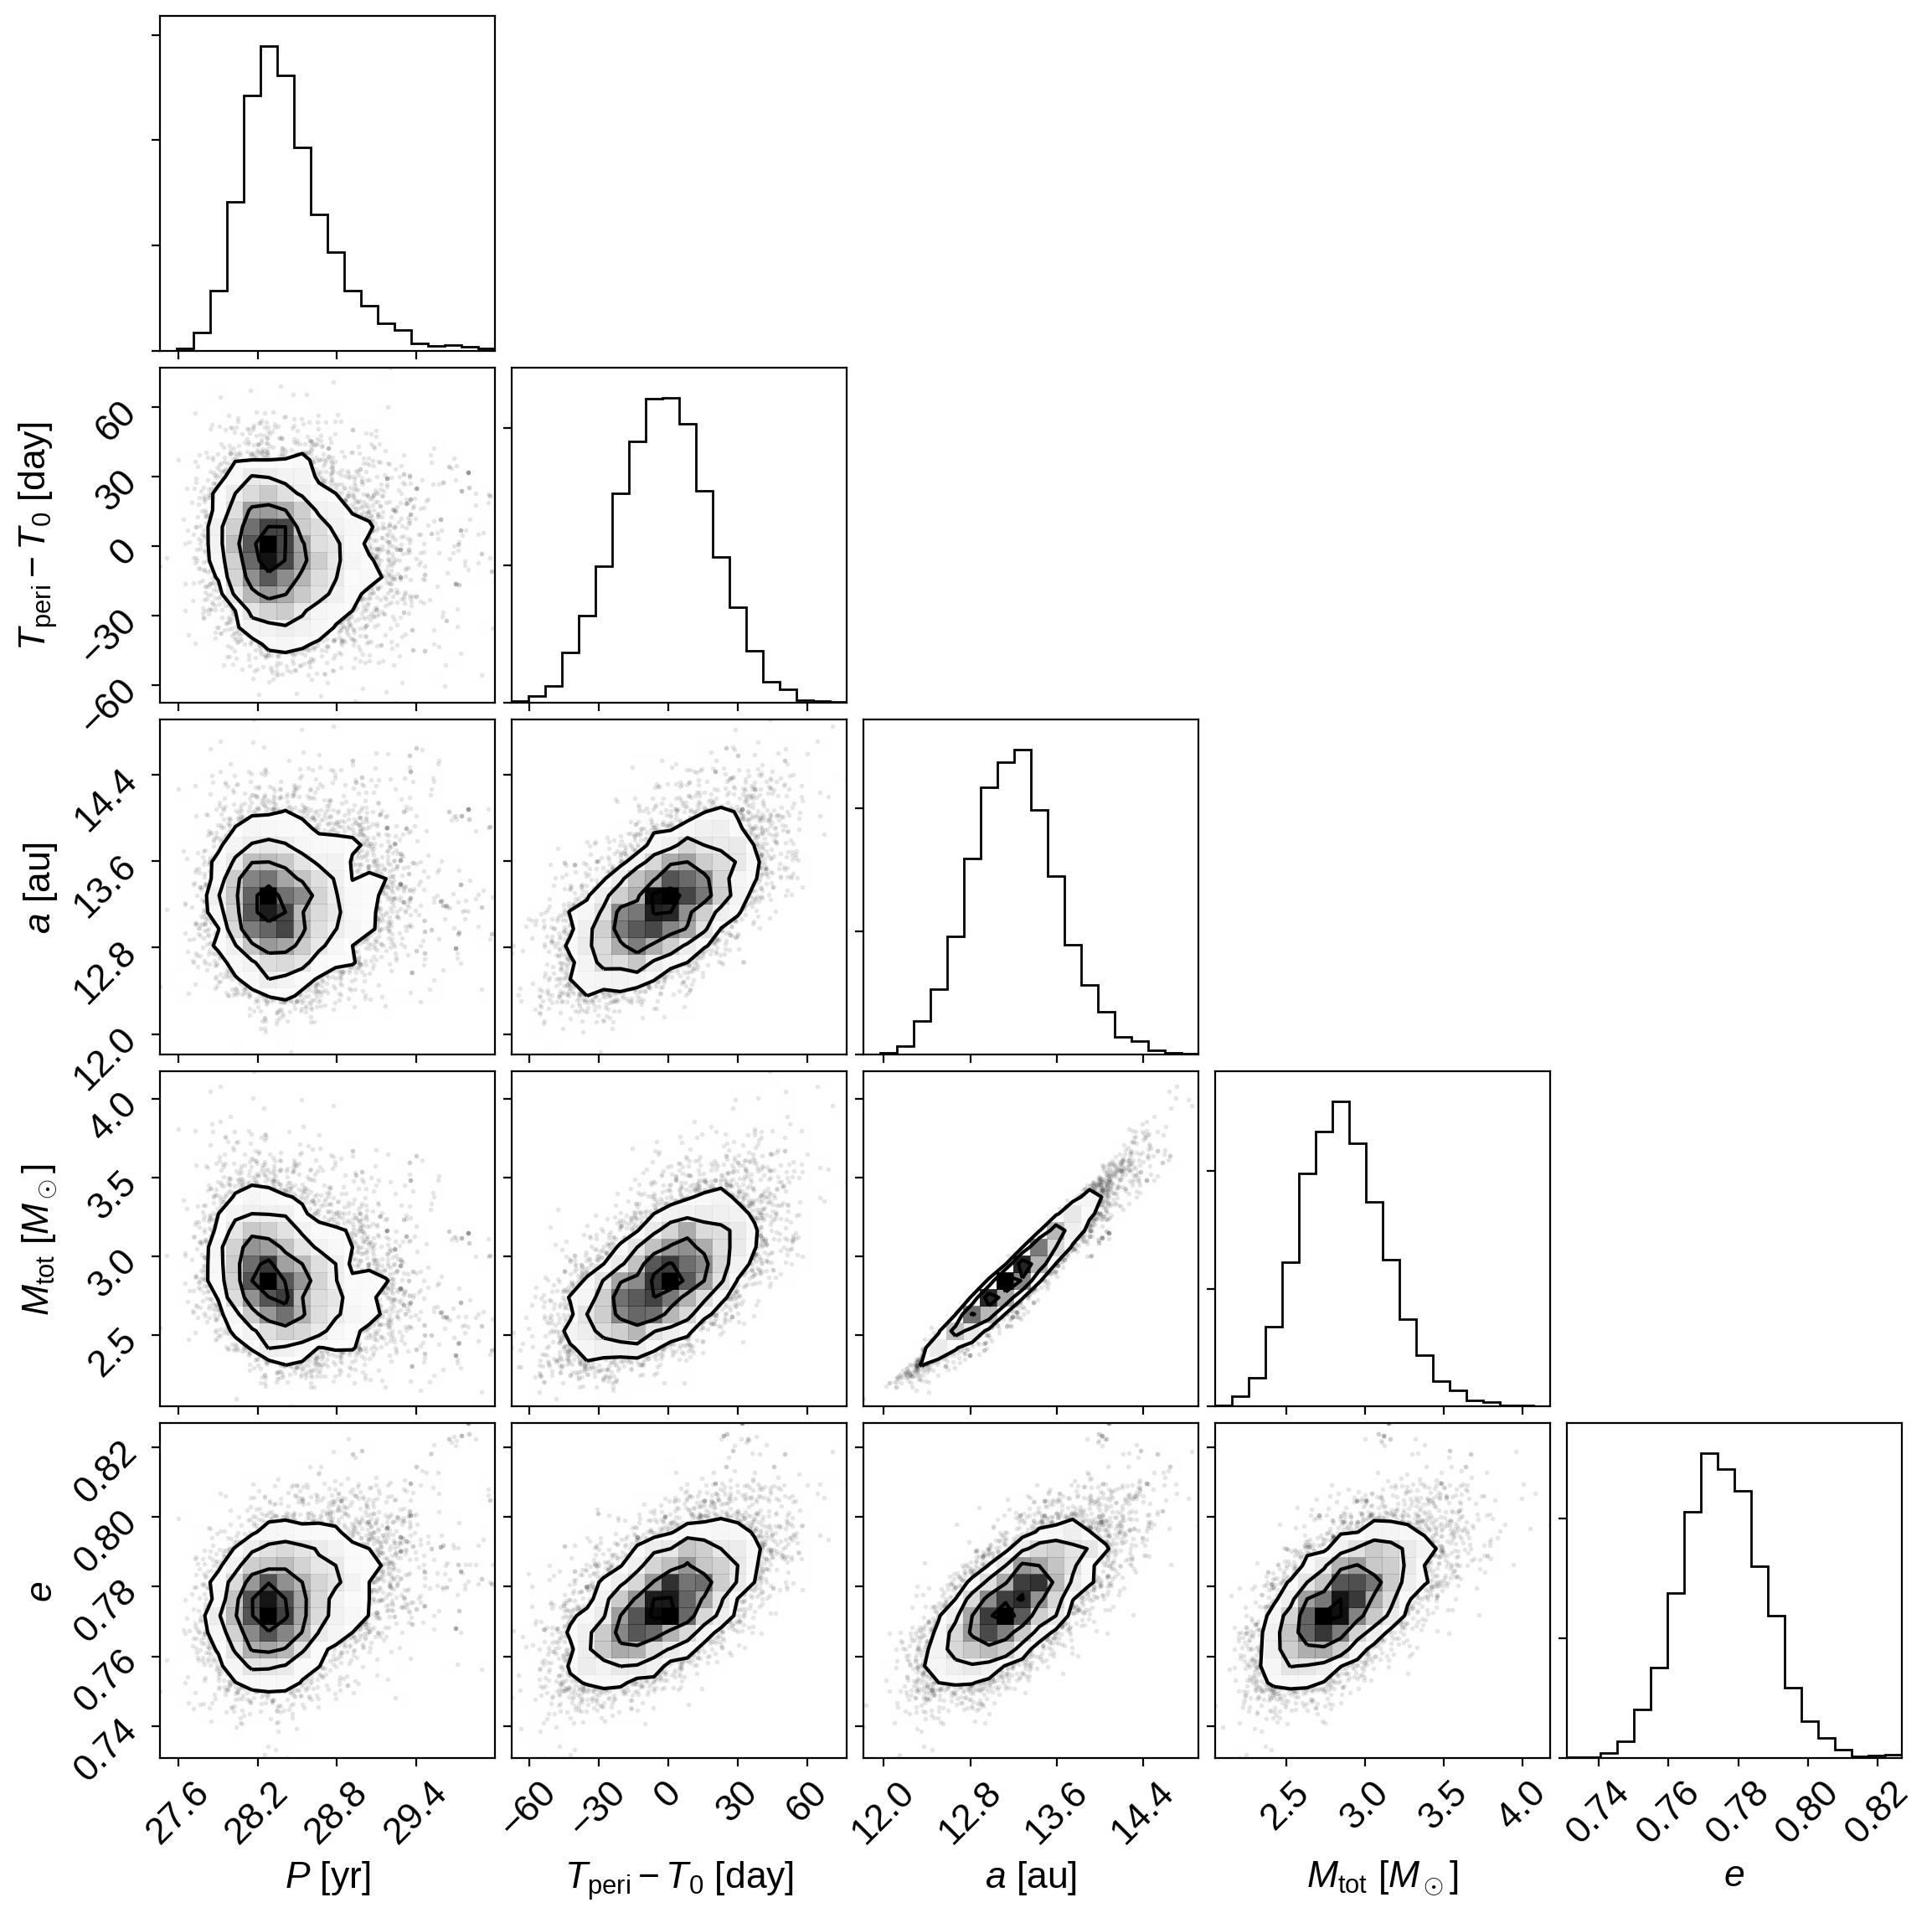

In [17]:
samples = pm.trace_to_dataframe(plx_trace, varnames=["ecc"])
samples["$P$ [yr]"] = plx_trace["P"] / yr
samples["$T_\mathrm{peri} - T_0$ [day]"] = plx_trace["tperi"] - T0
samples["$a$ [au]"] = plx_trace["a"]
samples["$M_\mathrm{tot}$ [$M_\odot$]"] = plx_trace["M_tot"]
samples["$e$"] = plx_trace["ecc"]
del samples["ecc"]
_ = corner.corner(samples)

## Citations

As described in the :ref:`citation` tutorial, we can use :func:`exoplanet.citations.get_citations_for_model` to construct an acknowledgement and BibTeX listing that includes the relevant citations for this model.

In [18]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:astropy13, exoplanet:astropy18,
exoplanet:exoplanet, exoplanet:pymc3, exoplanet:theano}.


In [19]:
print("\n".join(bib.splitlines()[:10]) + "\n...")


@misc{exoplanet:exoplanet,
  author = {Daniel Foreman-Mackey and Rodrigo Luger and Ian Czekala and
            Eric Agol and Adrian Price-Whelan and Tom Barclay},
   title = {exoplanet-dev/exoplanet v0.3.2},
   month = may,
    year = 2020,
     doi = {10.5281/zenodo.1998447},
     url = {https://doi.org/10.5281/zenodo.1998447}
}
...
